# Drawing utilities

# Analysis

ignored 1 based on ignored_colors 


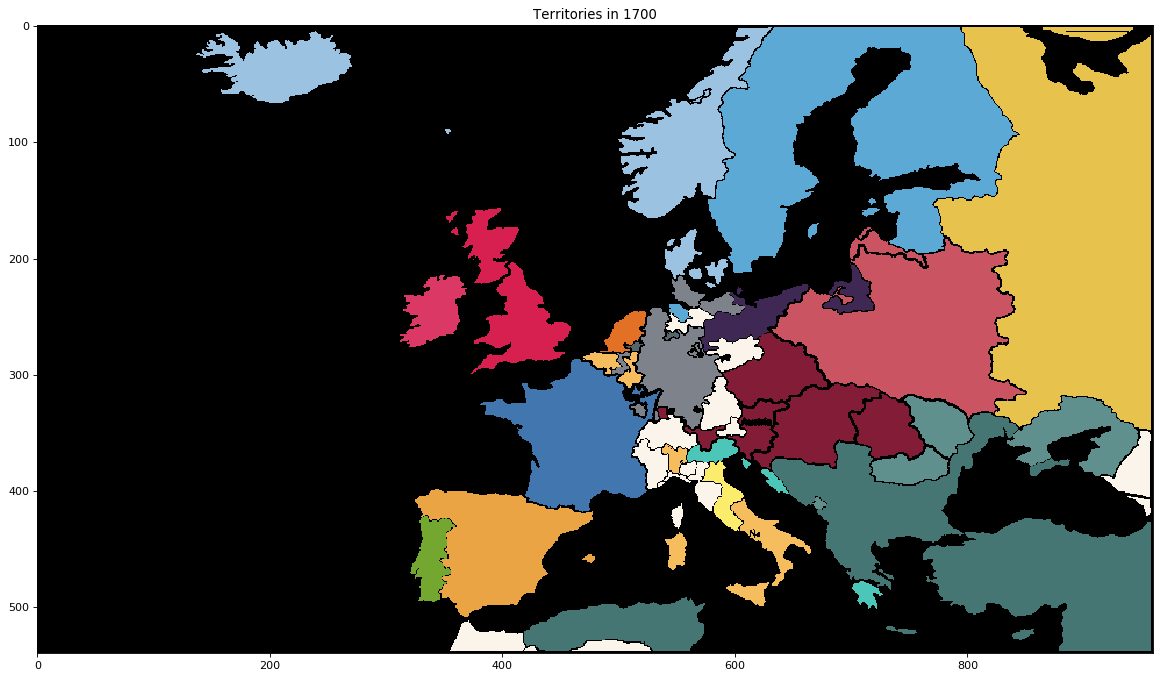

ignored 1 based on ignored_colors 


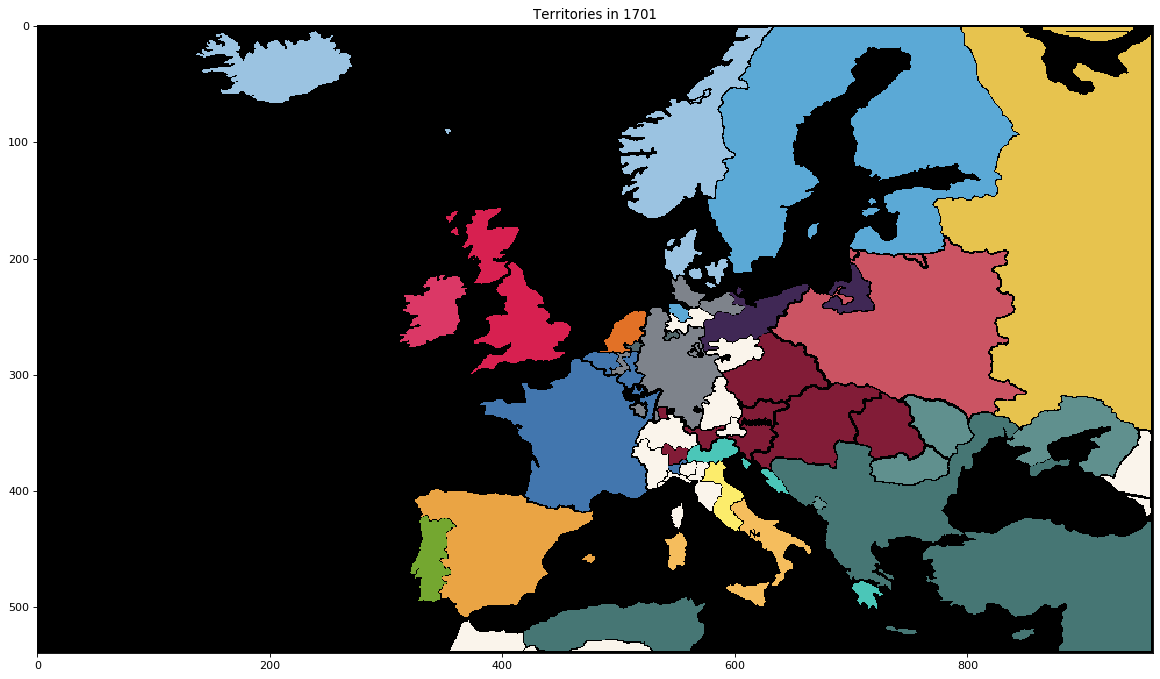

ignored 1 based on ignored_colors 


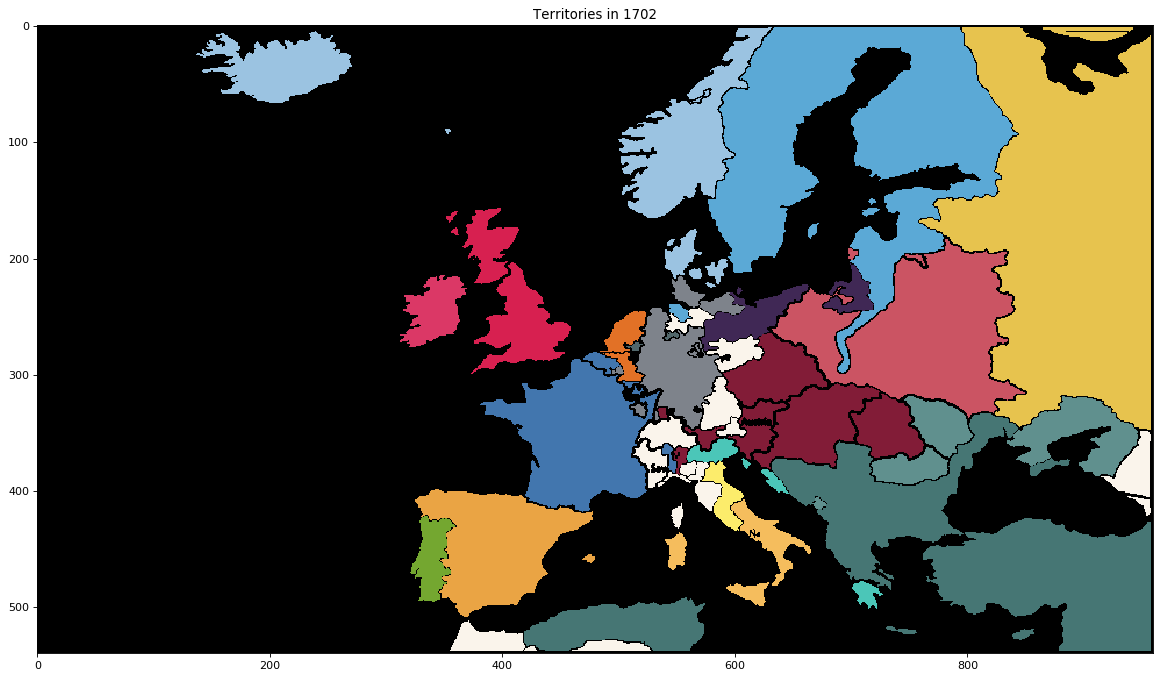

ignored 1 based on ignored_colors 


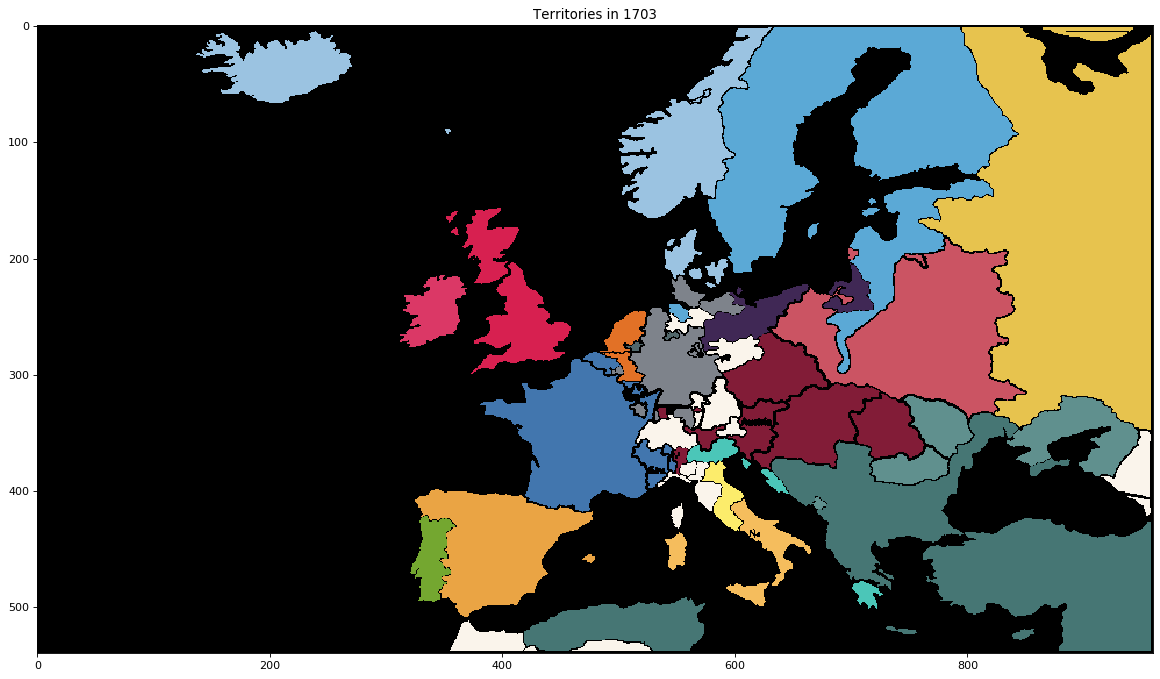

ignored 1 based on ignored_colors 


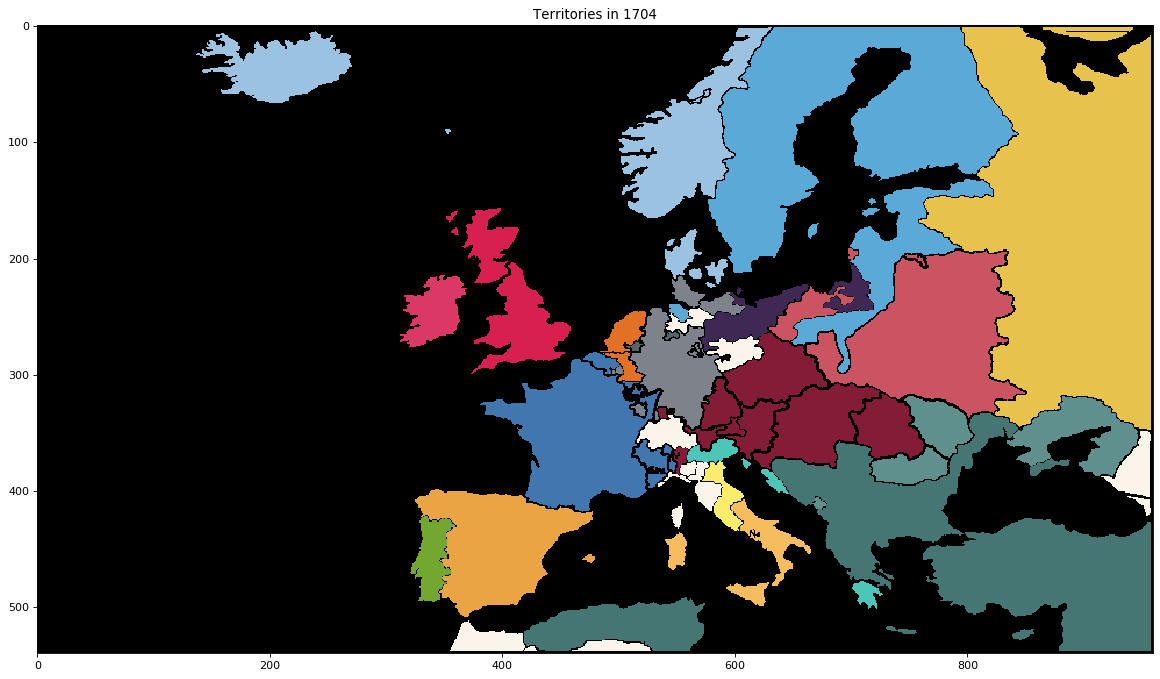

ignored 1 based on ignored_colors 


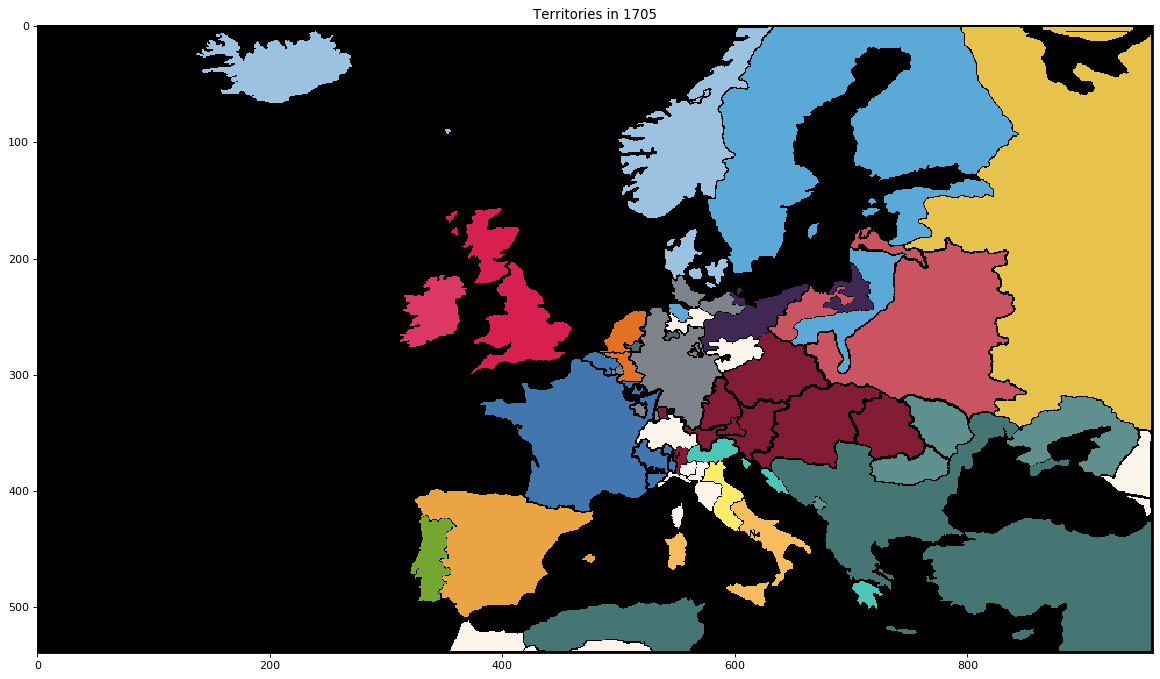

ignored 1 based on ignored_colors 


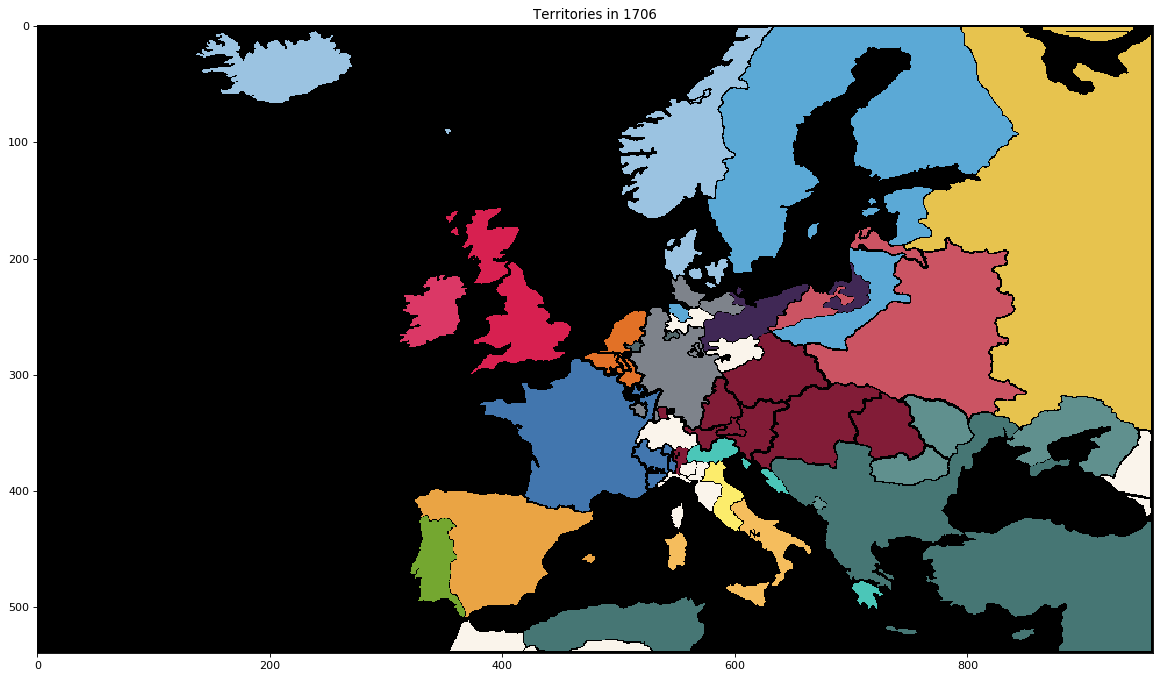

ignored 1 based on ignored_colors 


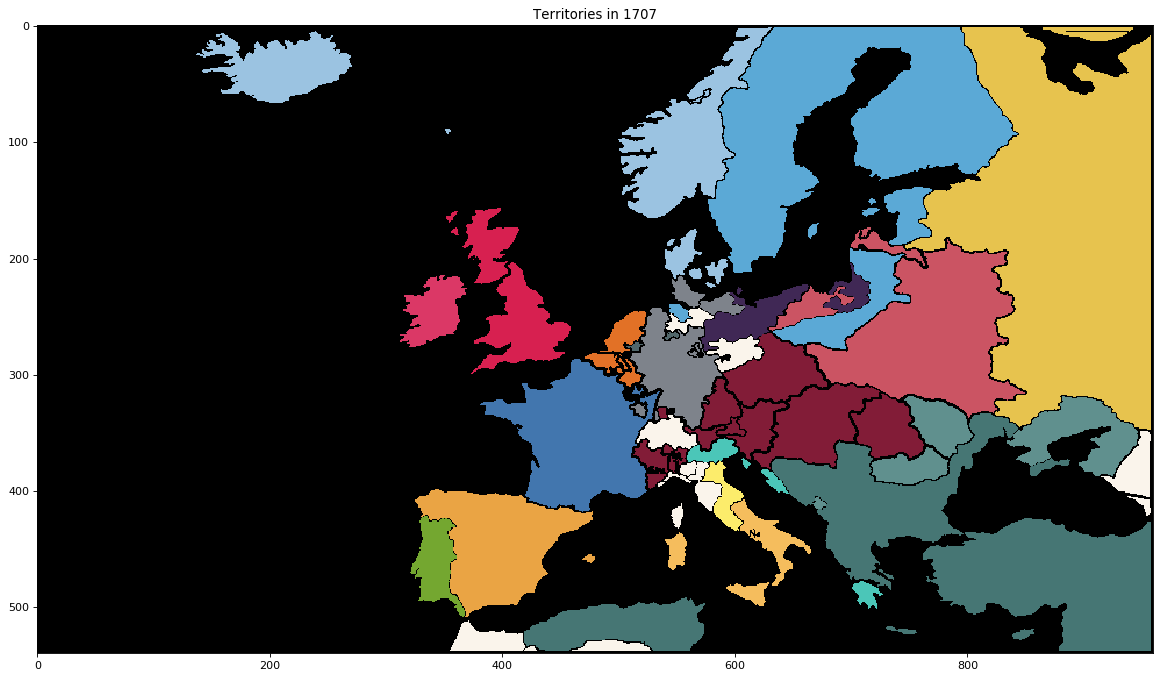

ignored 1 based on ignored_colors 


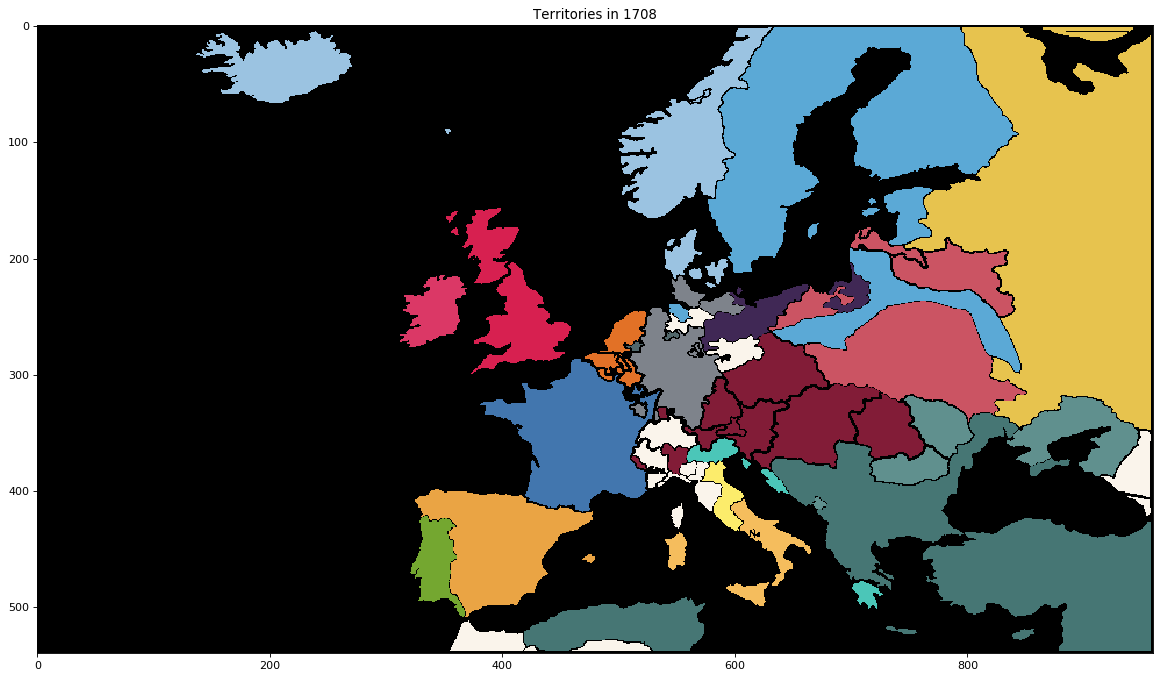

ignored 1 based on ignored_colors 


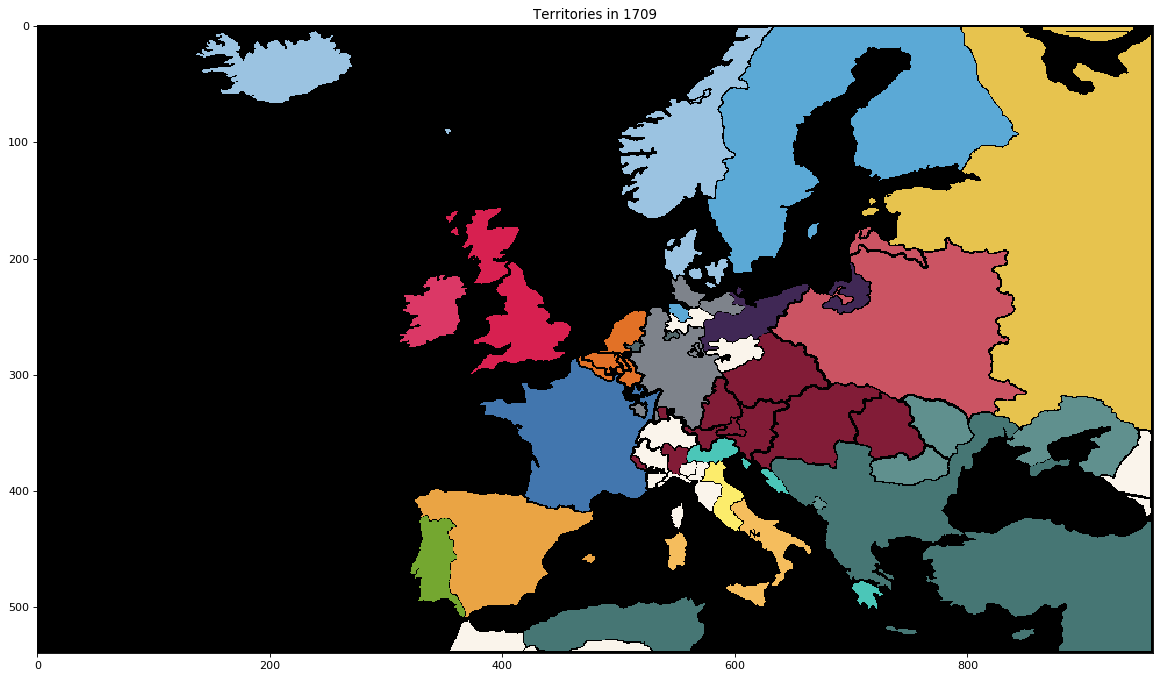

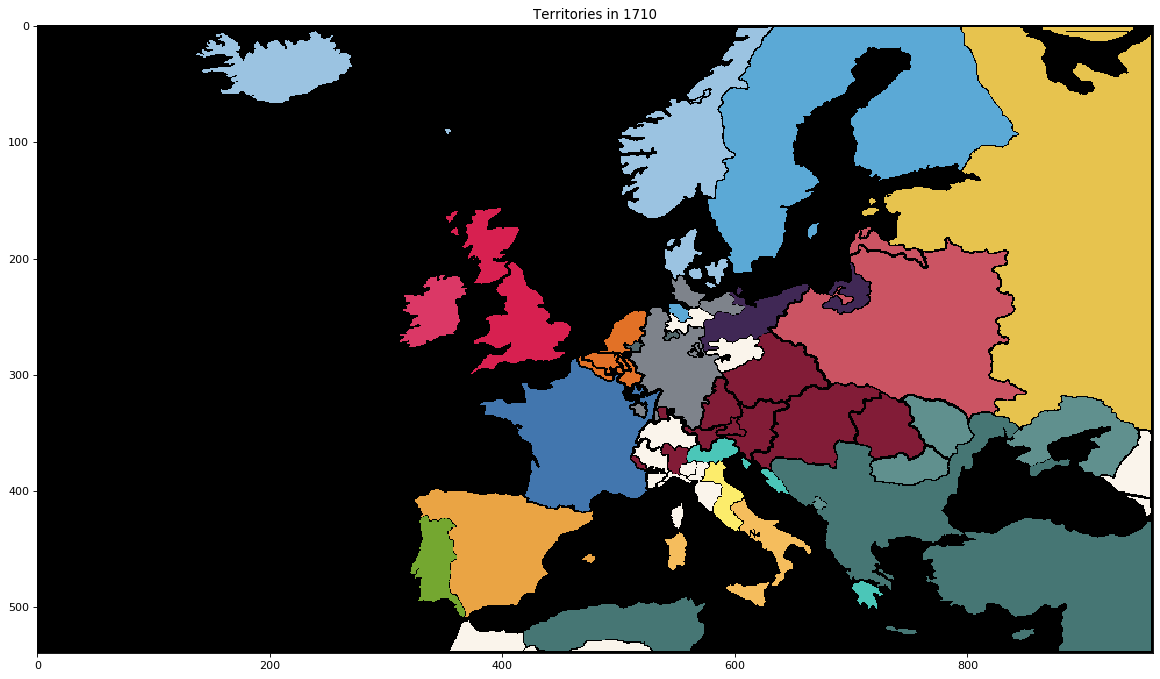

ignored 1 based on ignored_colors 


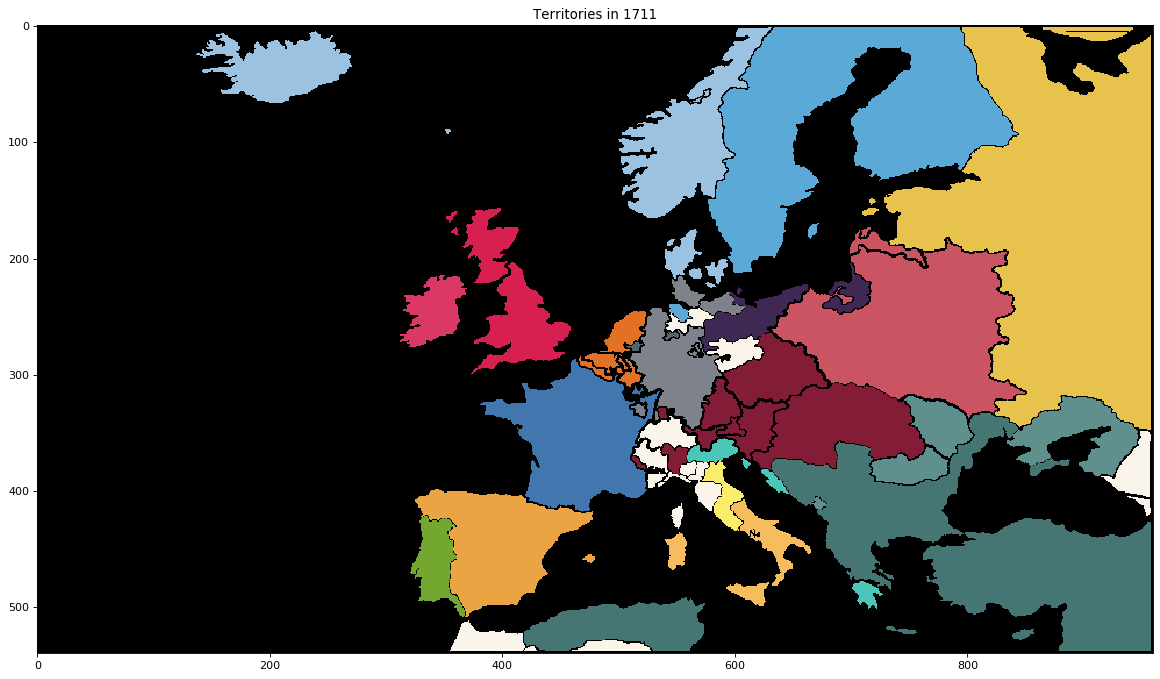

ignored 1 based on ignored_colors 


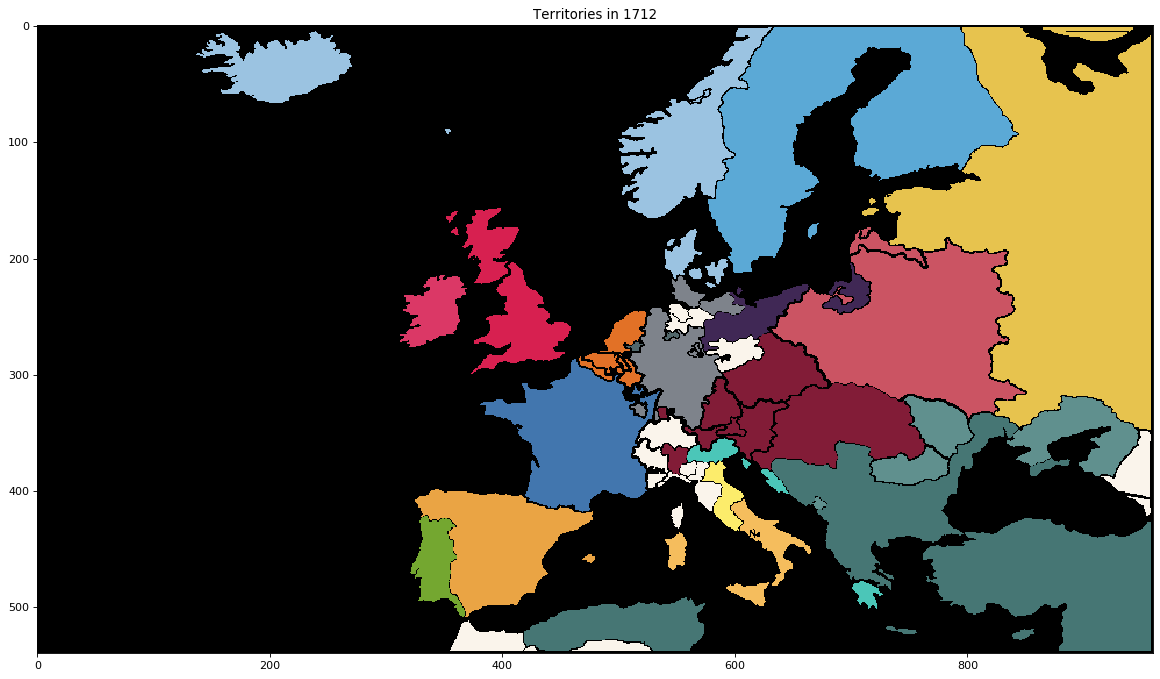

ignored 1 based on ignored_colors 


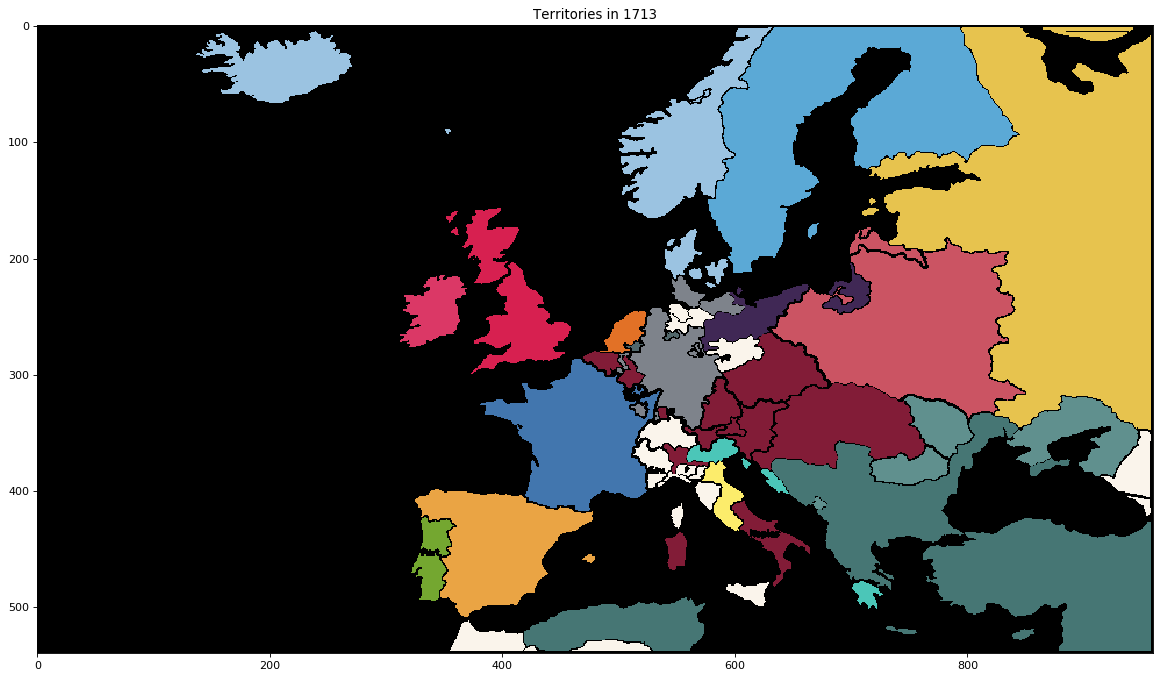

ignored 1 based on ignored_colors 


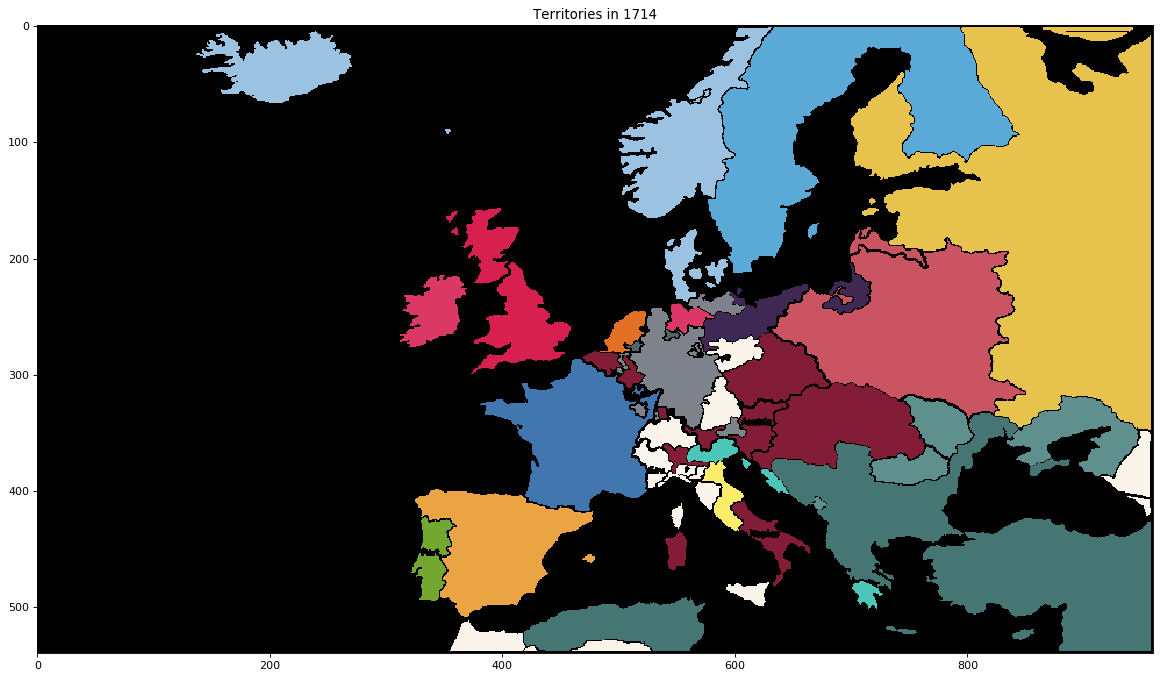

ignored 1 based on ignored_colors 


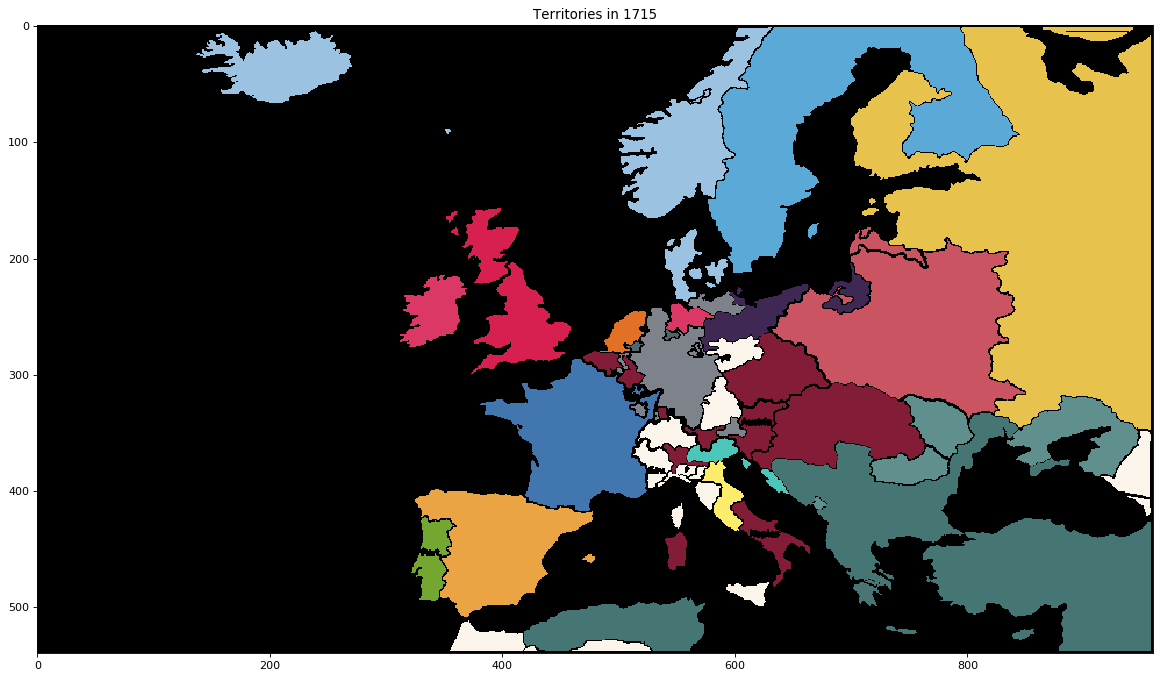

ignored 1 based on ignored_colors 


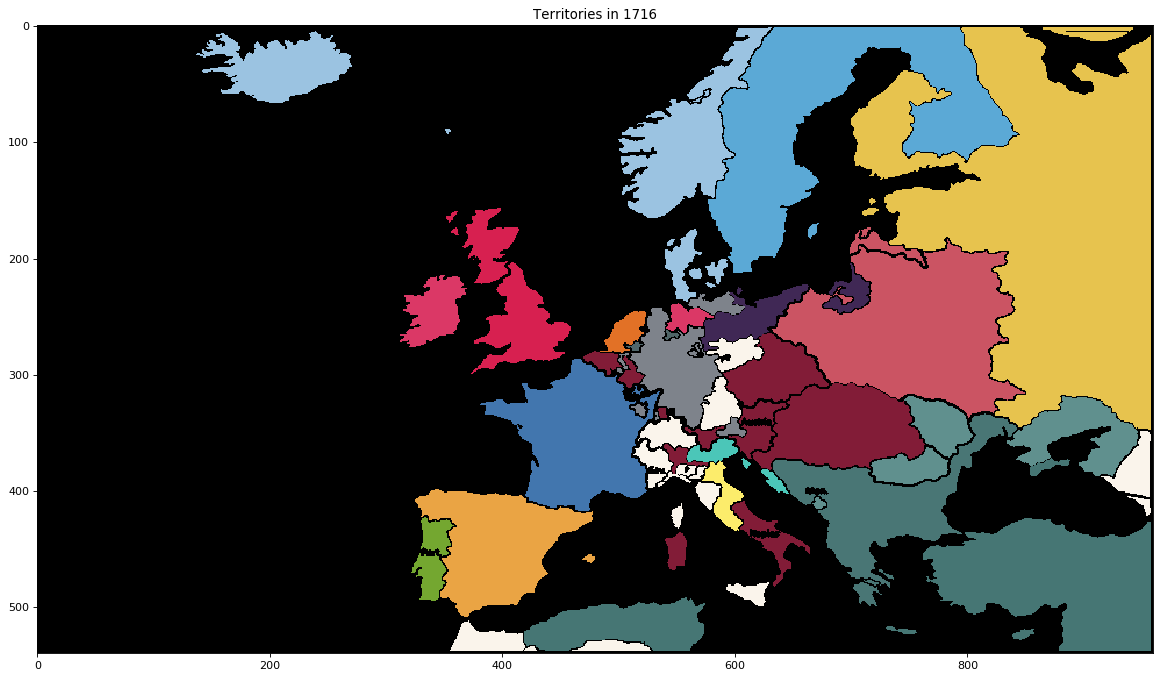

ignored 1 based on ignored_colors 


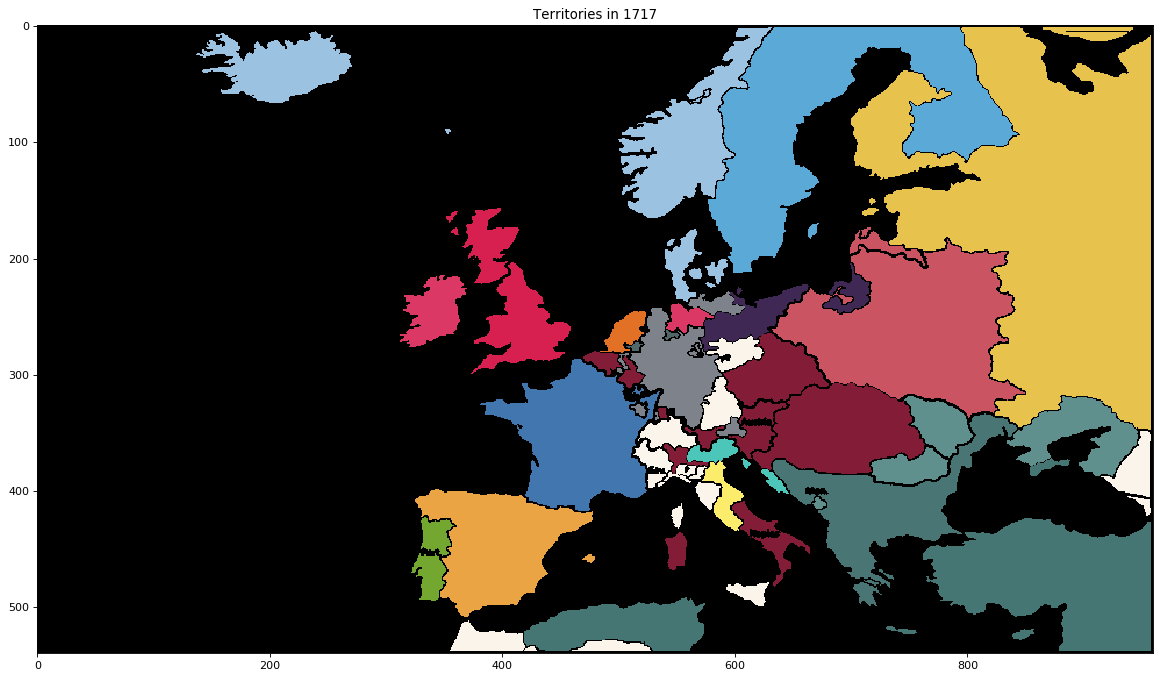

ignored 1 based on ignored_colors 


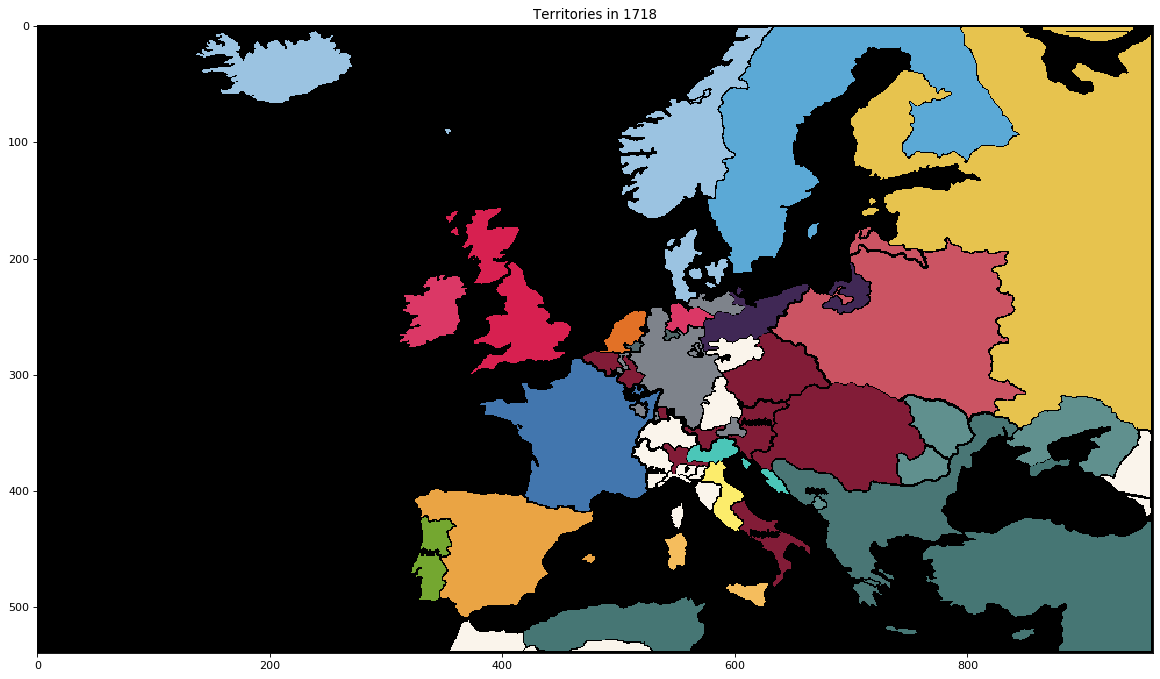

ignored 1 based on ignored_colors 


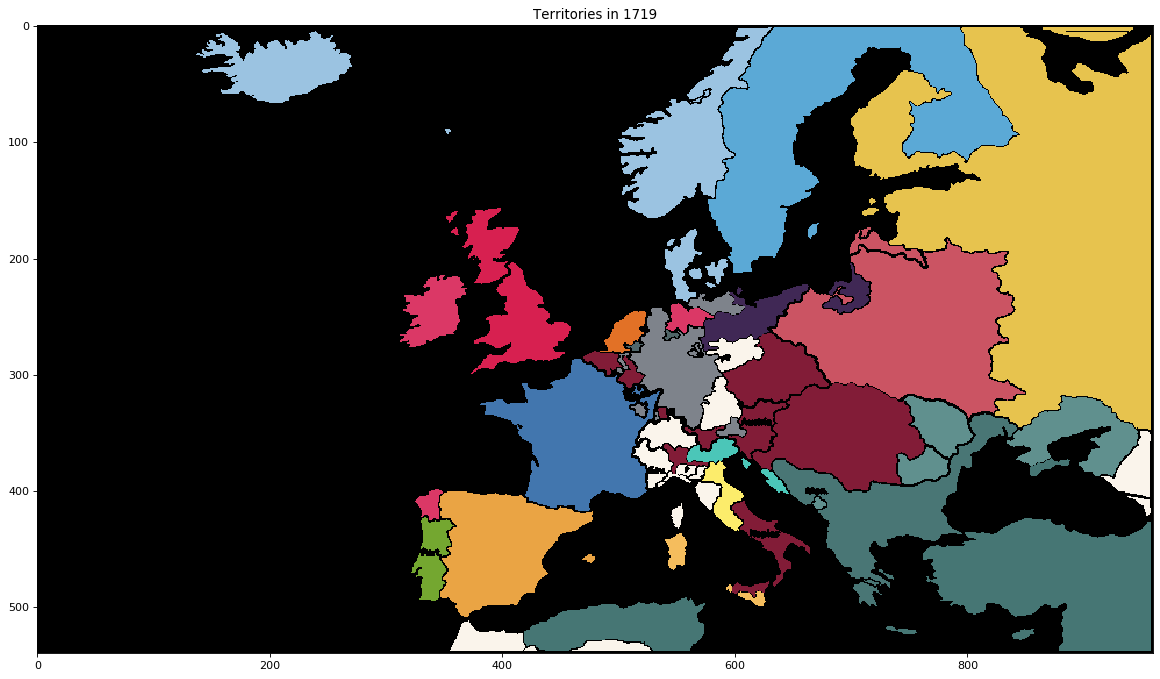

ignored 1 based on ignored_colors 


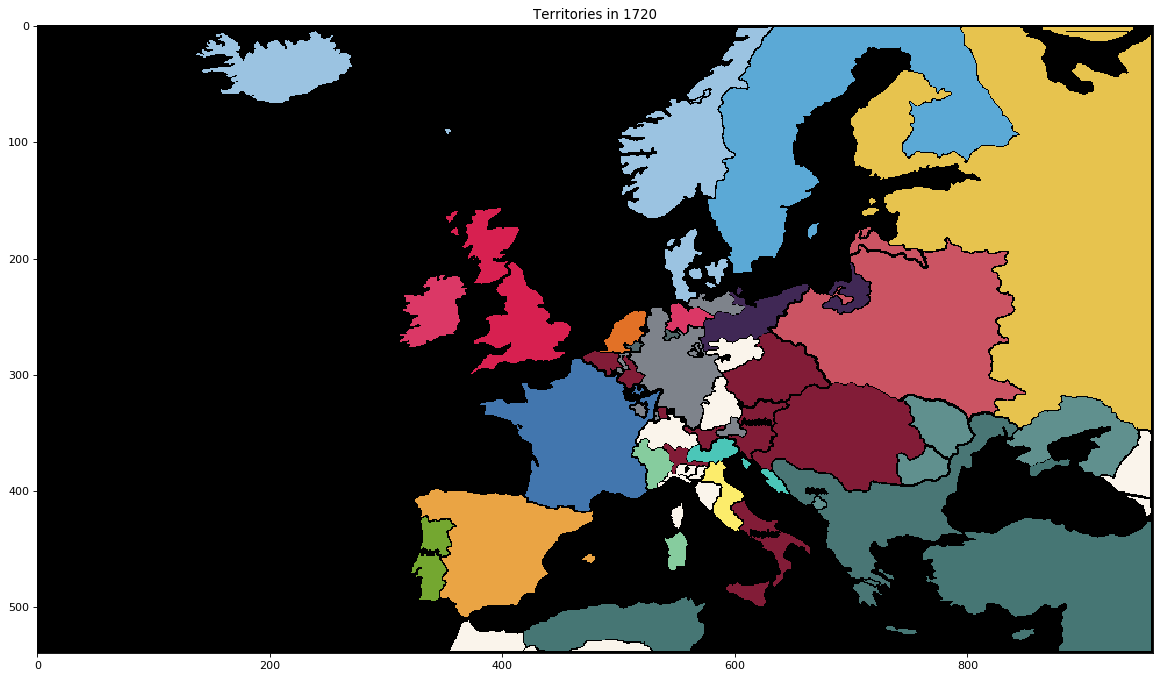

ignored 1 based on ignored_colors 


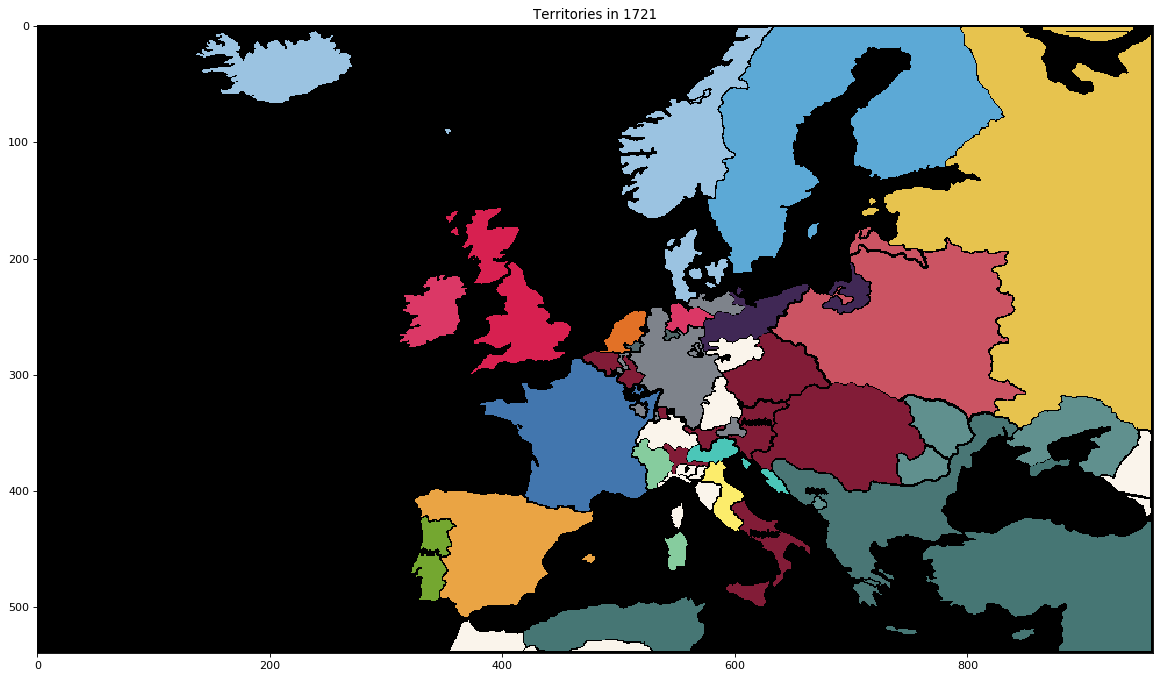

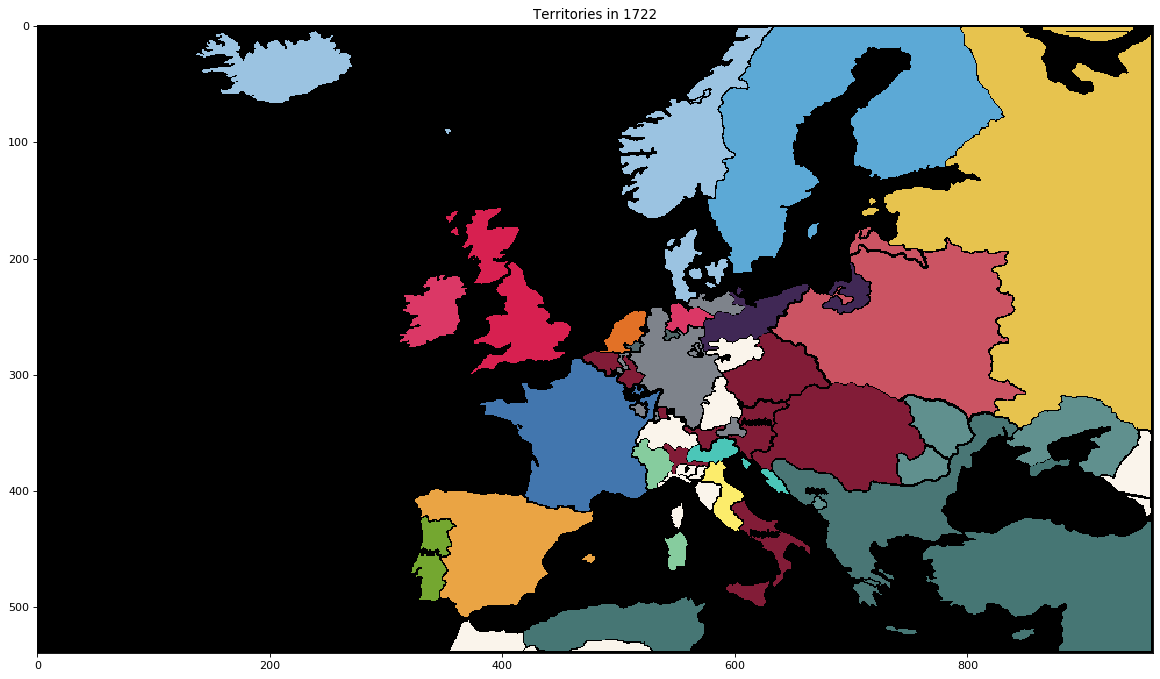

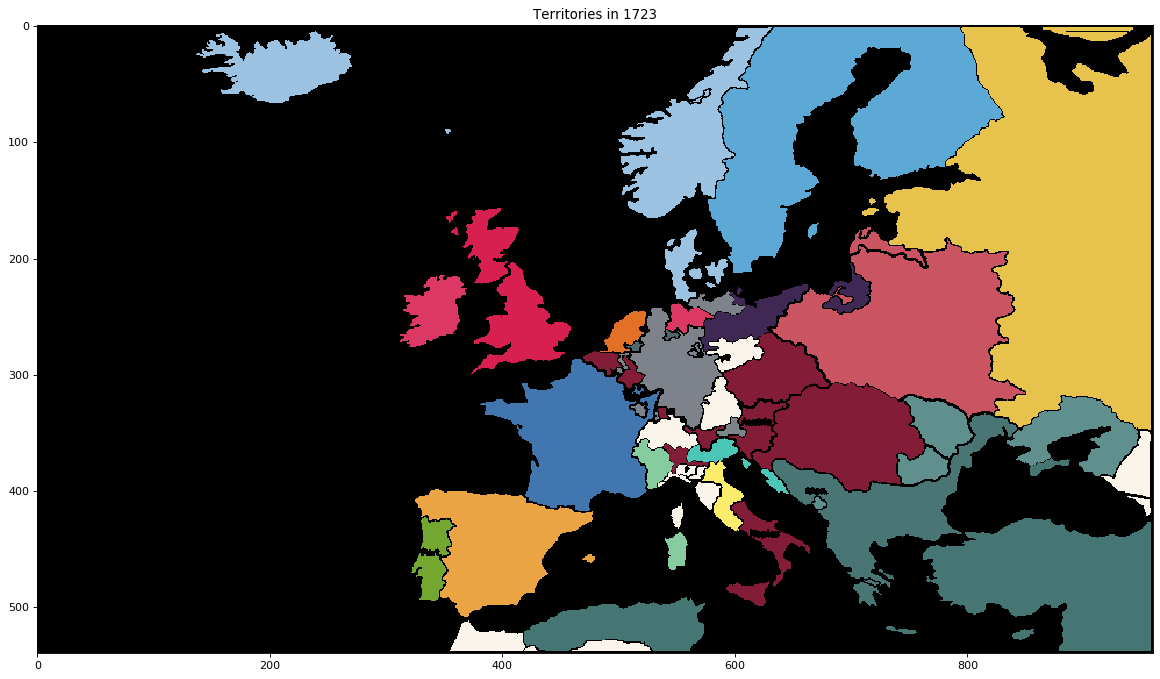

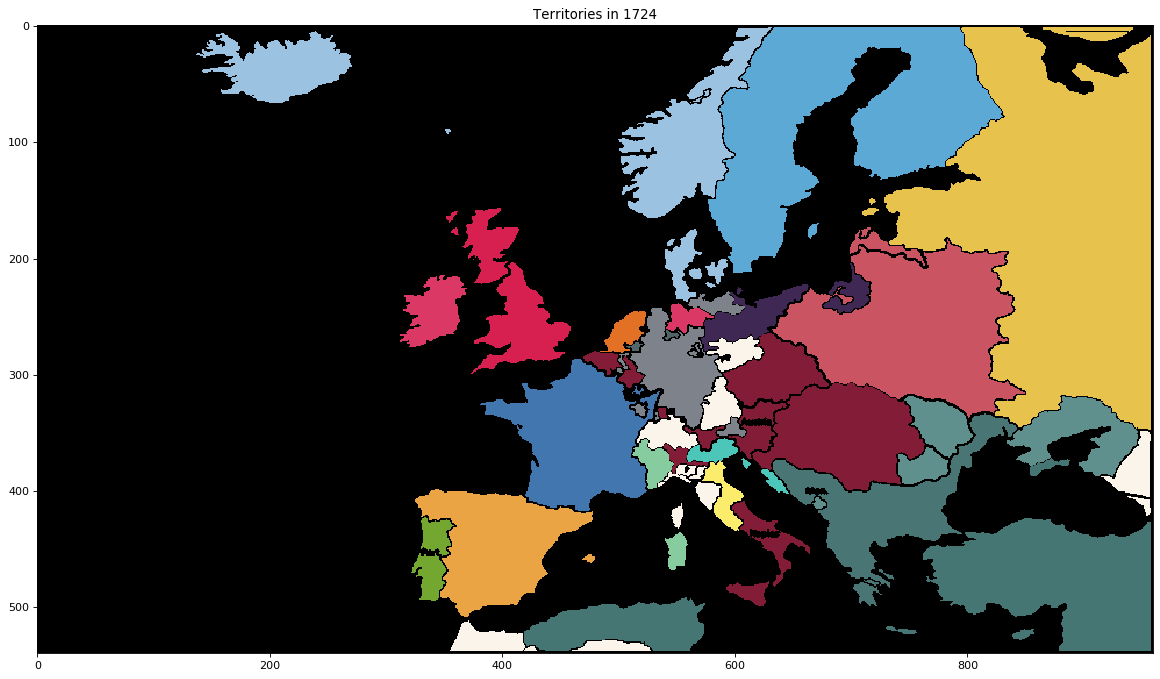

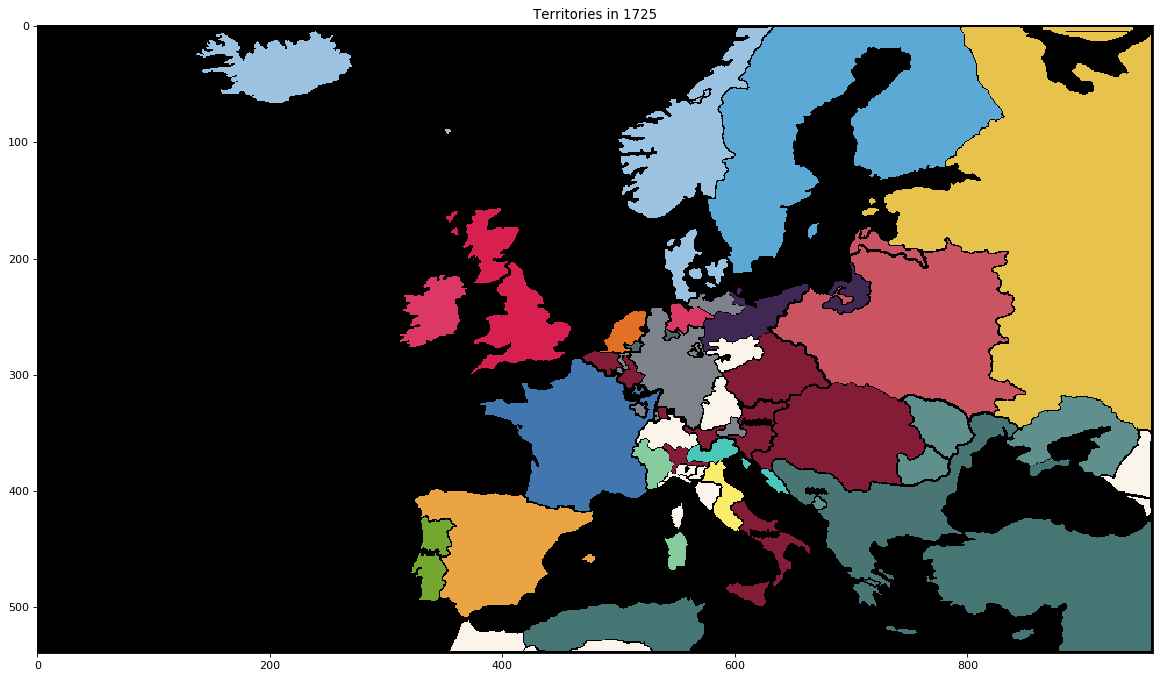

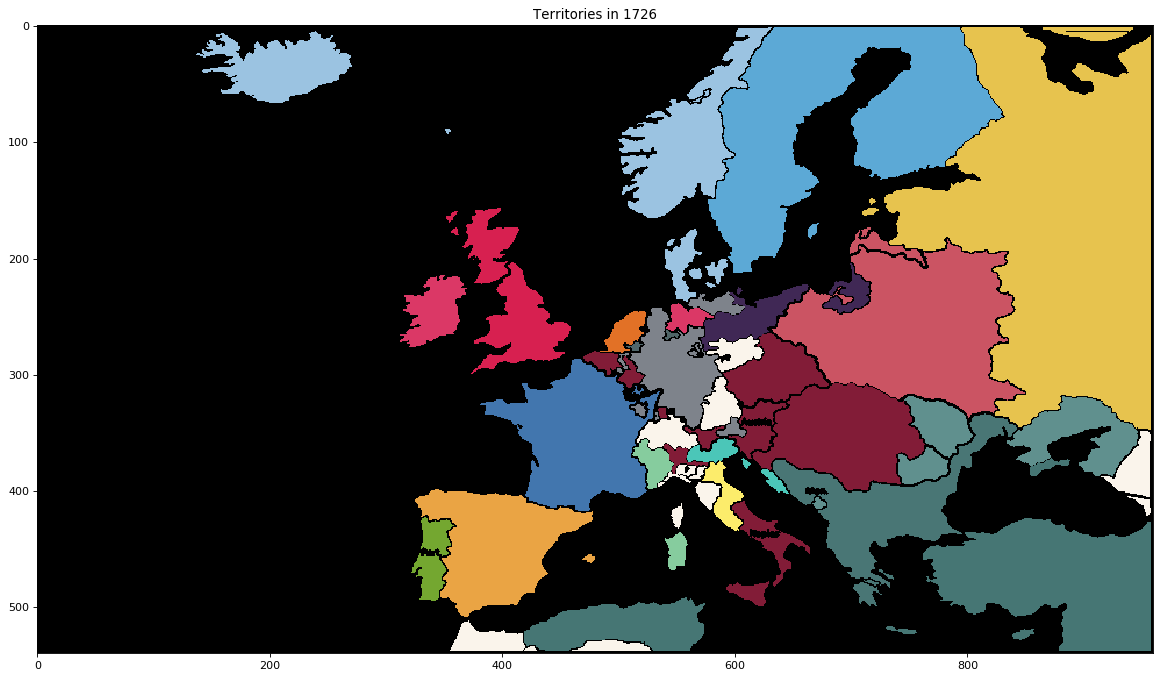

ignored 1 based on ignored_colors 


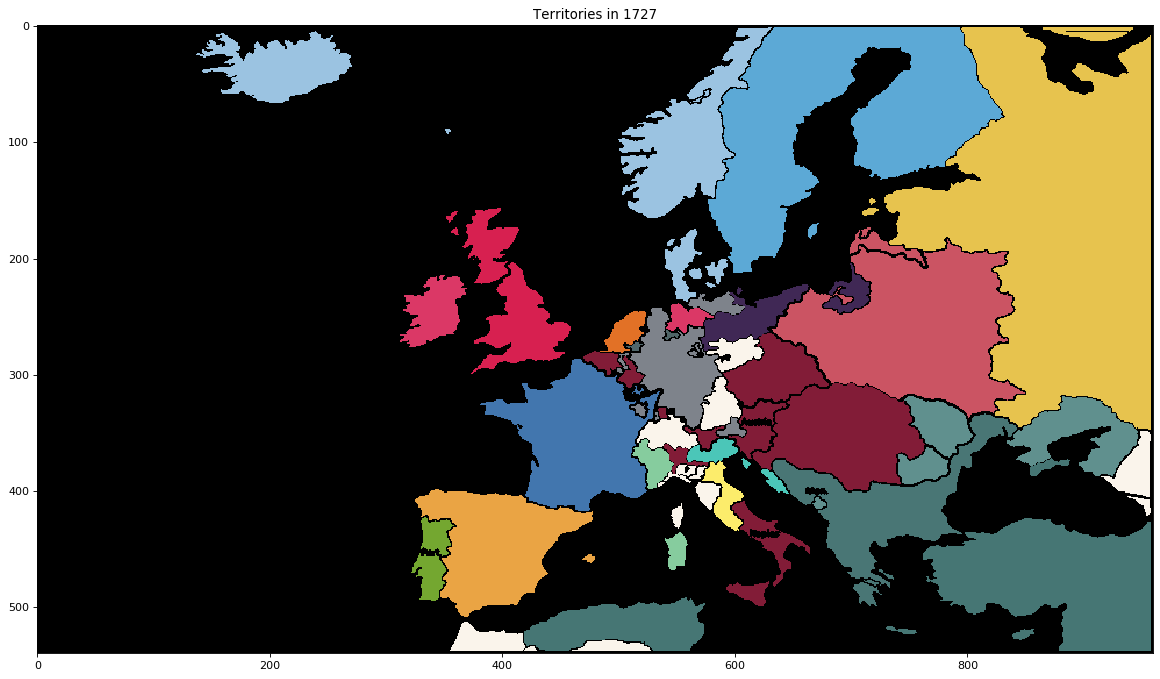

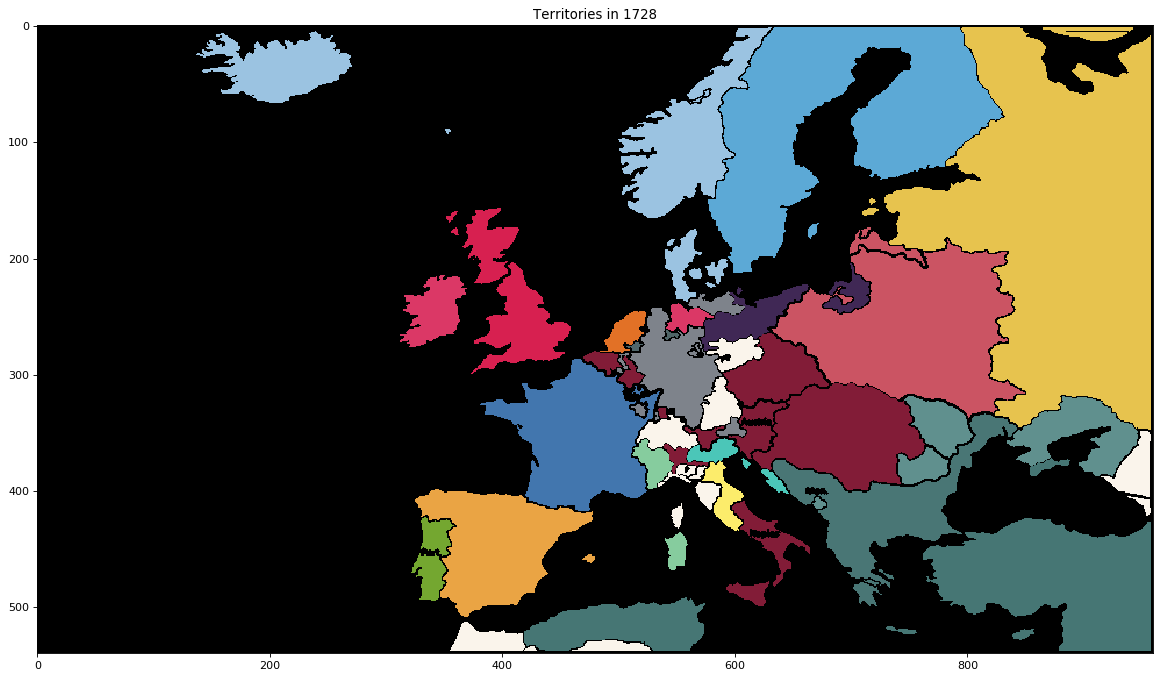

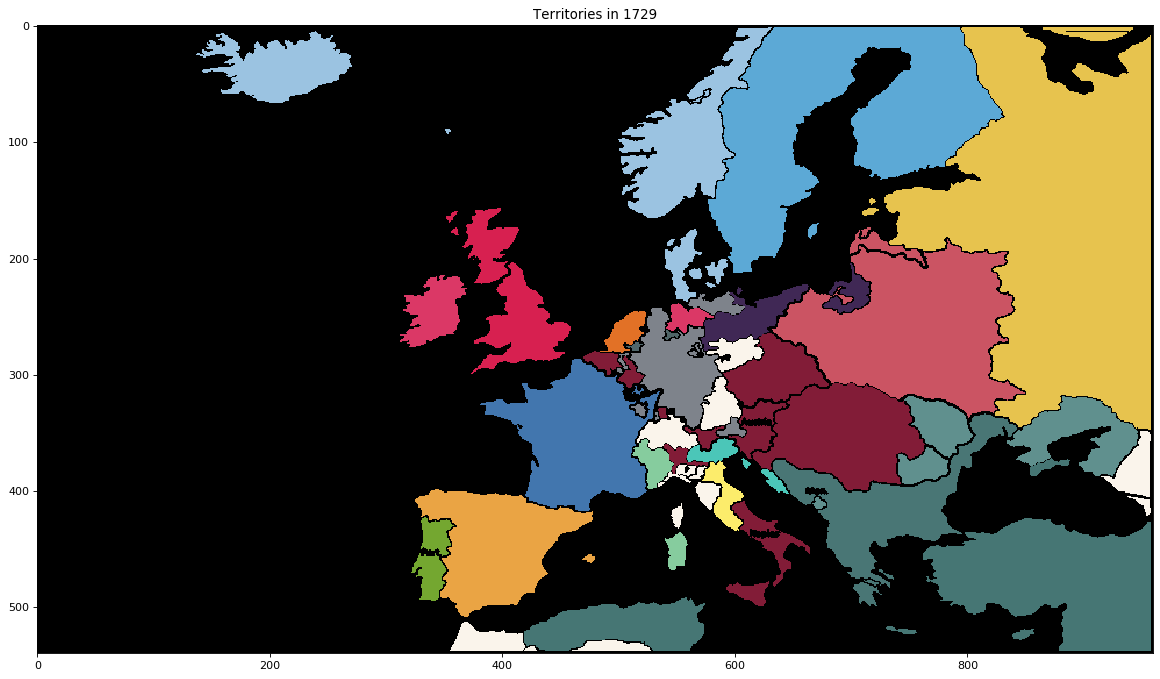

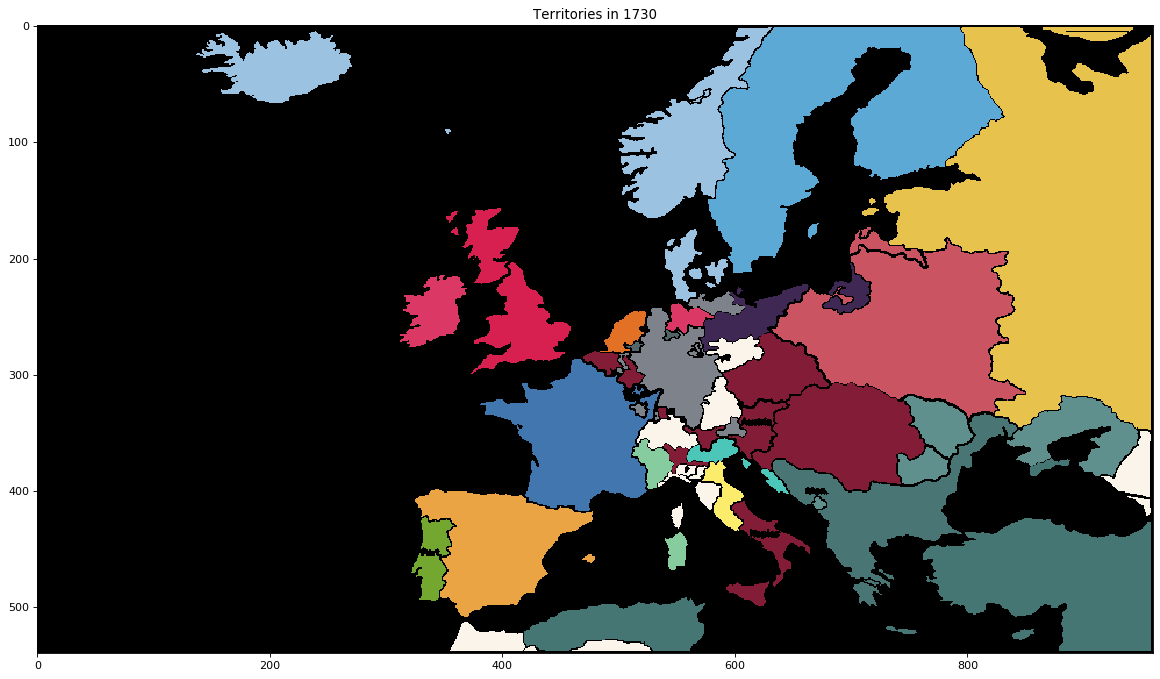

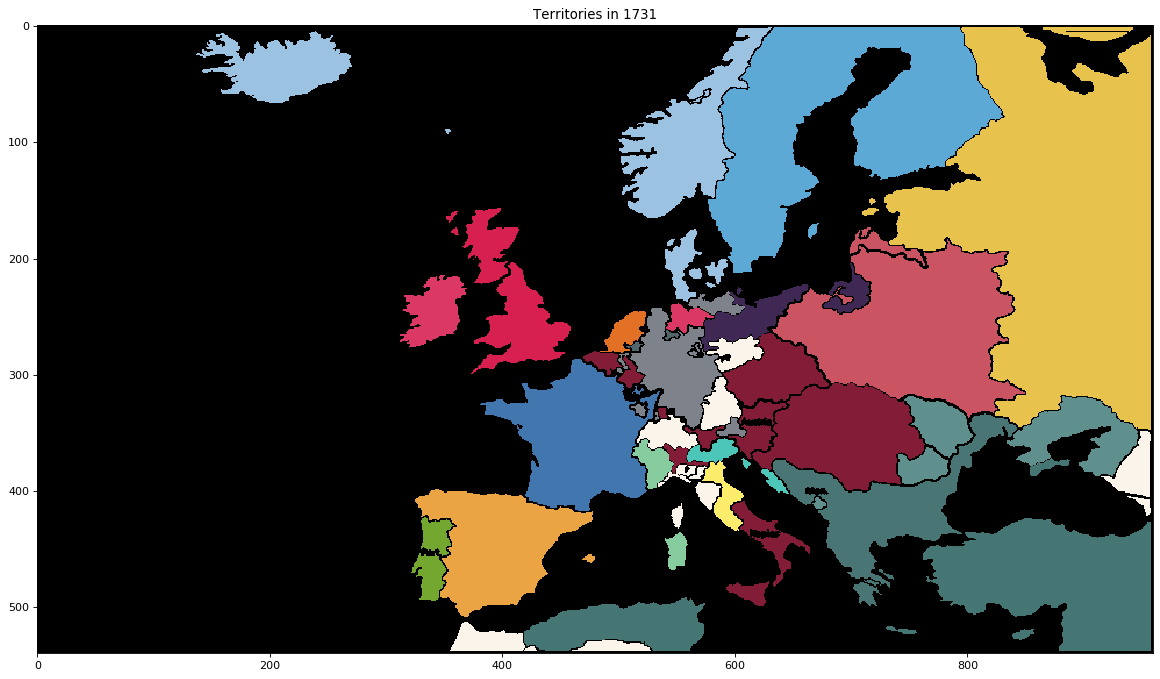

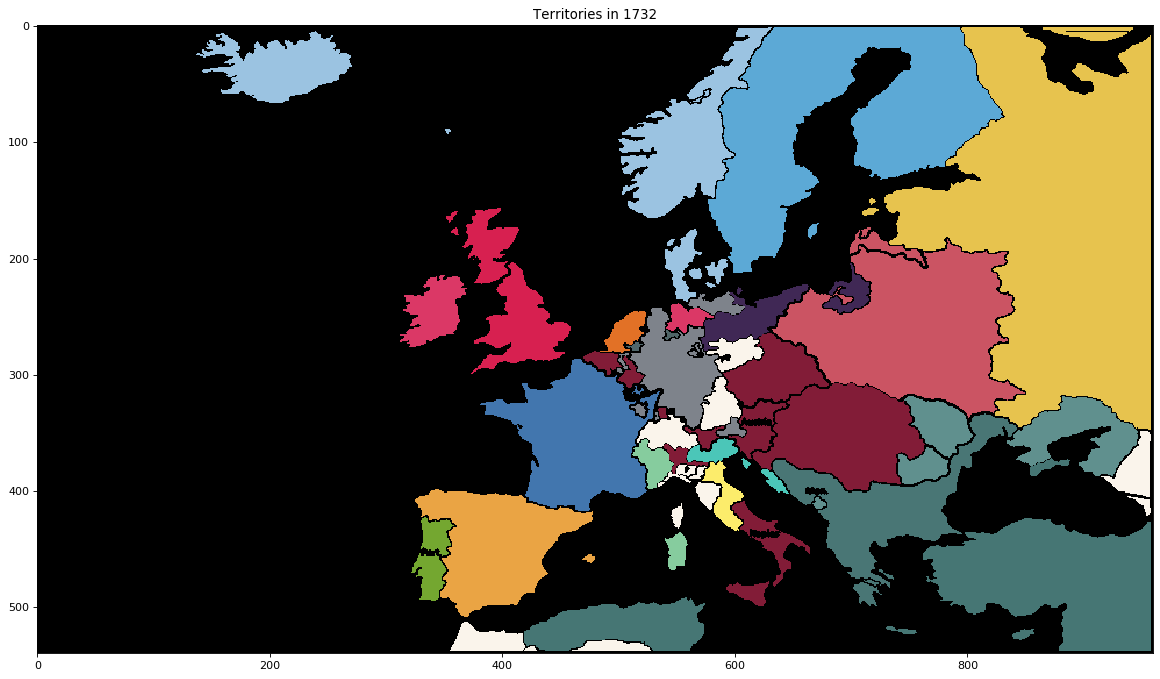

ignored 2 based on ignored_colors 


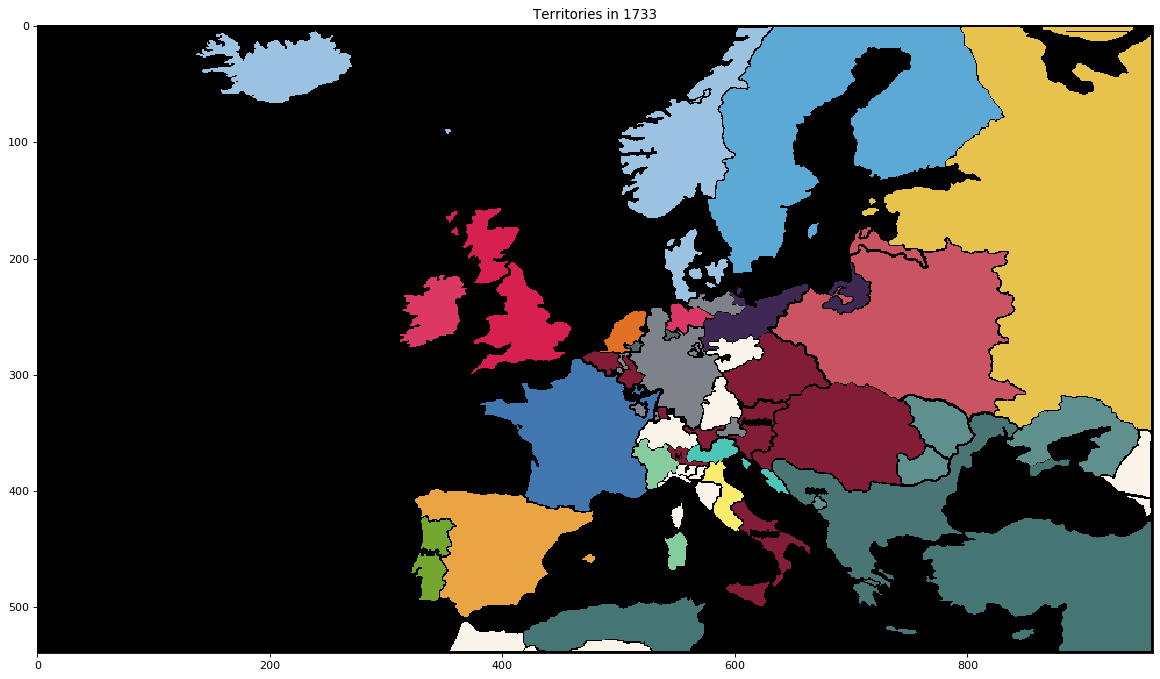

ignored 2 based on ignored_colors 


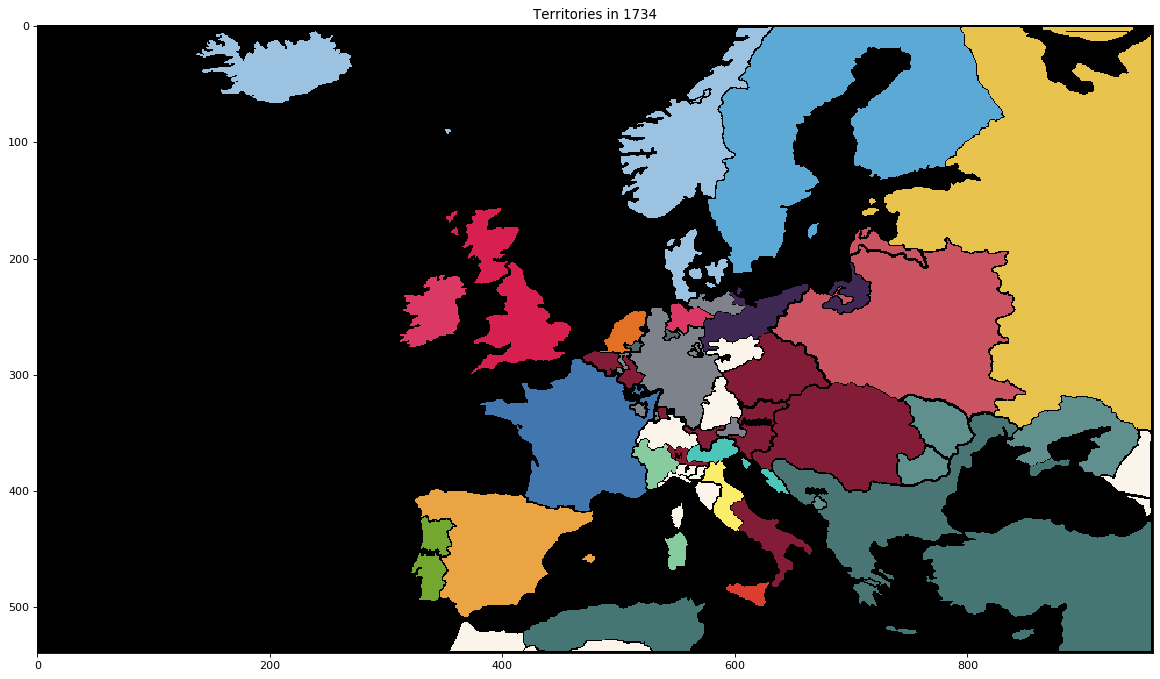

ignored 2 based on ignored_colors 


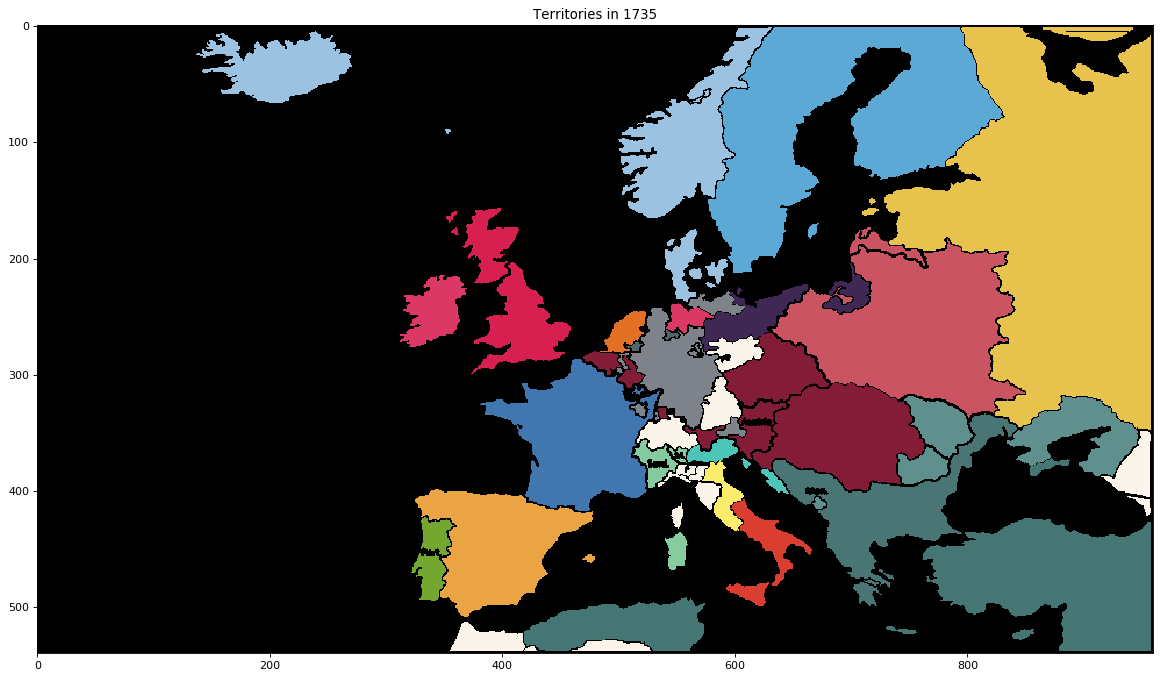

ignored 2 based on ignored_colors 


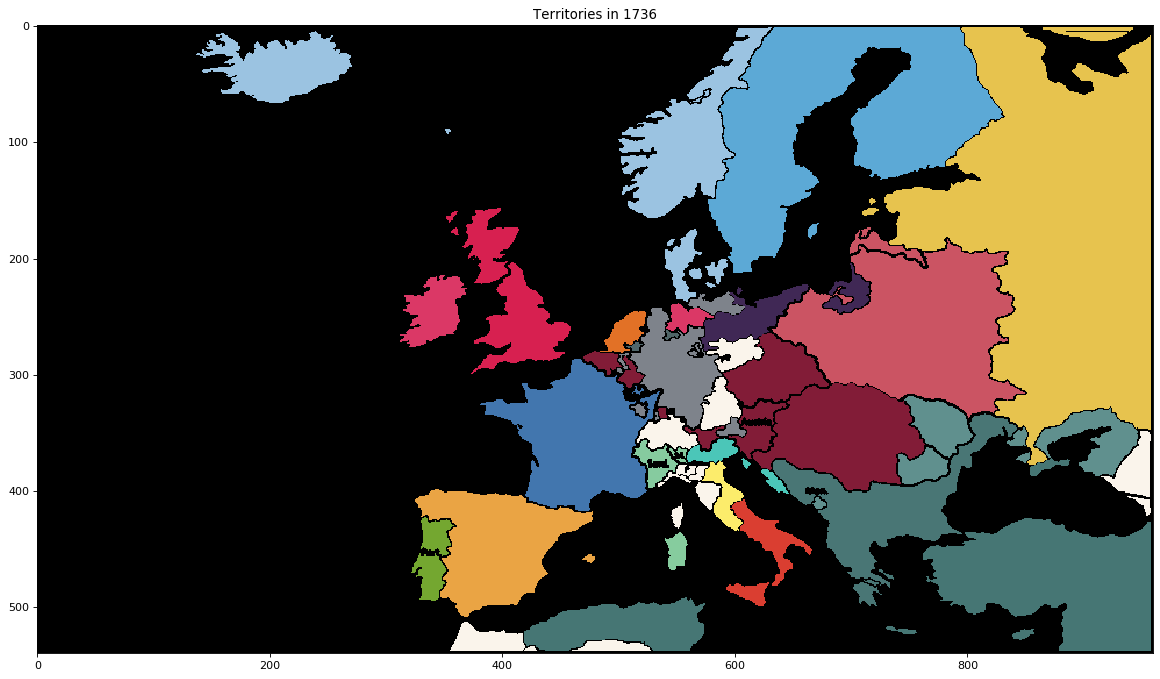

ignored 2 based on ignored_colors 


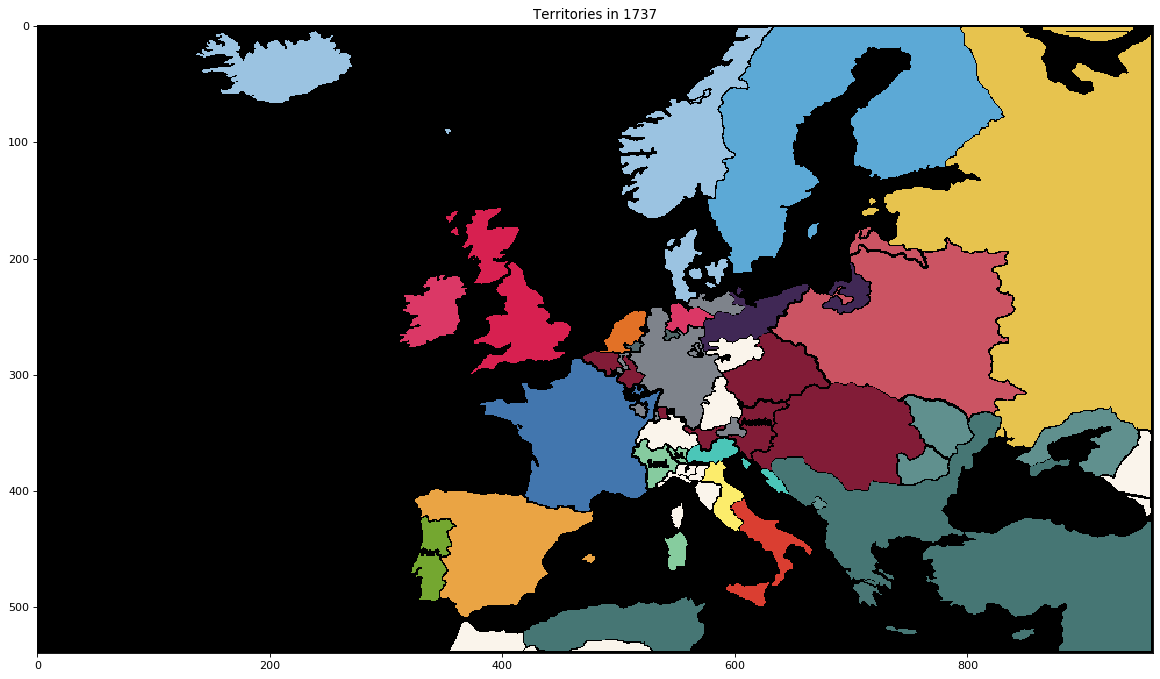

ignored 2 based on ignored_colors 


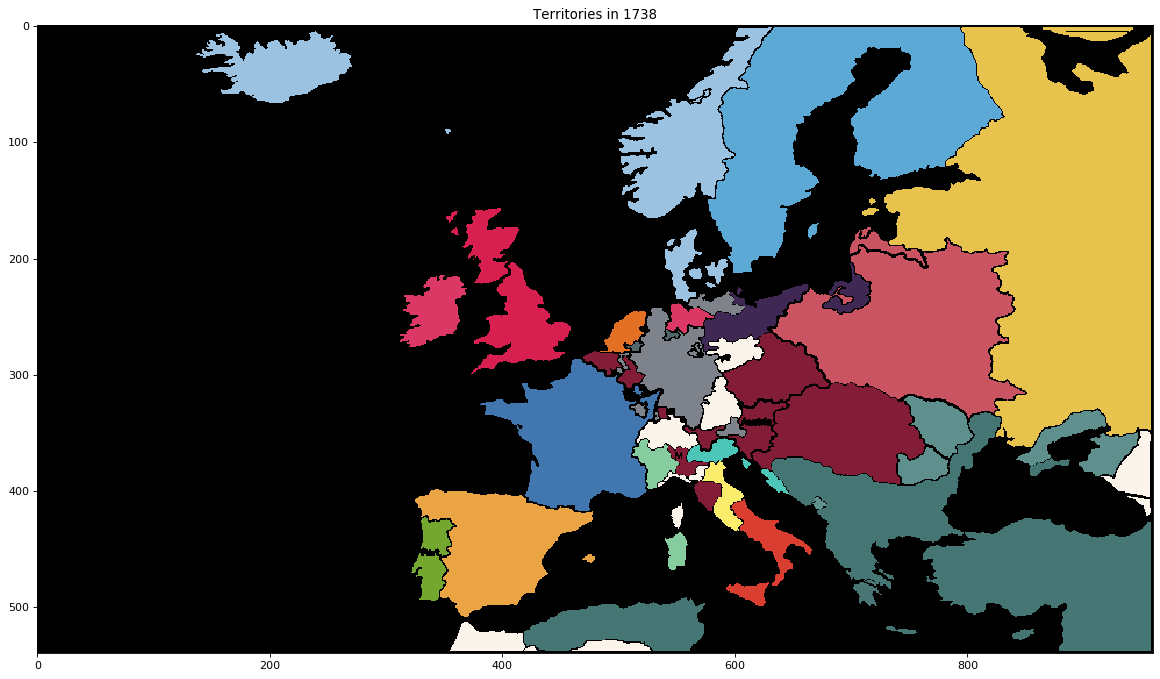

ignored 2 based on ignored_colors 


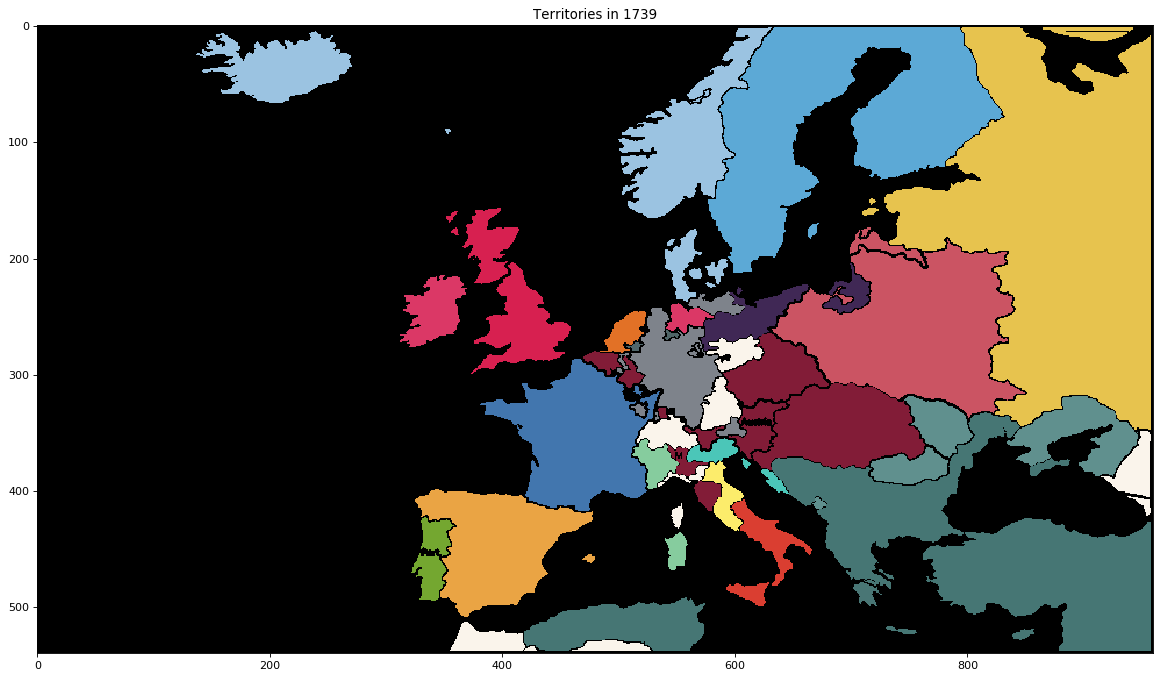

ignored 2 based on ignored_colors 


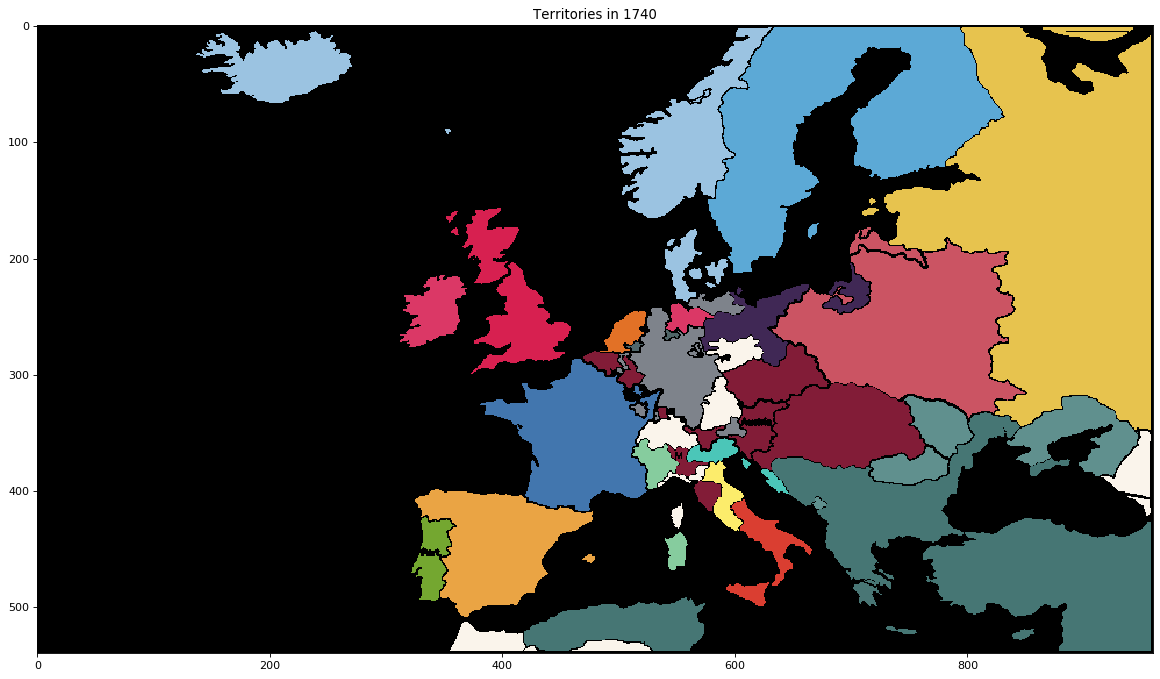

ignored 2 based on ignored_colors 


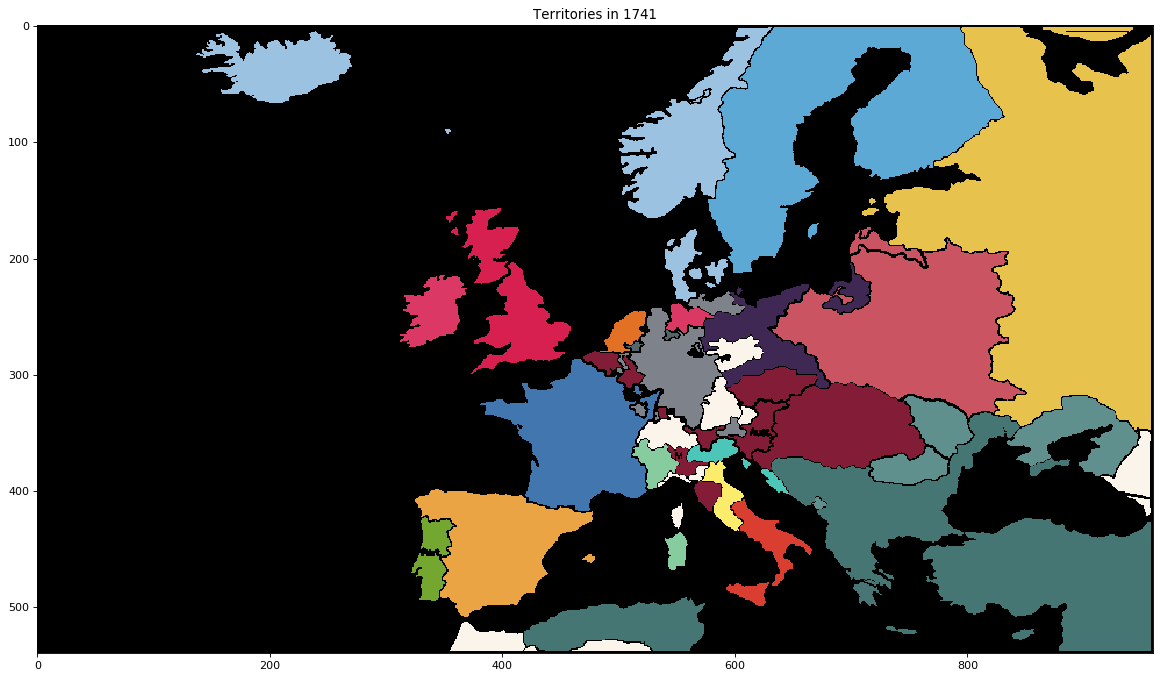

ignored 2 based on ignored_colors 


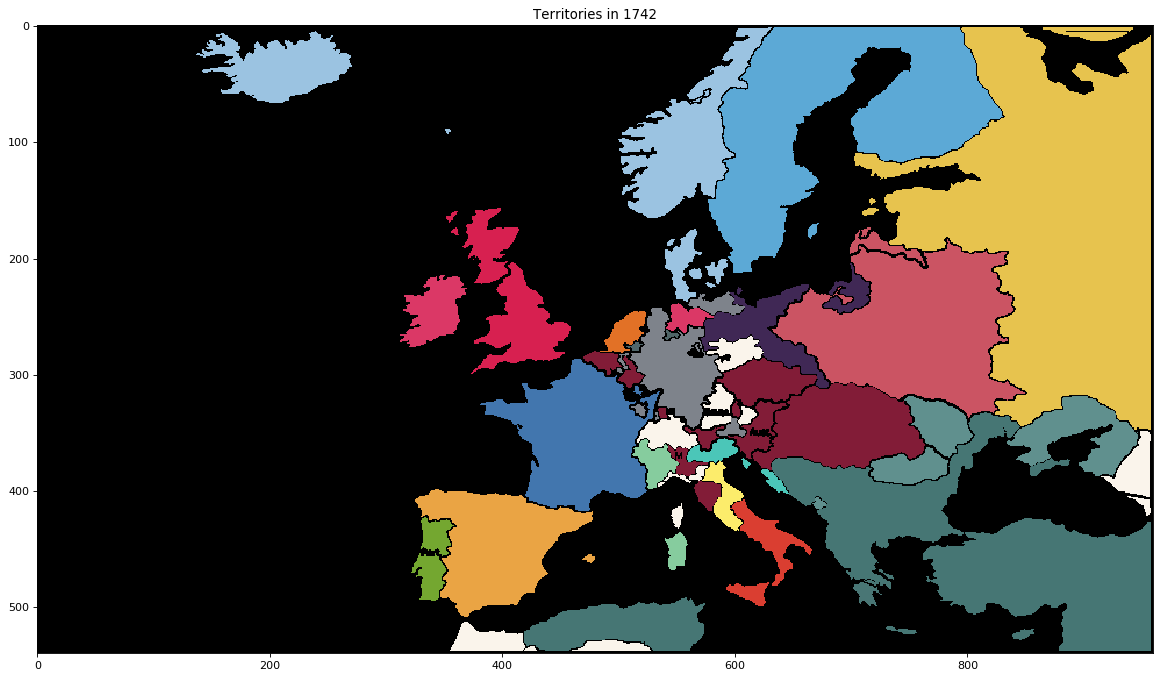

ignored 2 based on ignored_colors 


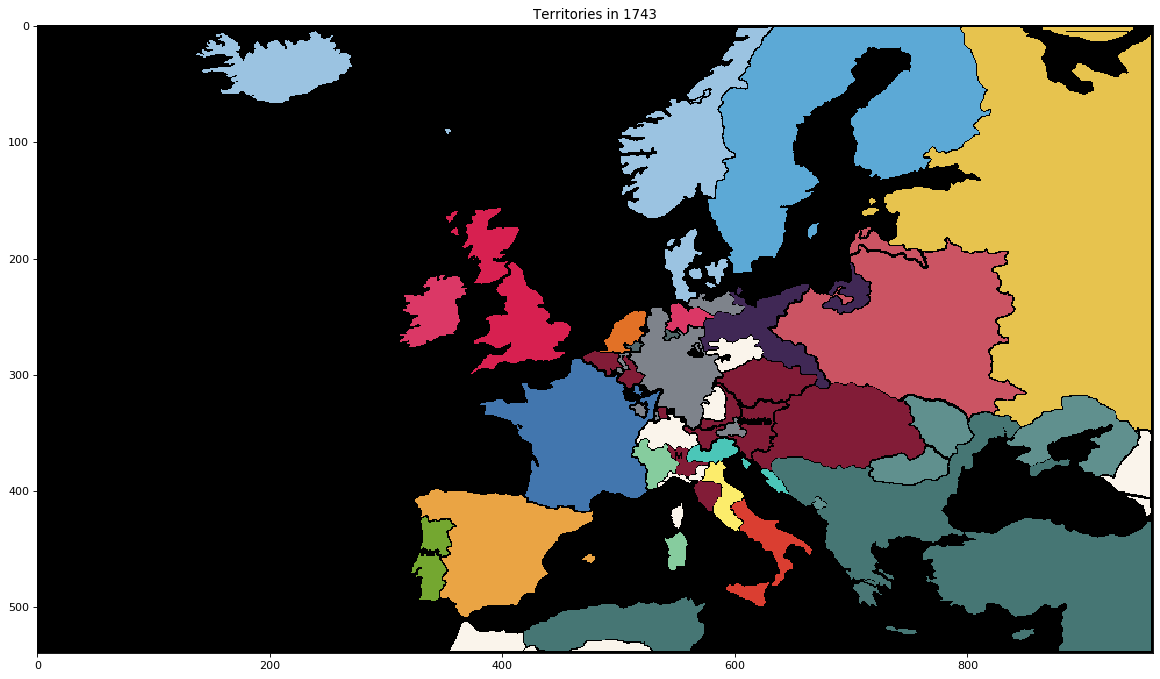

ignored 2 based on ignored_colors 


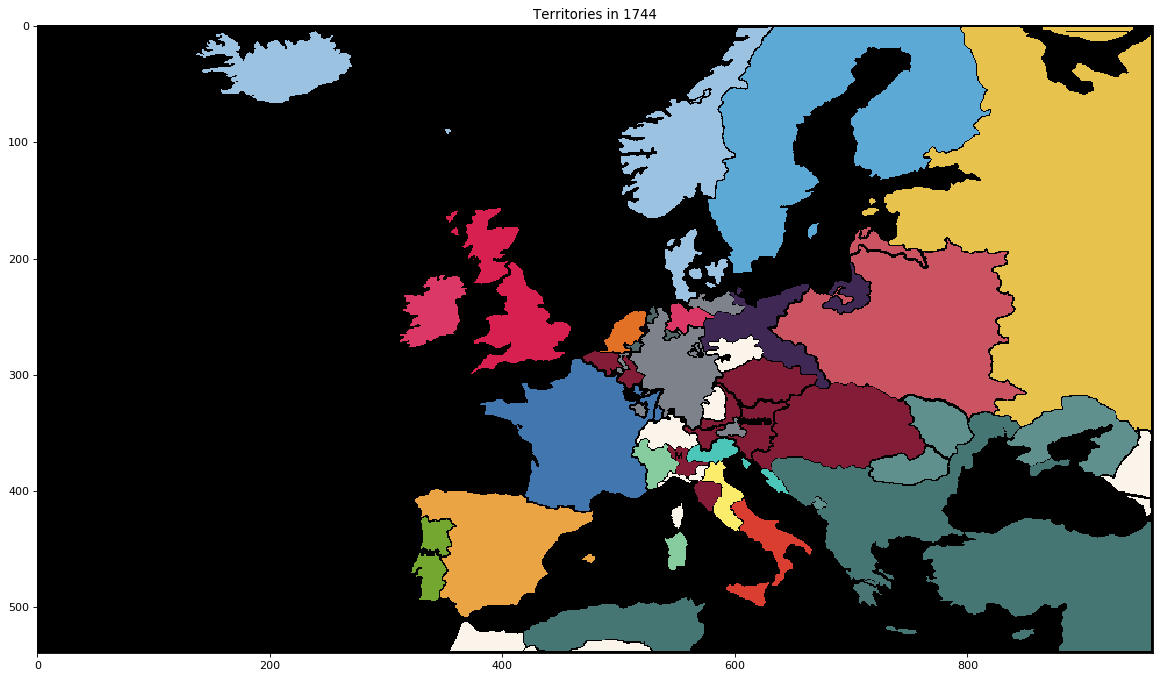

ignored 2 based on ignored_colors 


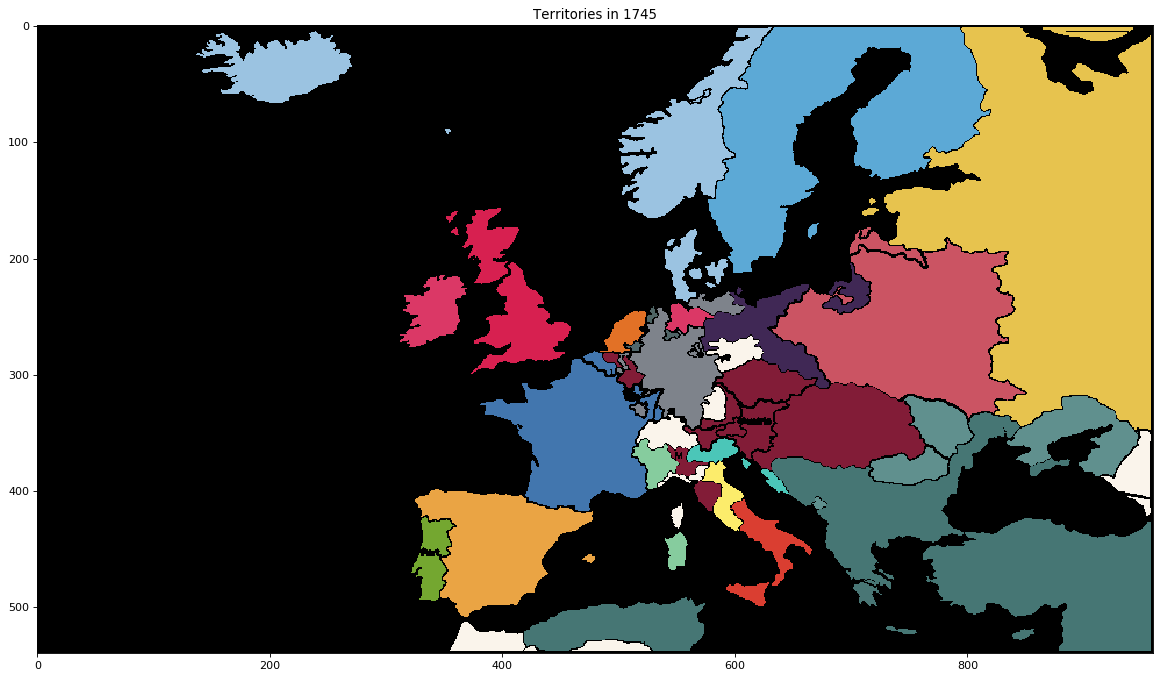

ignored 2 based on ignored_colors 


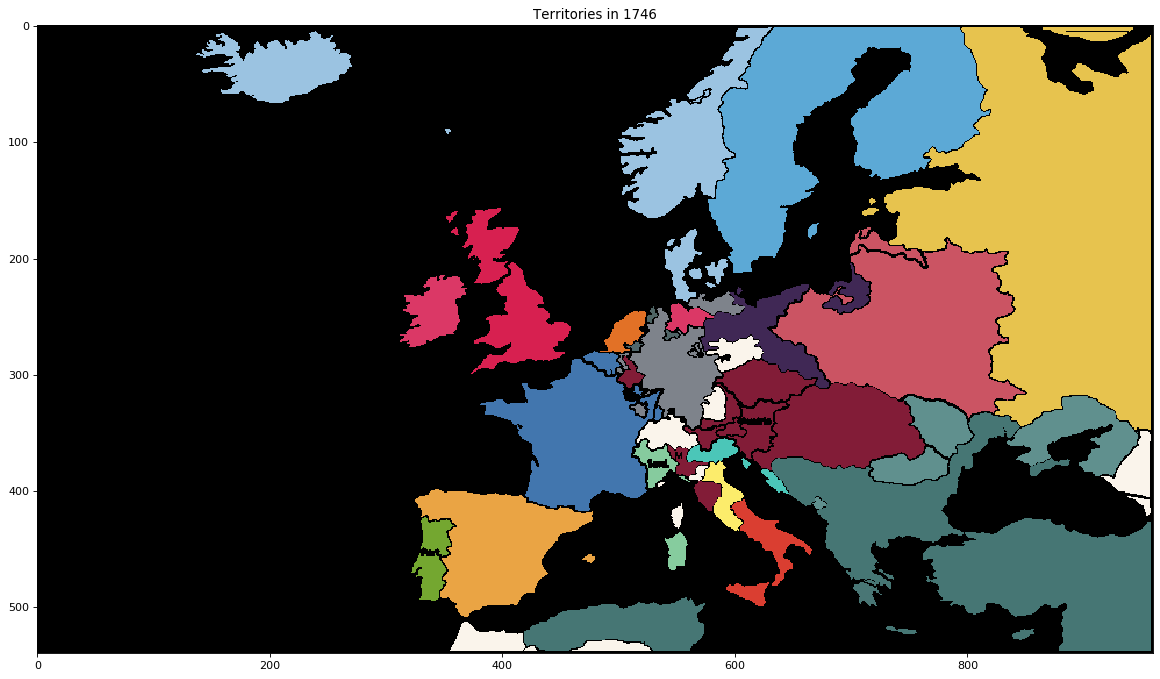

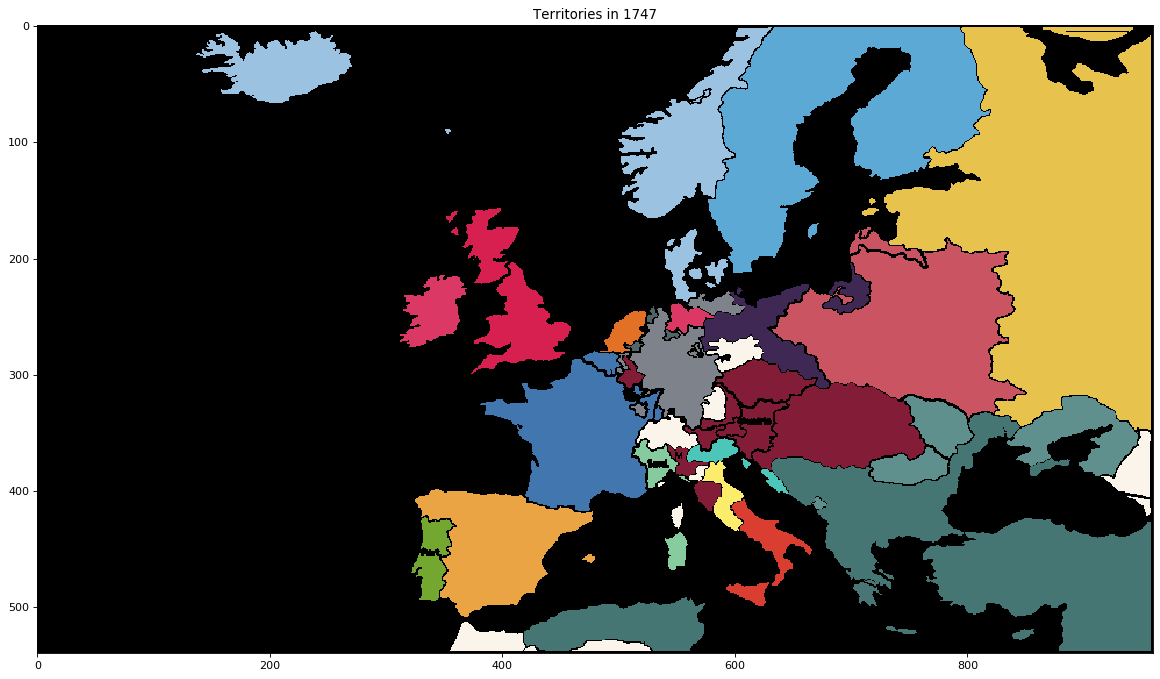

ignored 2 based on ignored_colors 


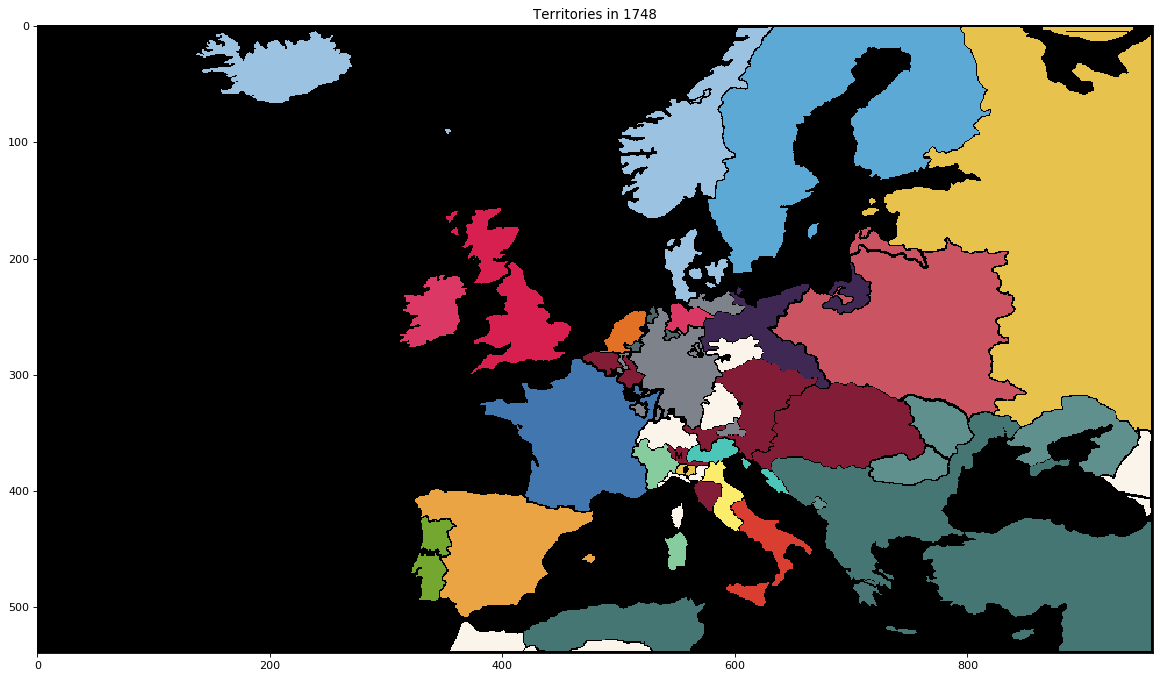

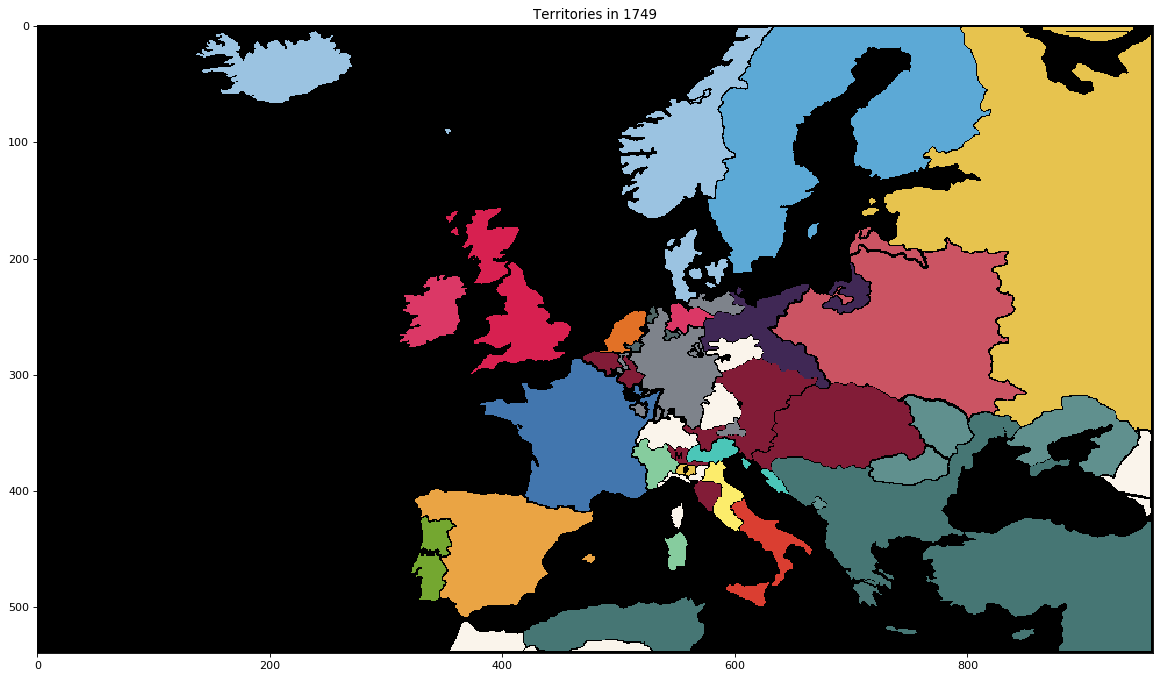

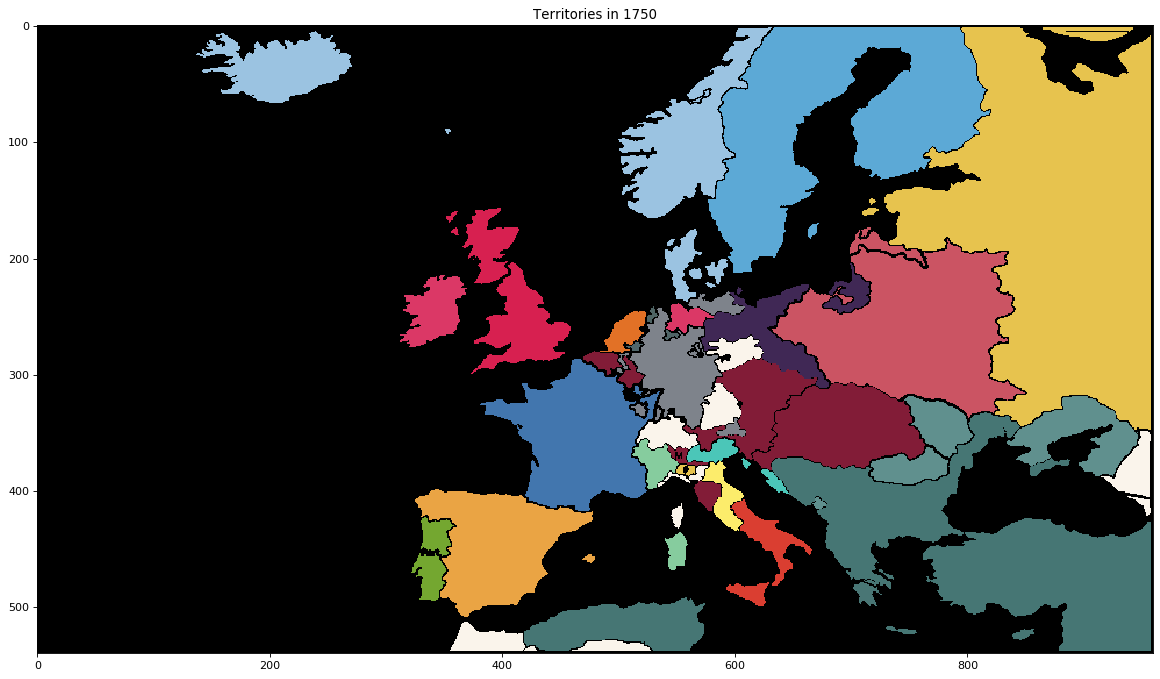

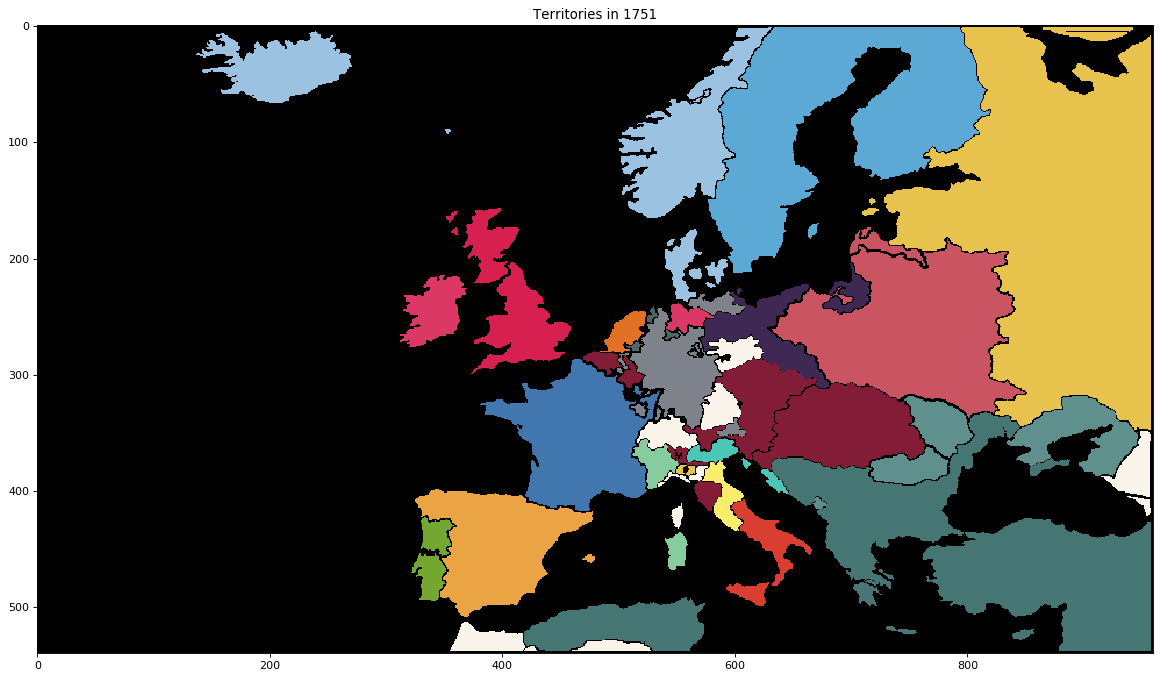

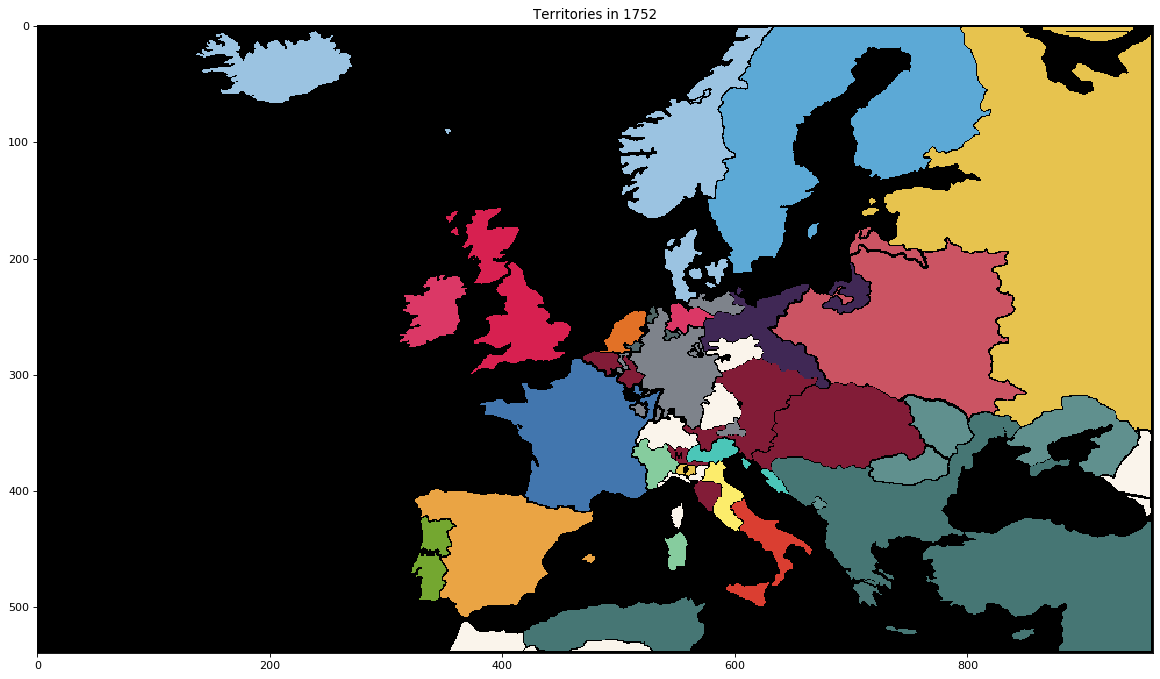

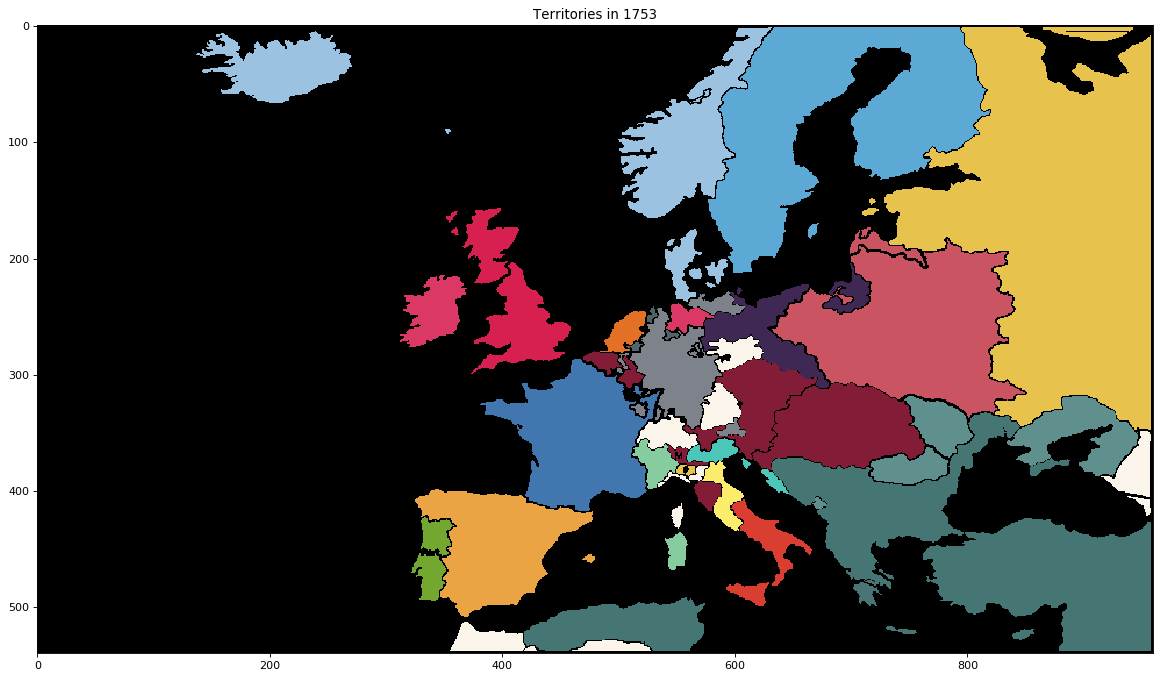

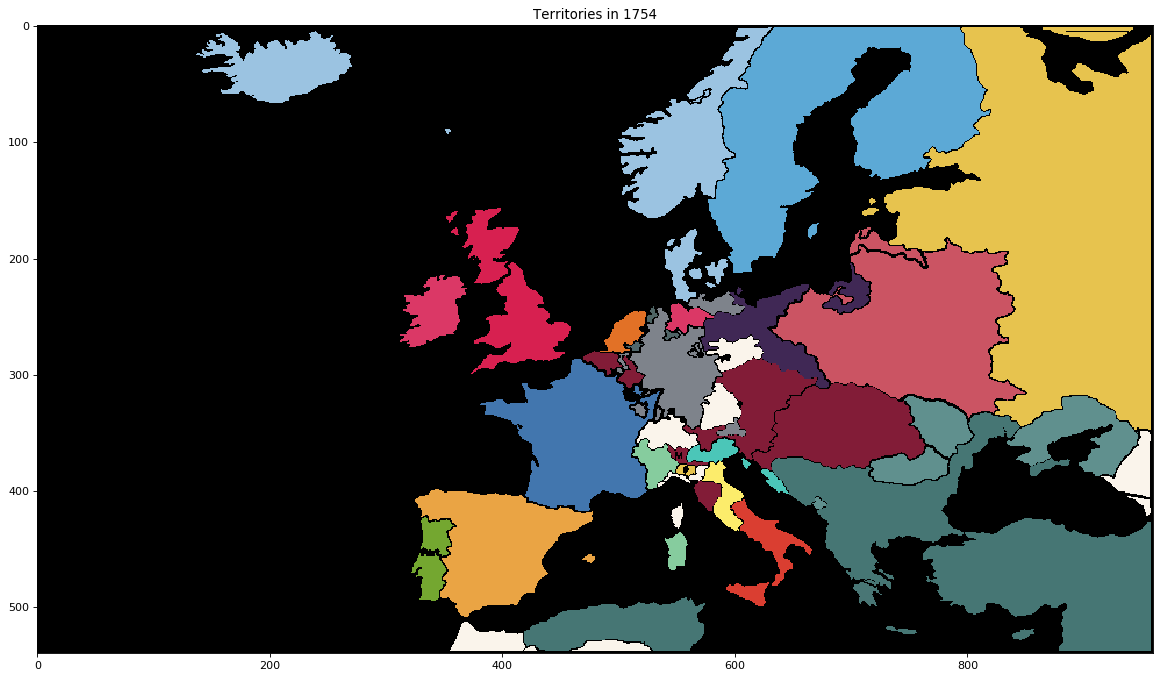

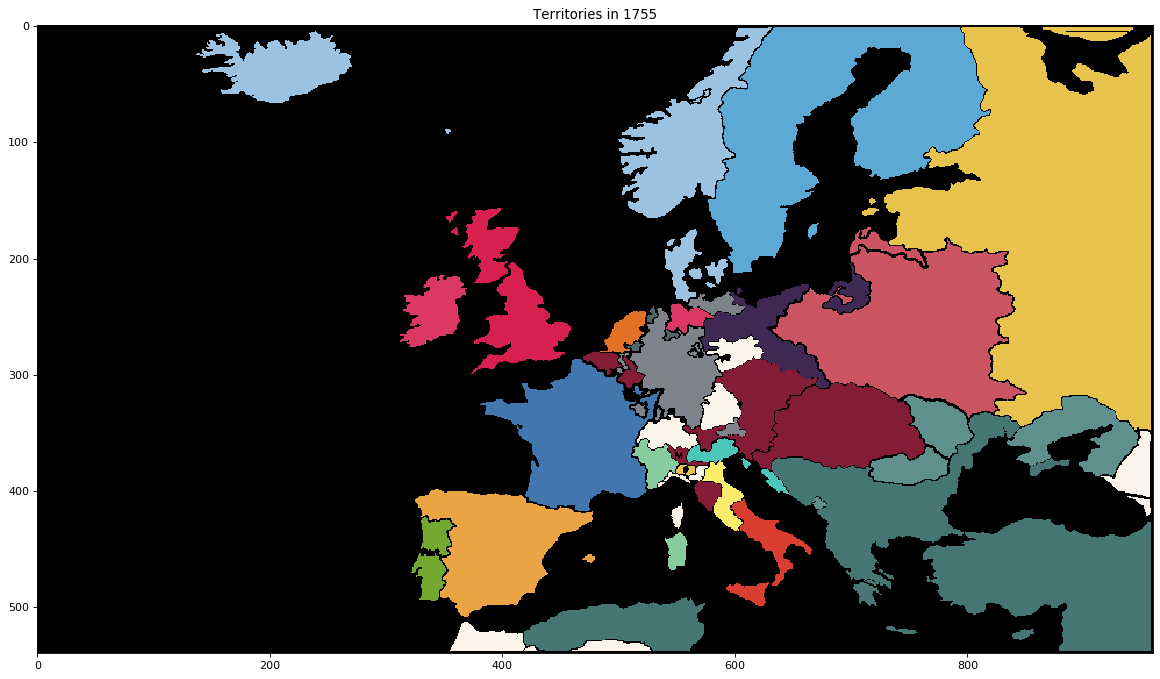

ignored 2 based on ignored_colors 


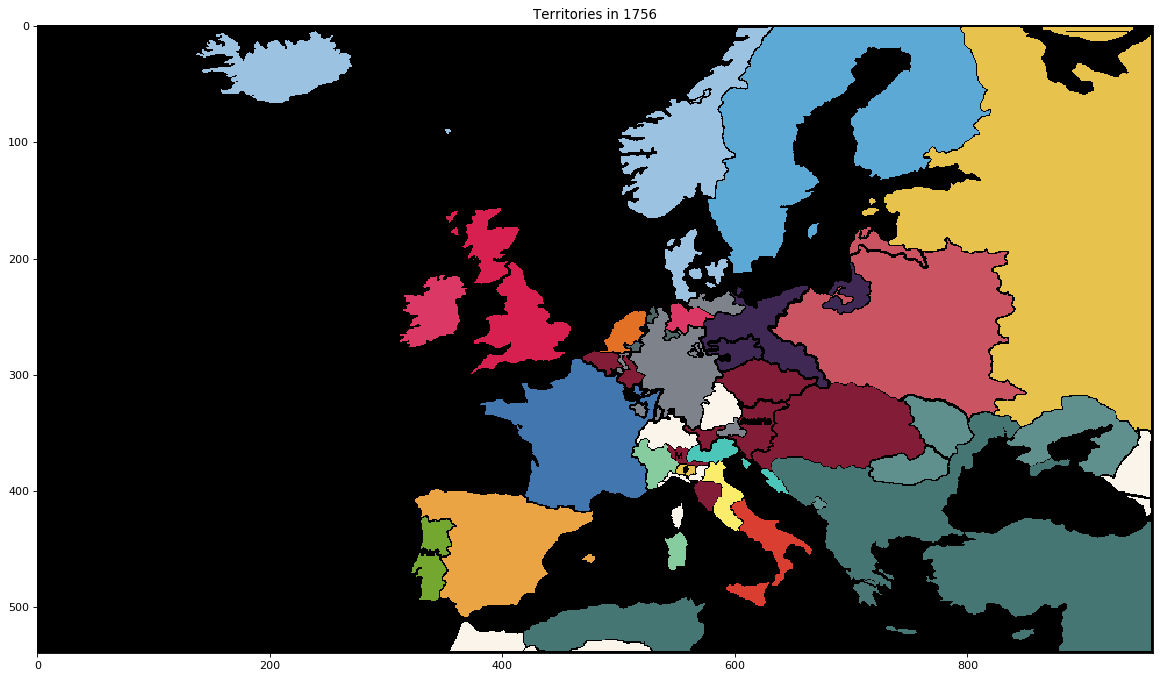

ignored 2 based on ignored_colors 


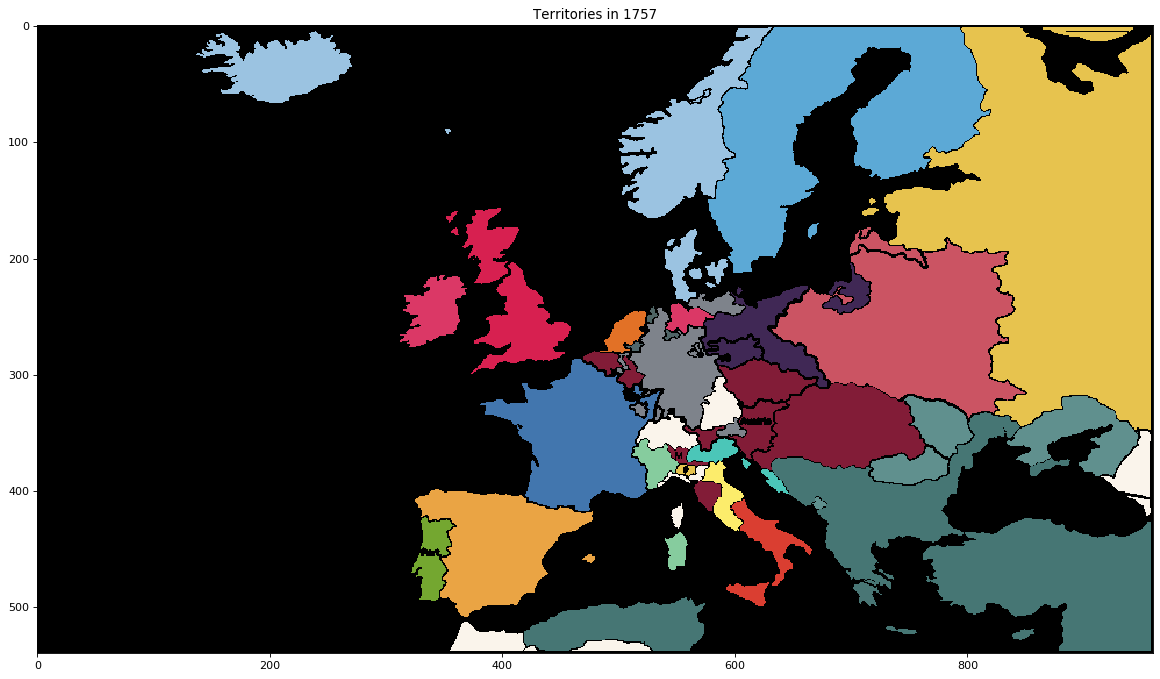

ignored 2 based on ignored_colors 


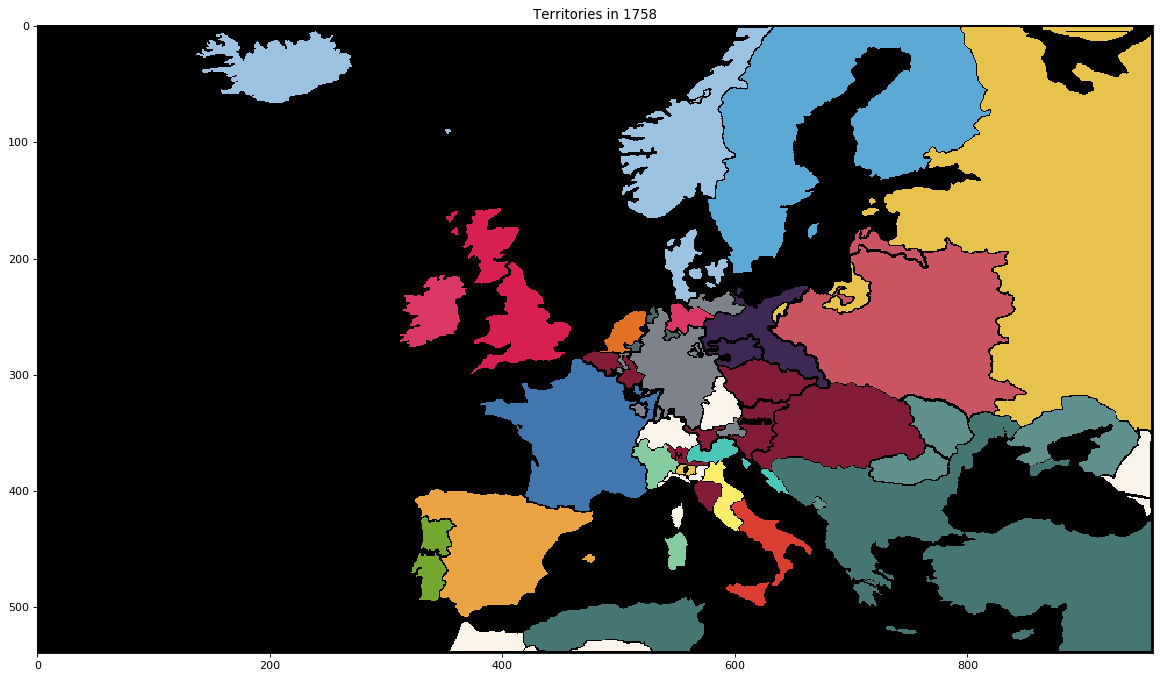

ignored 2 based on ignored_colors 


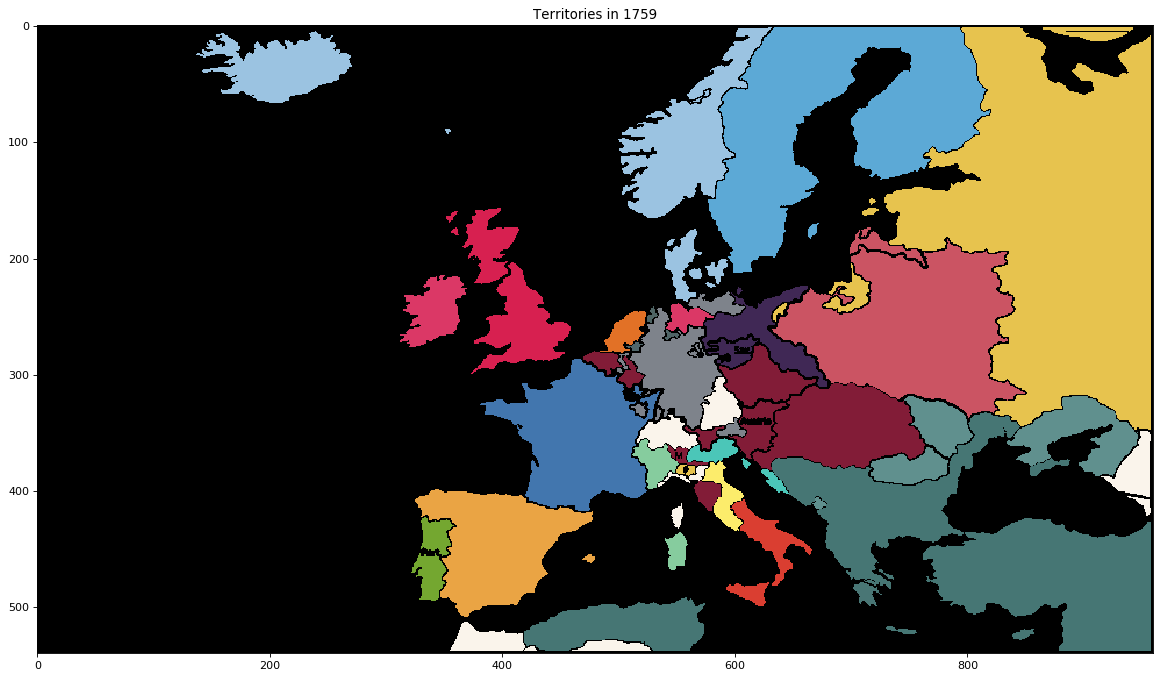

ignored 2 based on ignored_colors 


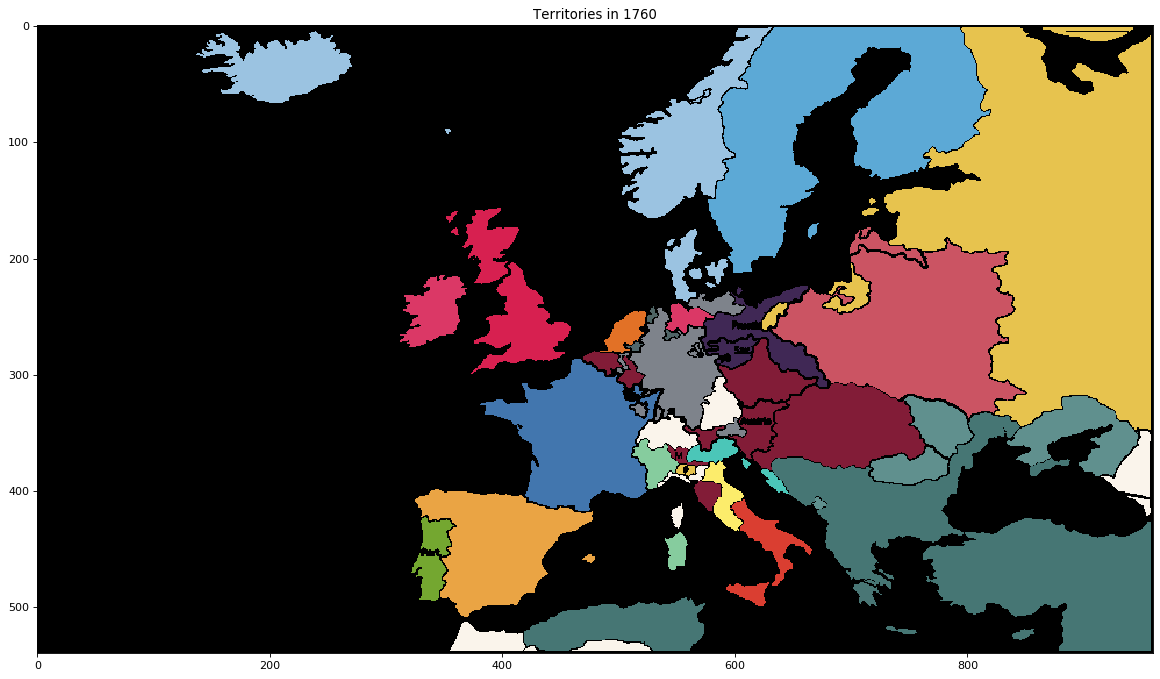

ignored 2 based on ignored_colors 


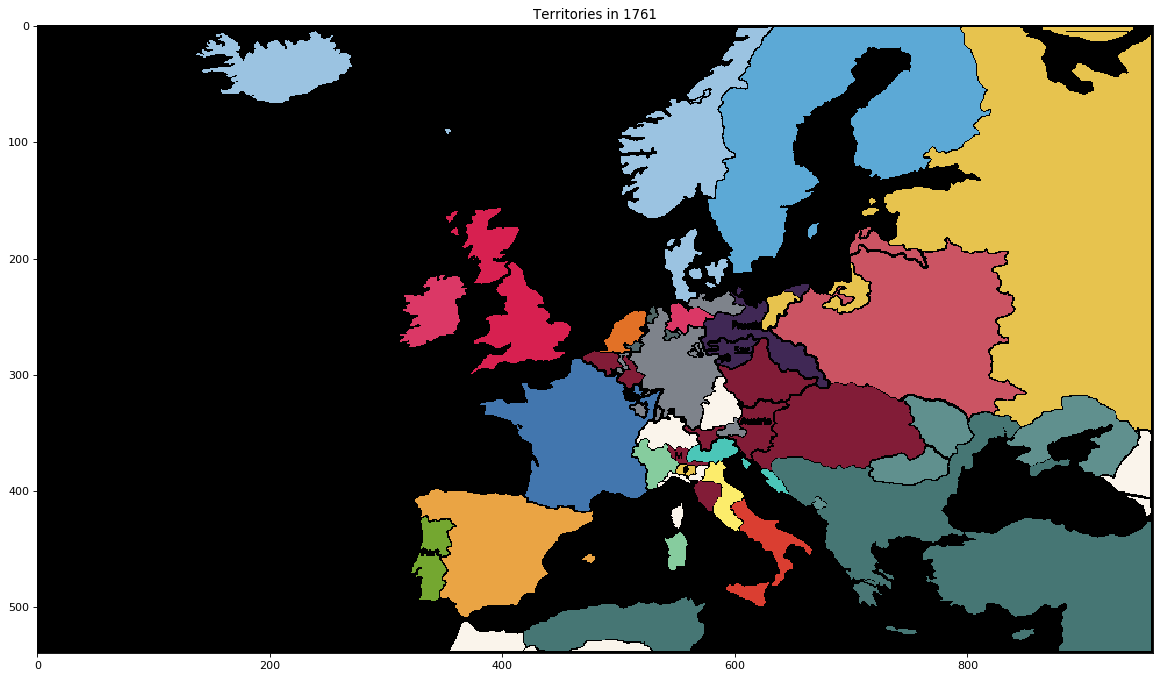

ignored 2 based on ignored_colors 


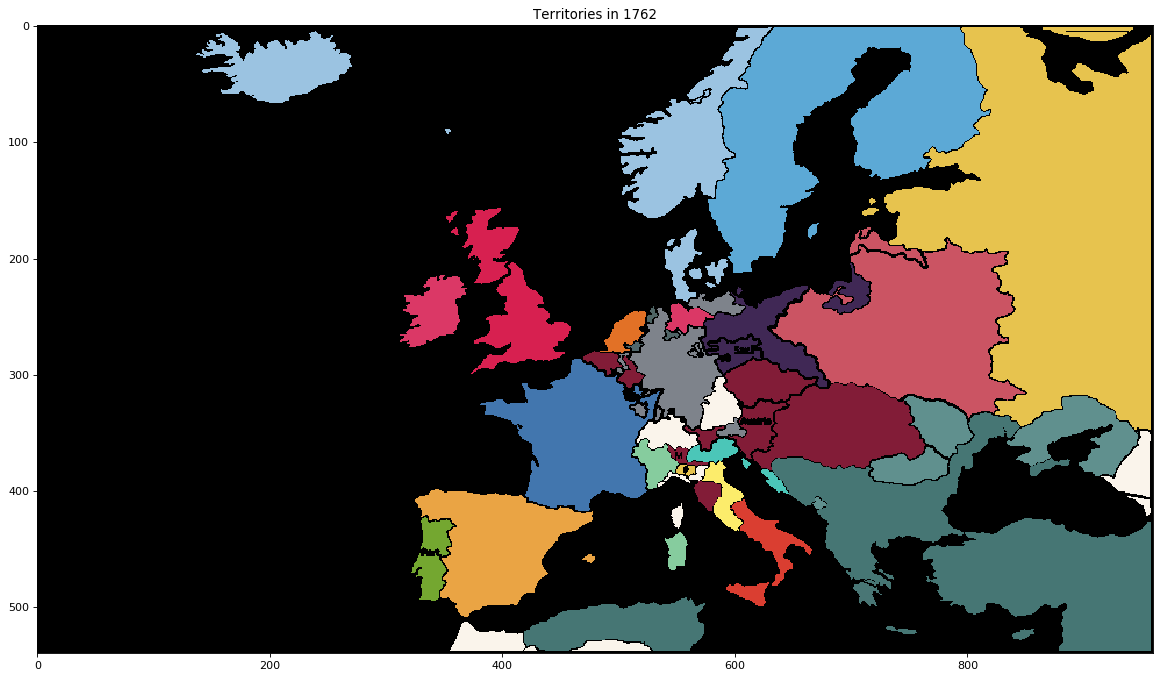

ignored 2 based on ignored_colors 


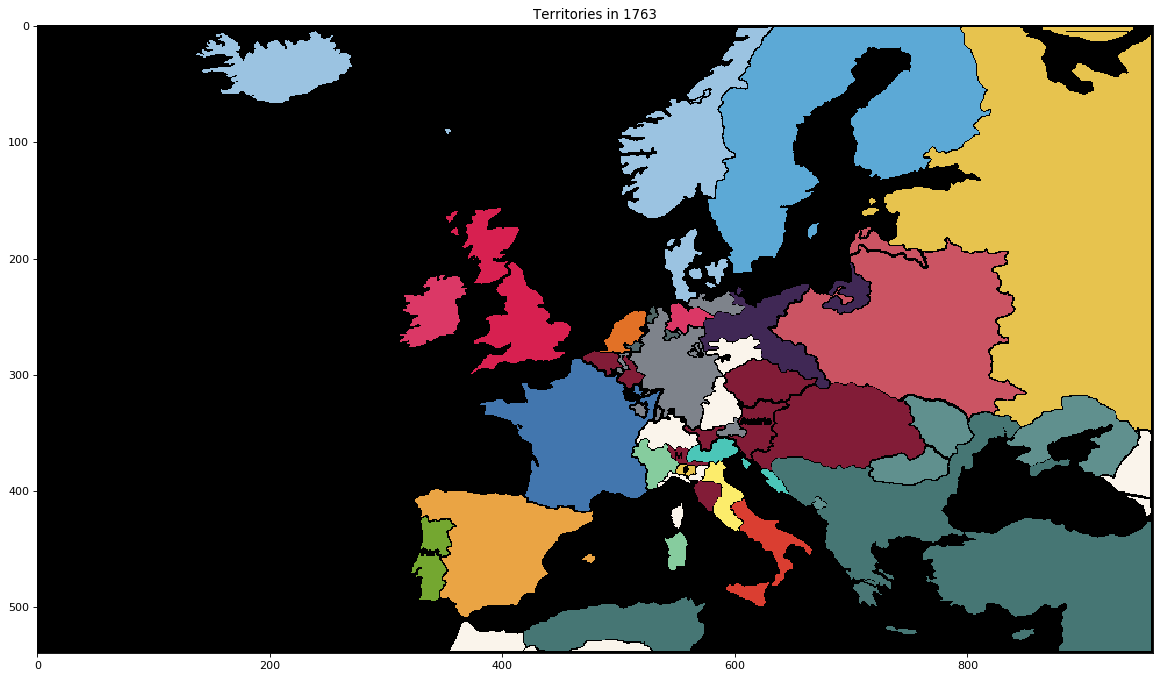

ignored 2 based on ignored_colors 


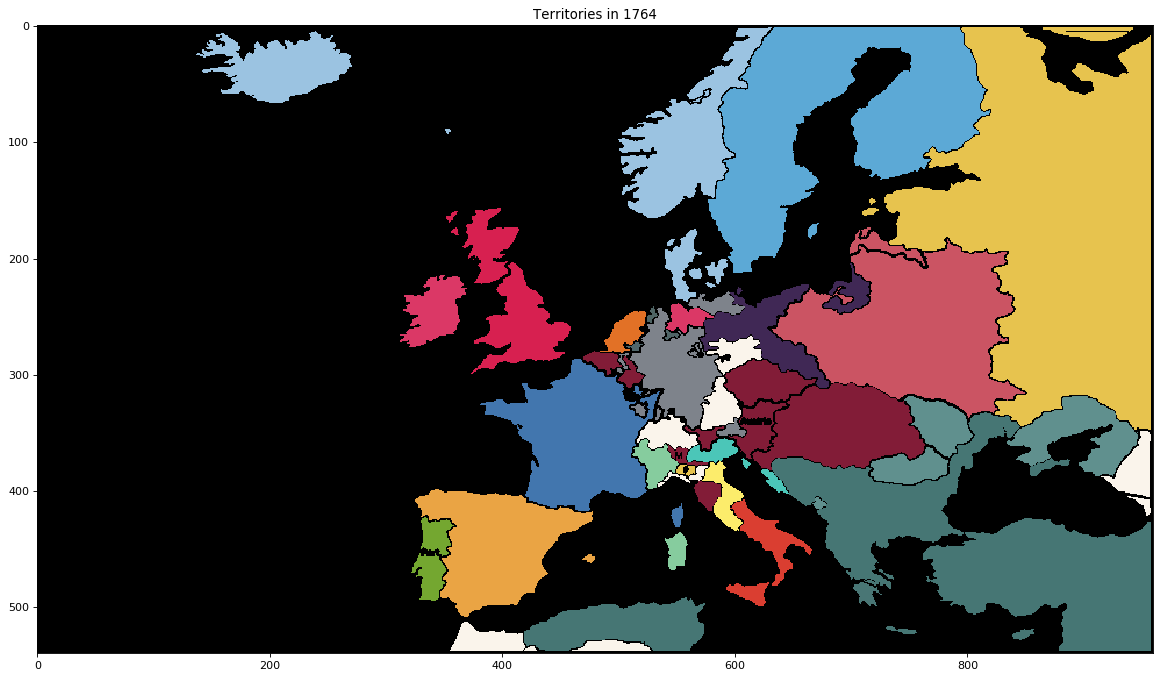

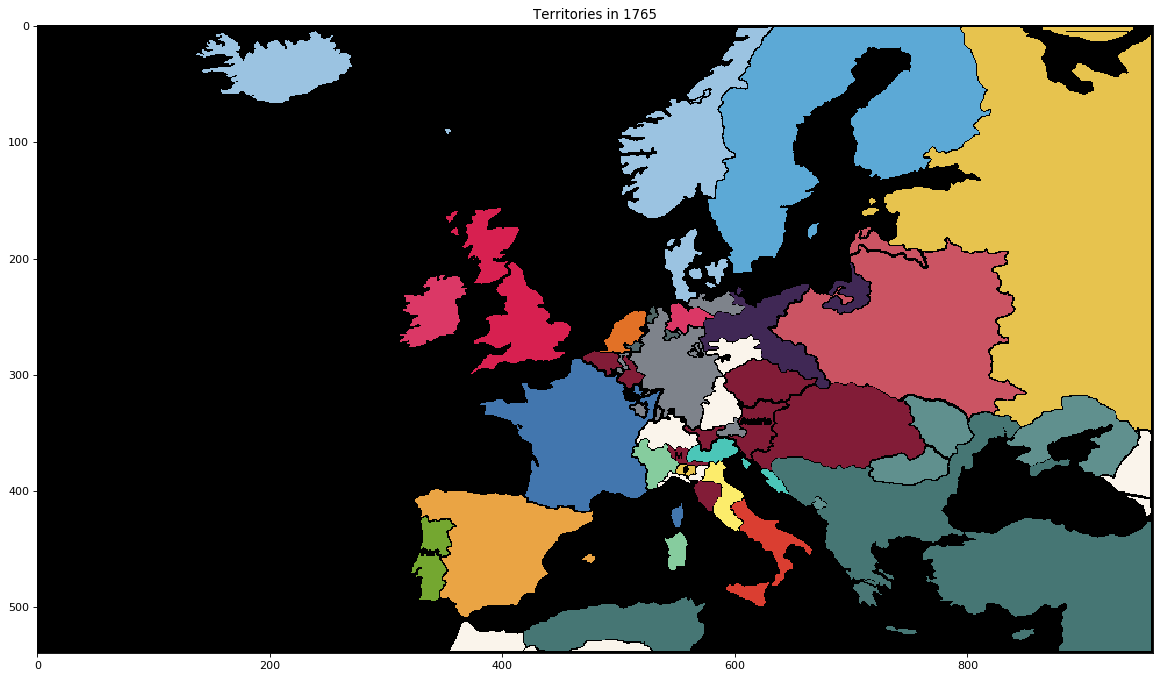

ignored 2 based on ignored_colors 


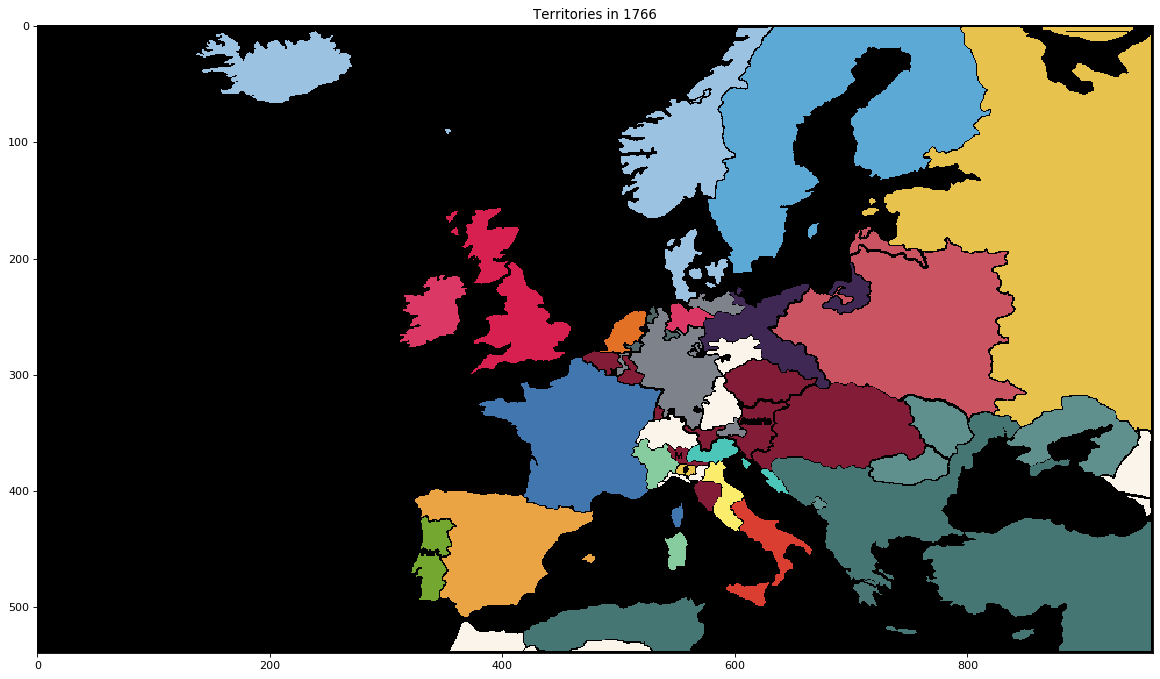

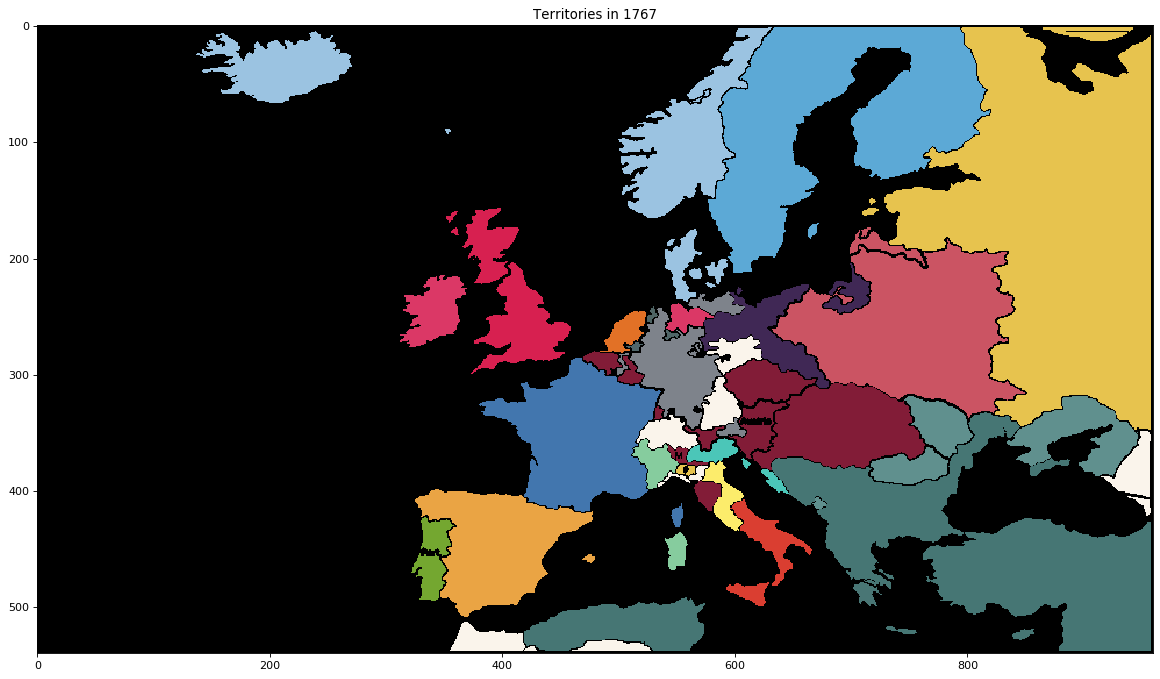

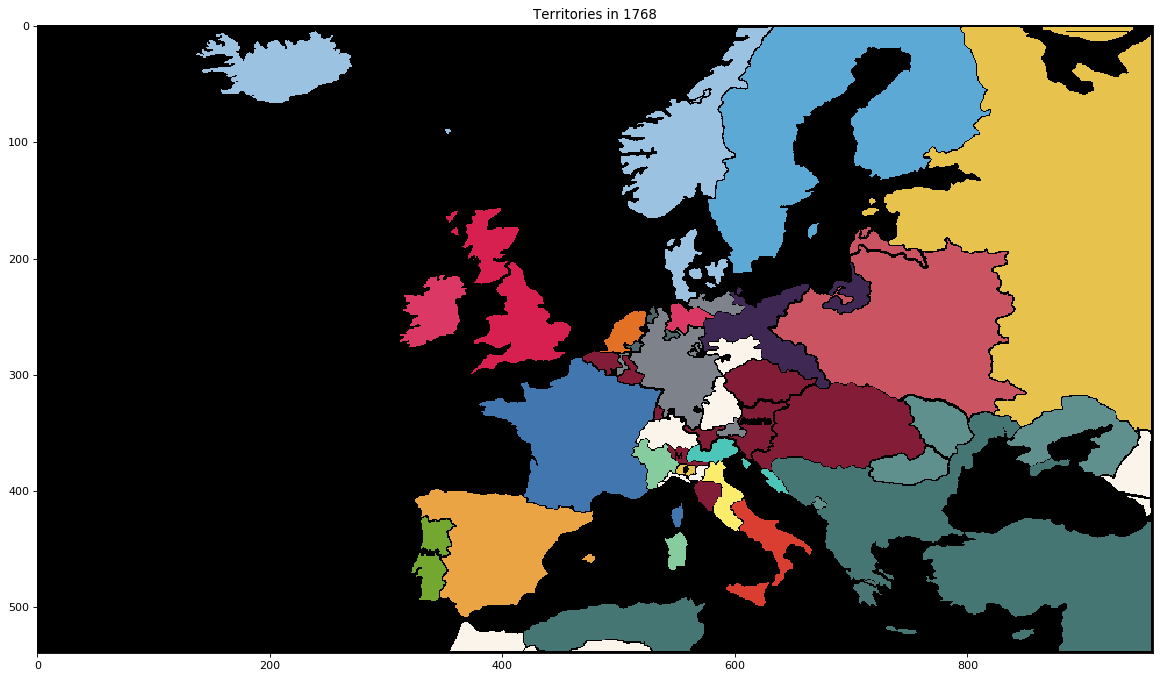

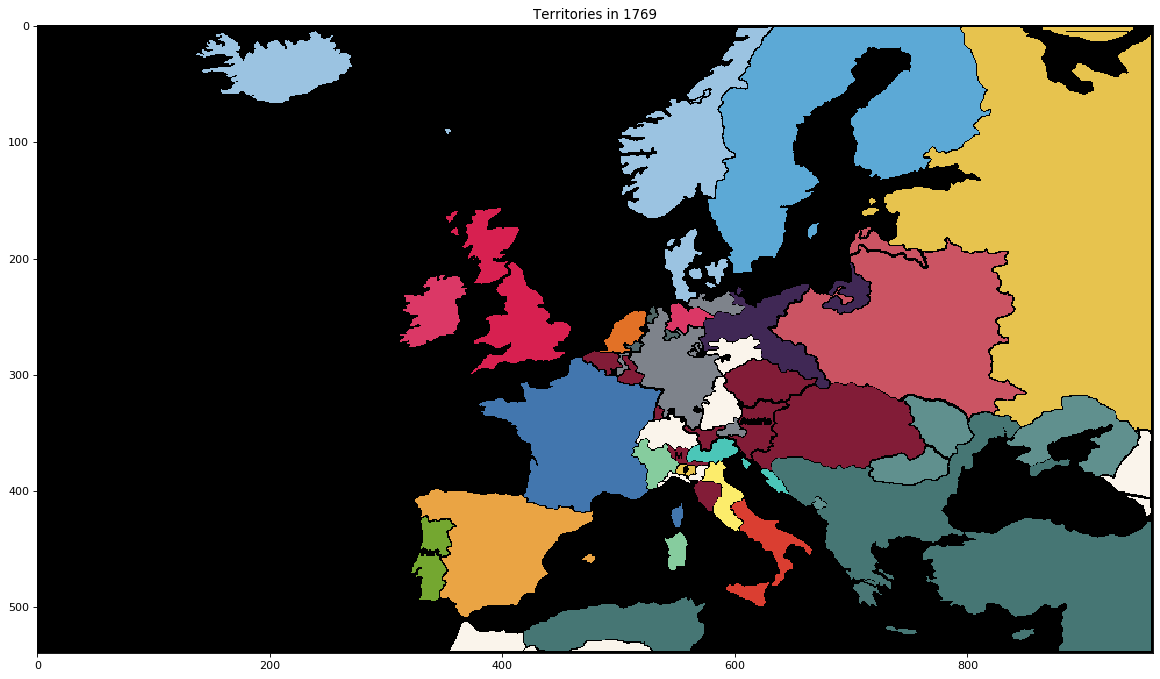

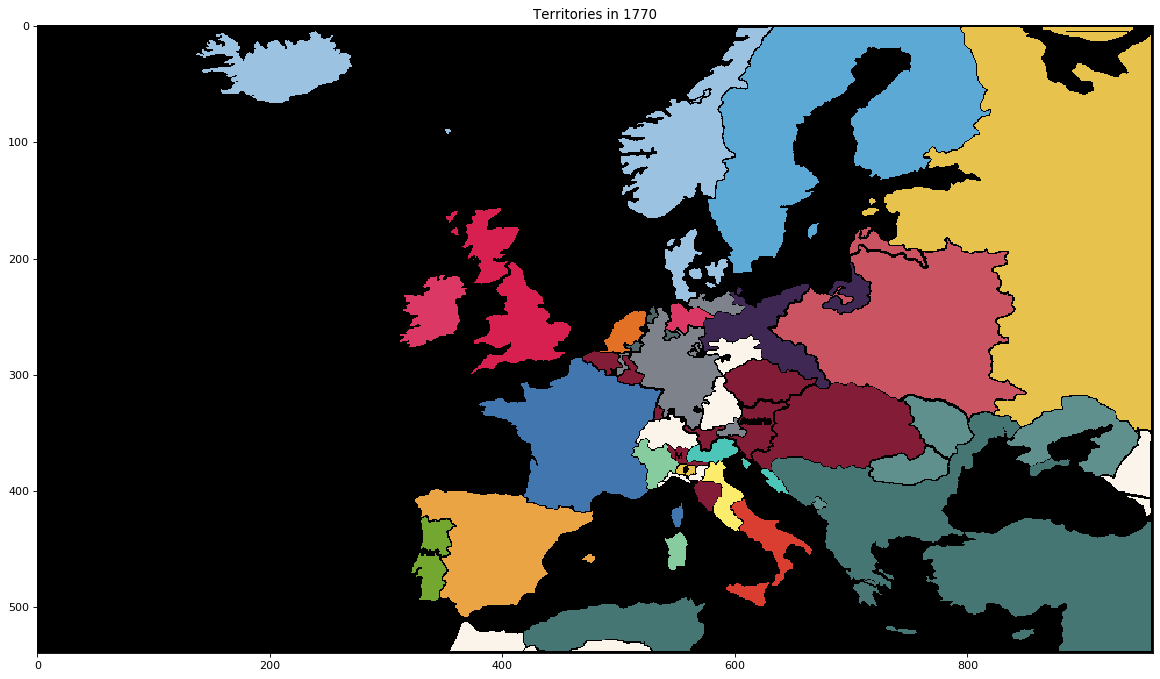

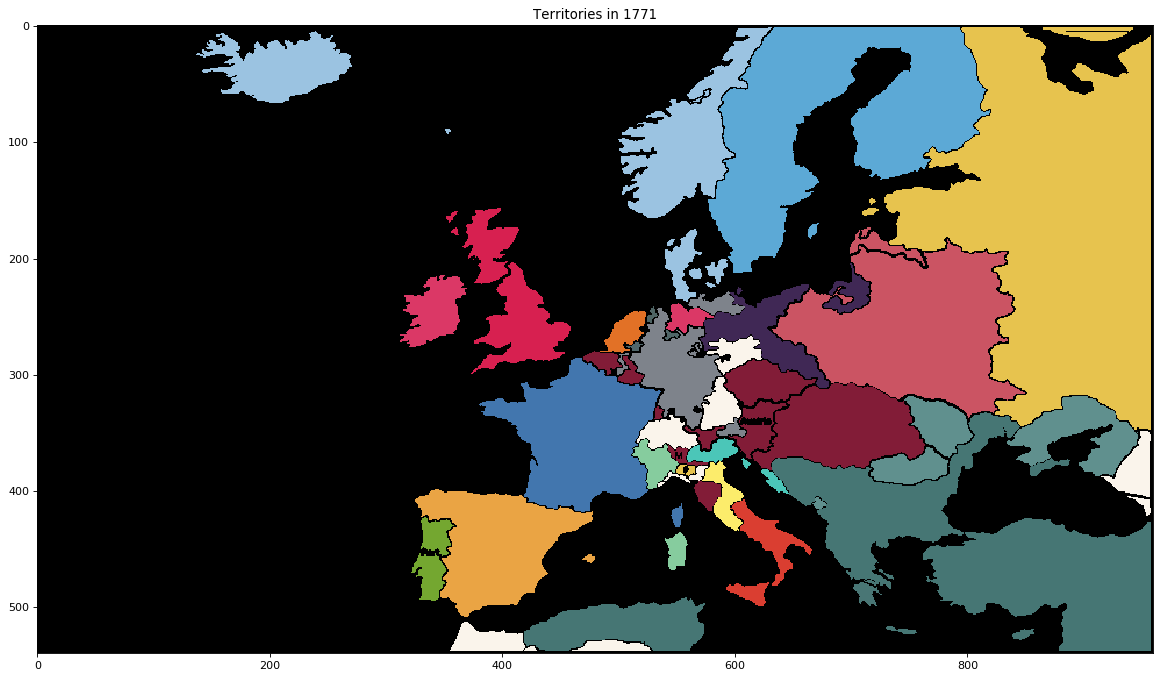

ignored 2 based on ignored_colors 


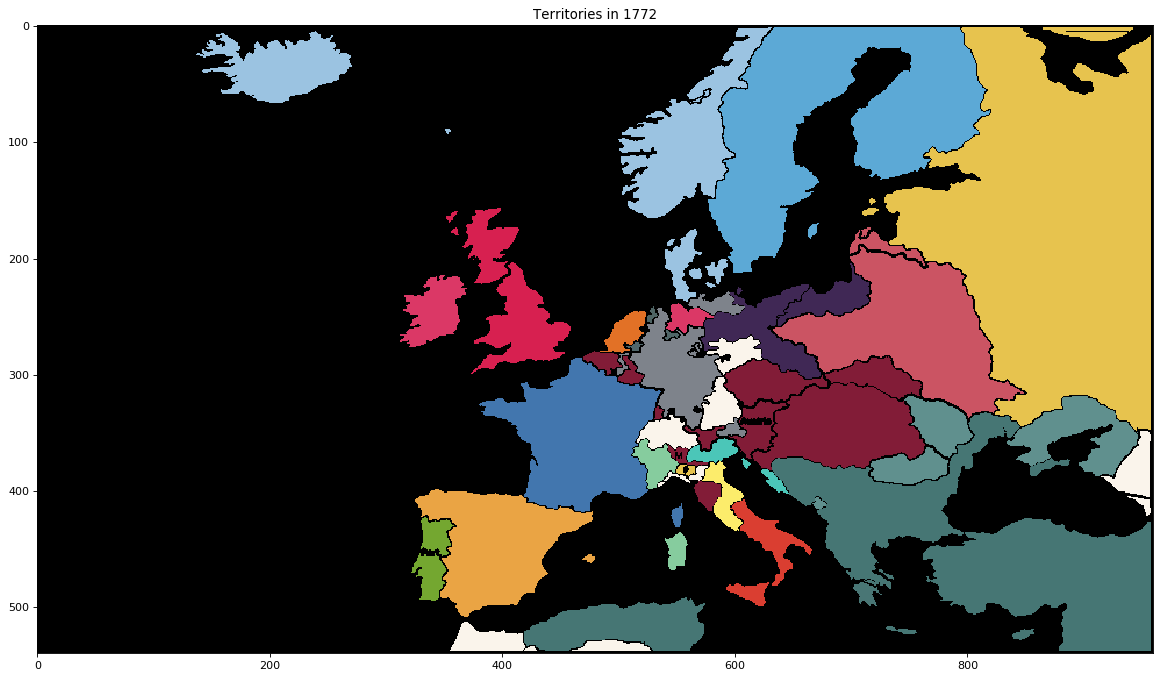

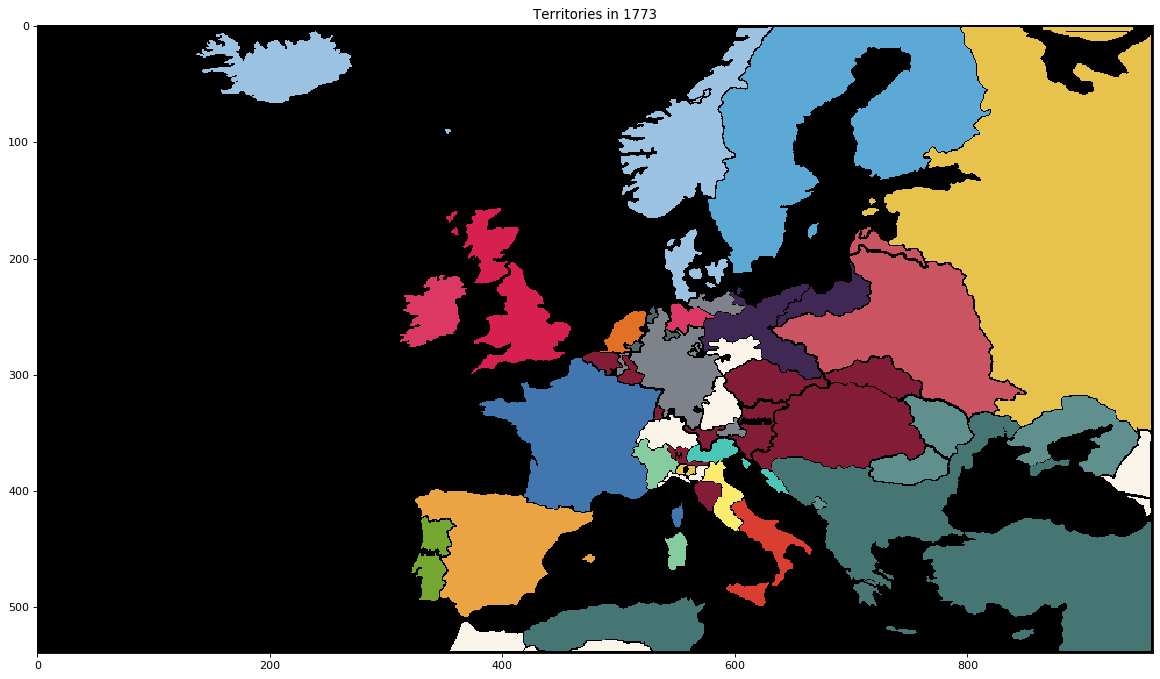

ignored 2 based on ignored_colors 


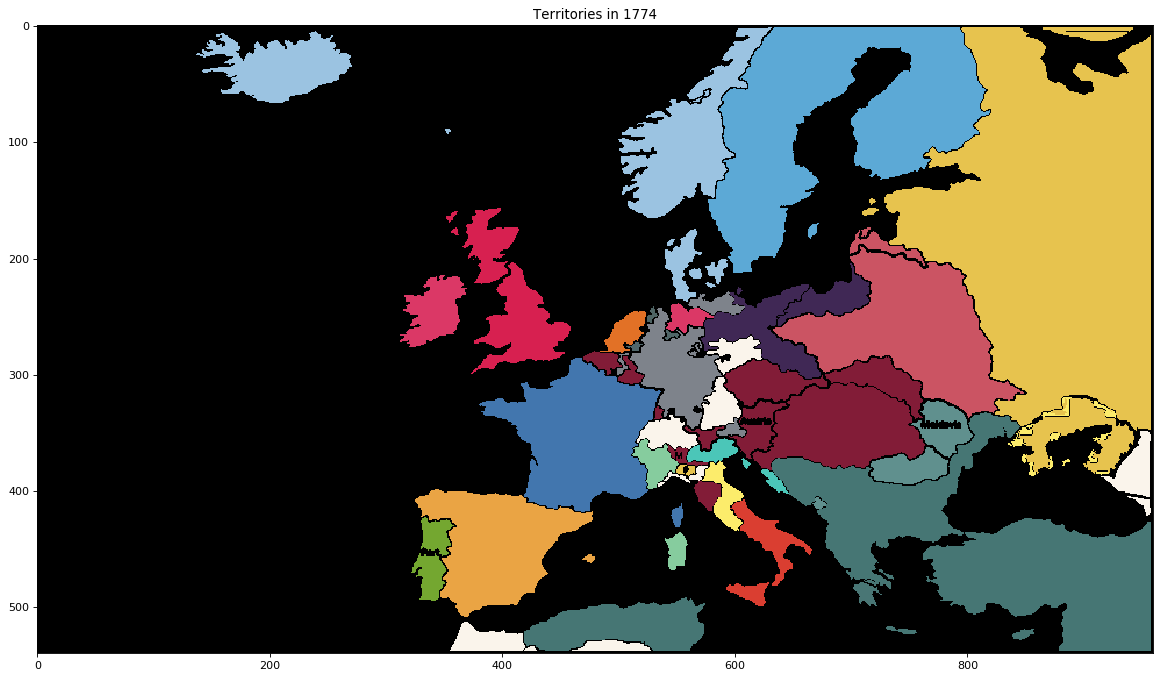

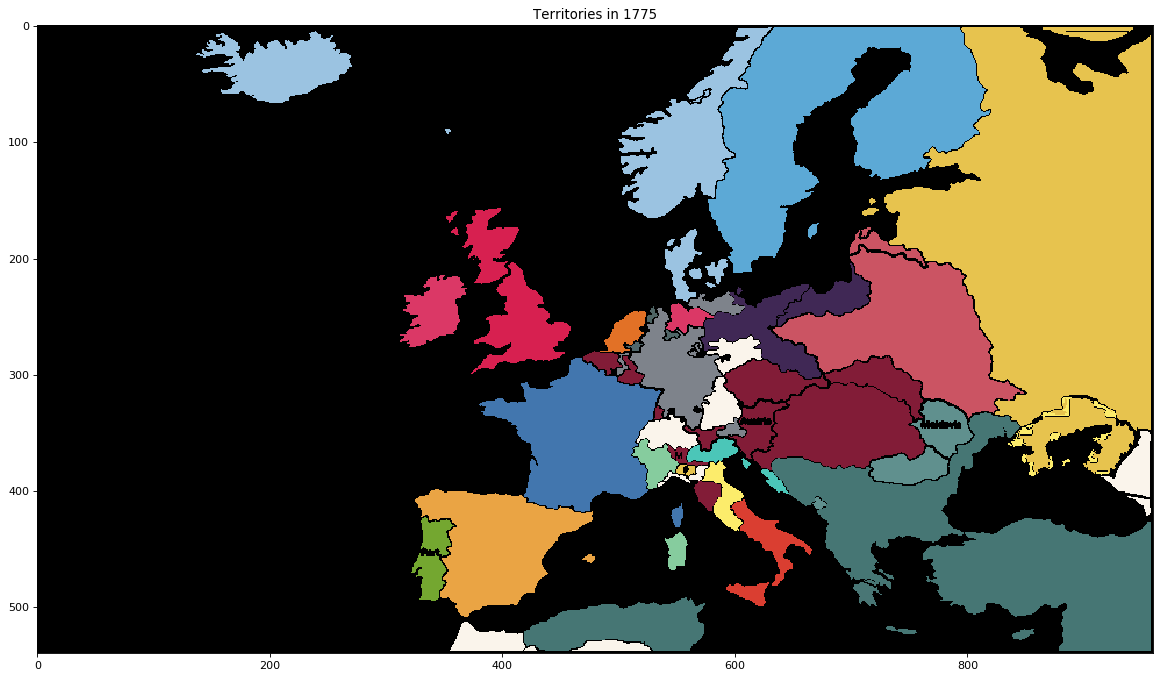

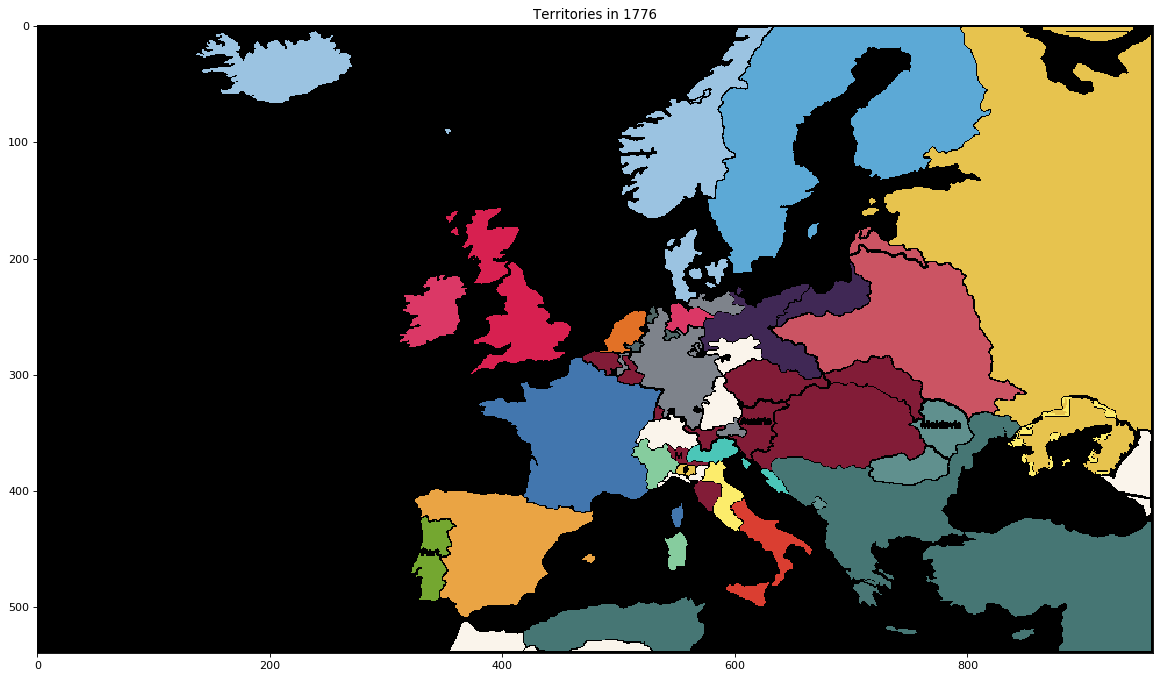

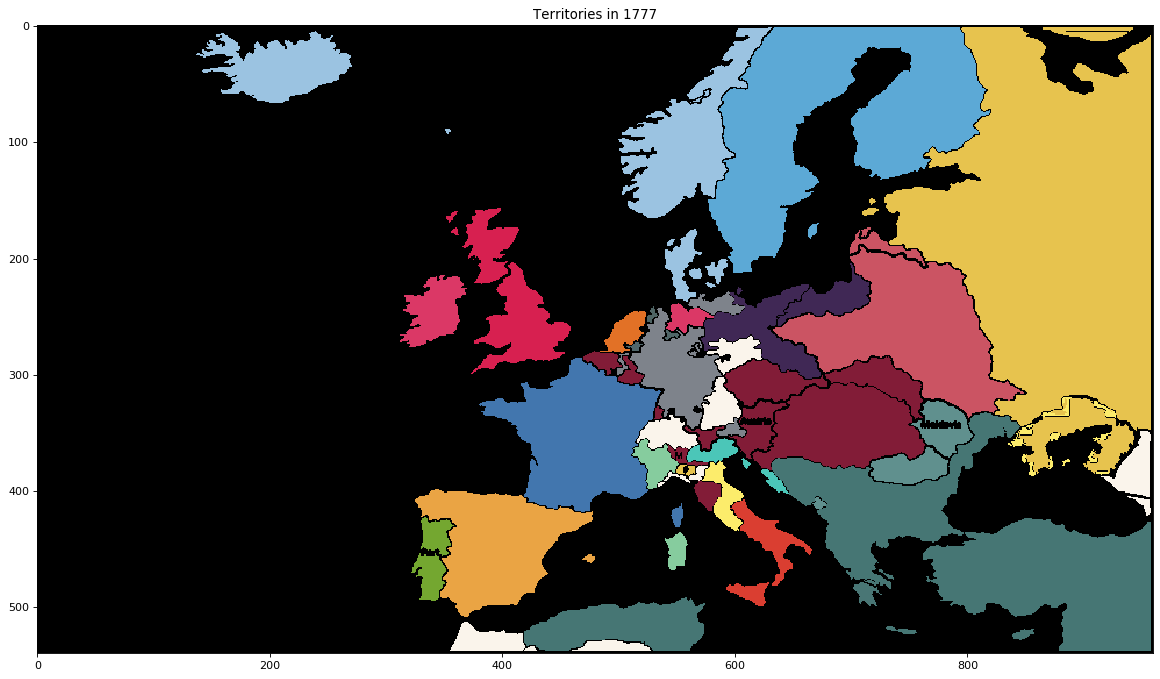

ignored 2 based on ignored_colors 


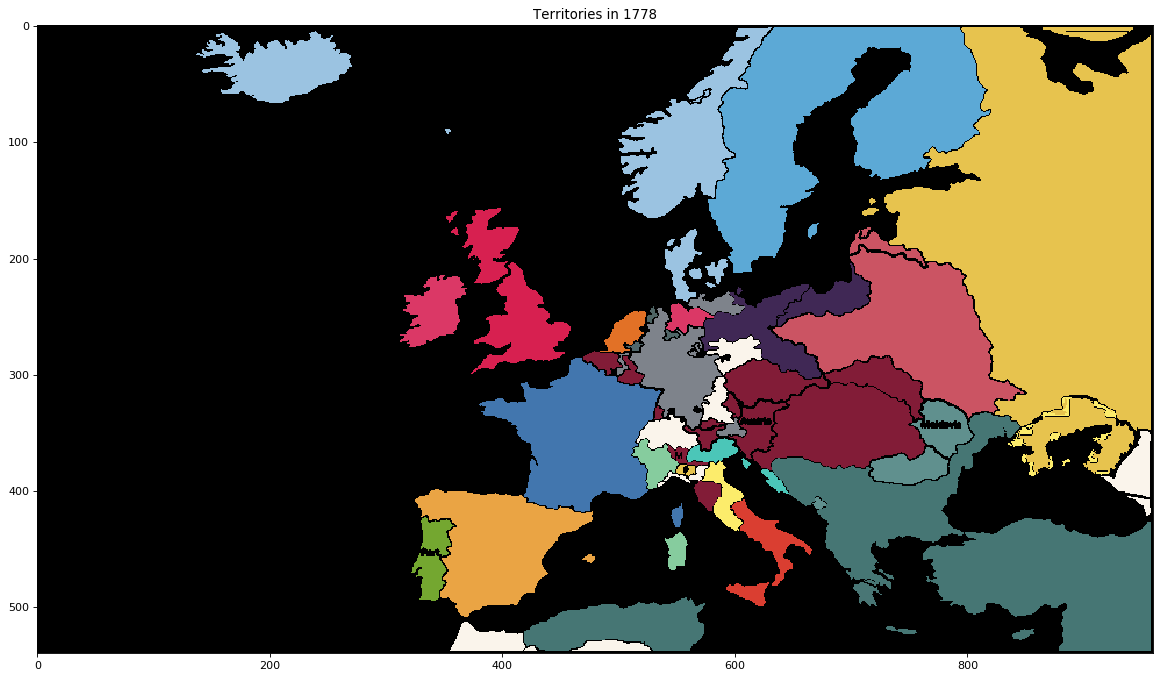

ignored 2 based on ignored_colors 


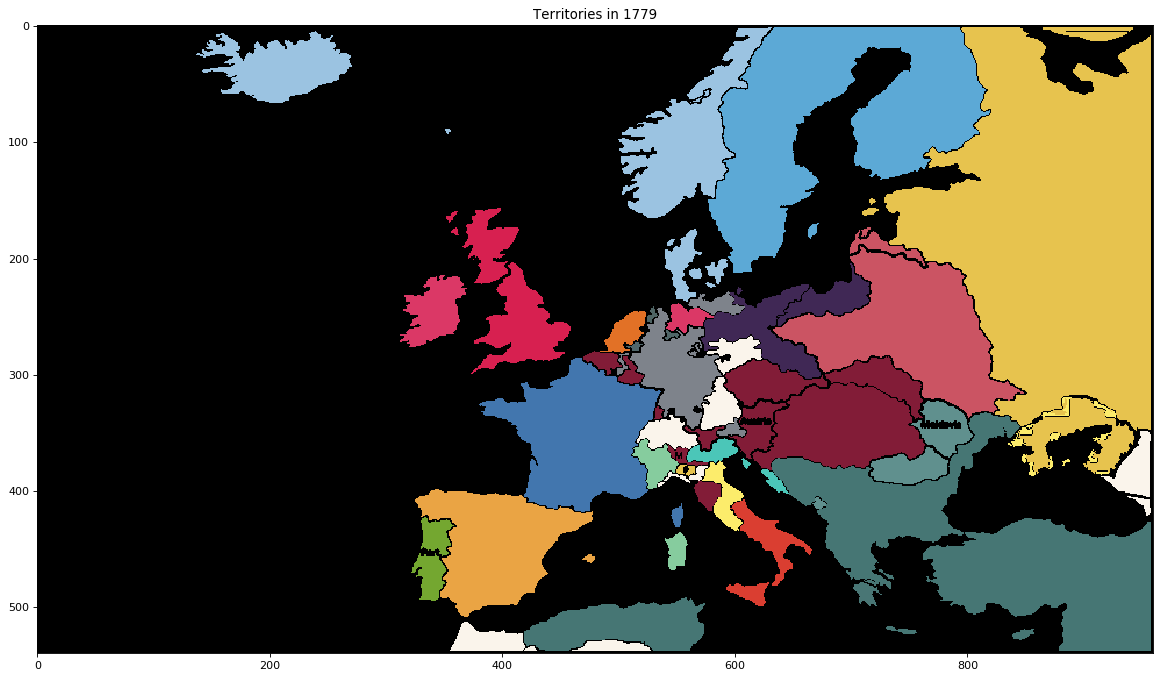

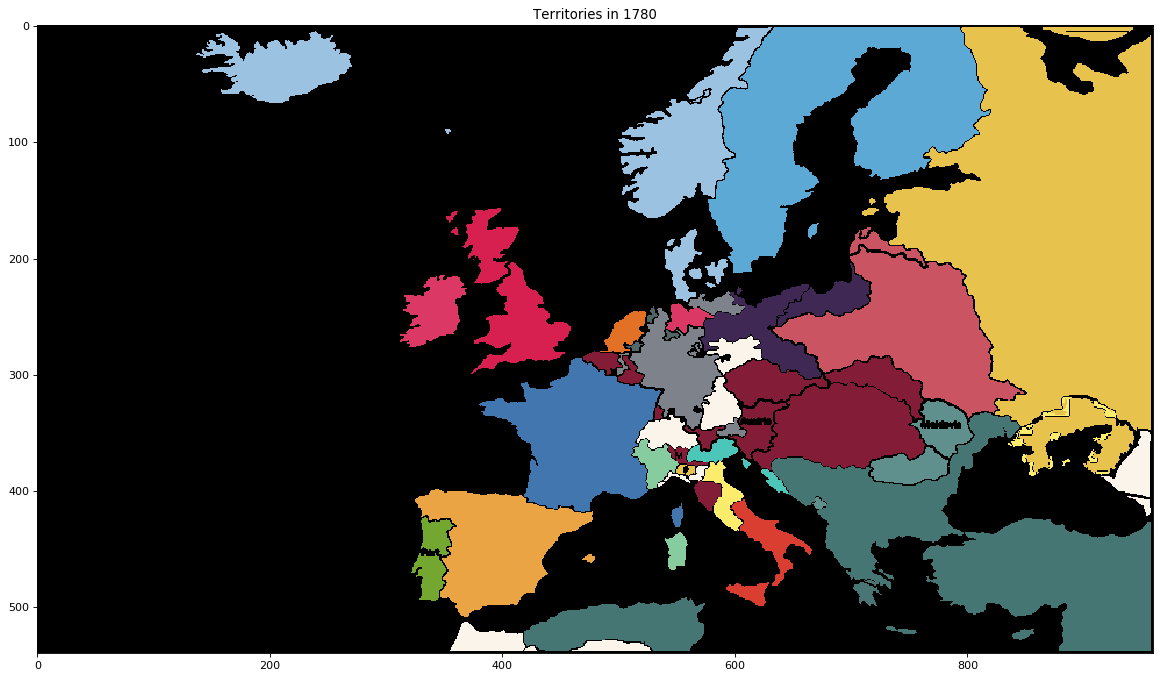

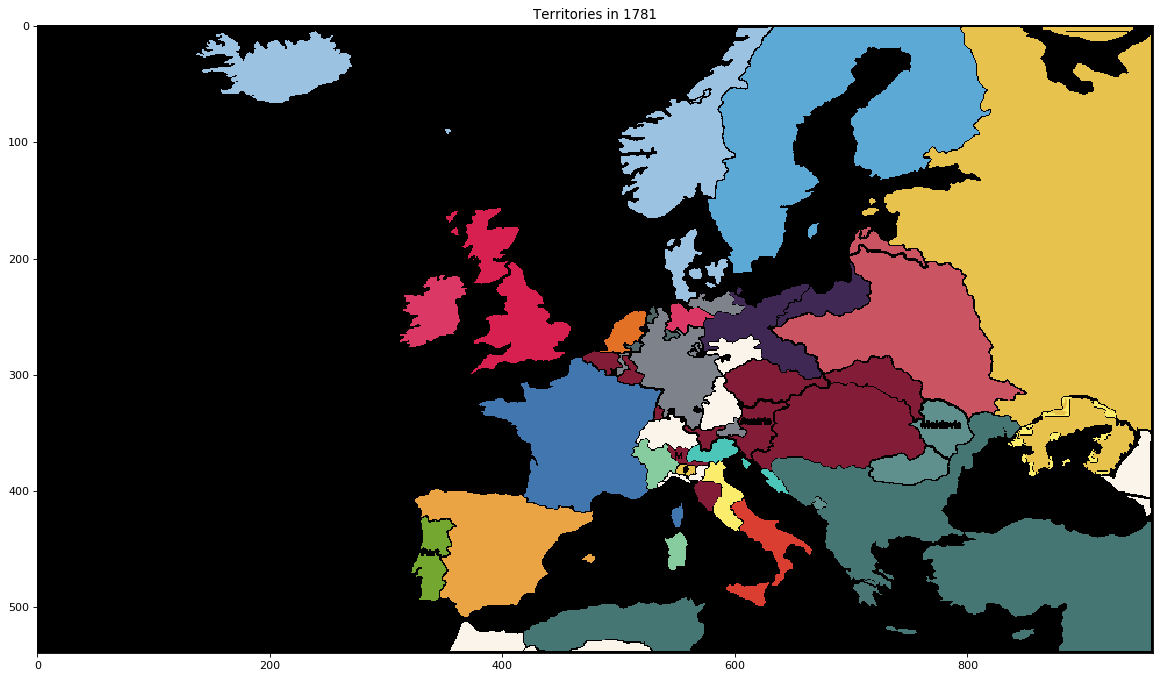

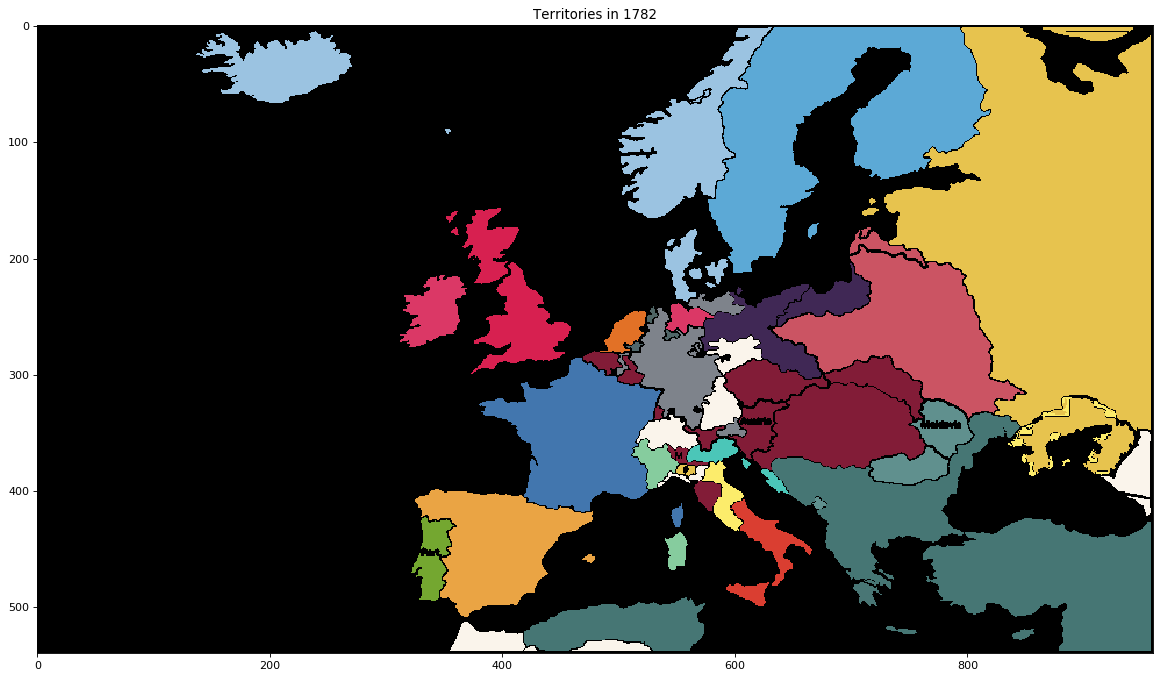

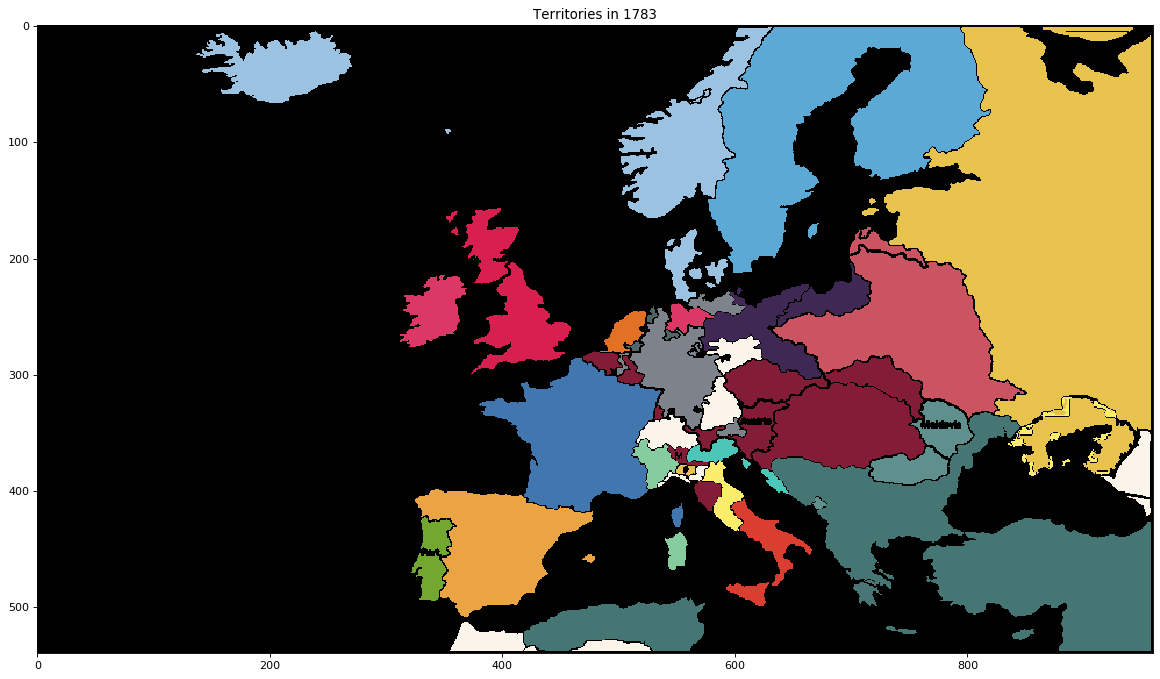

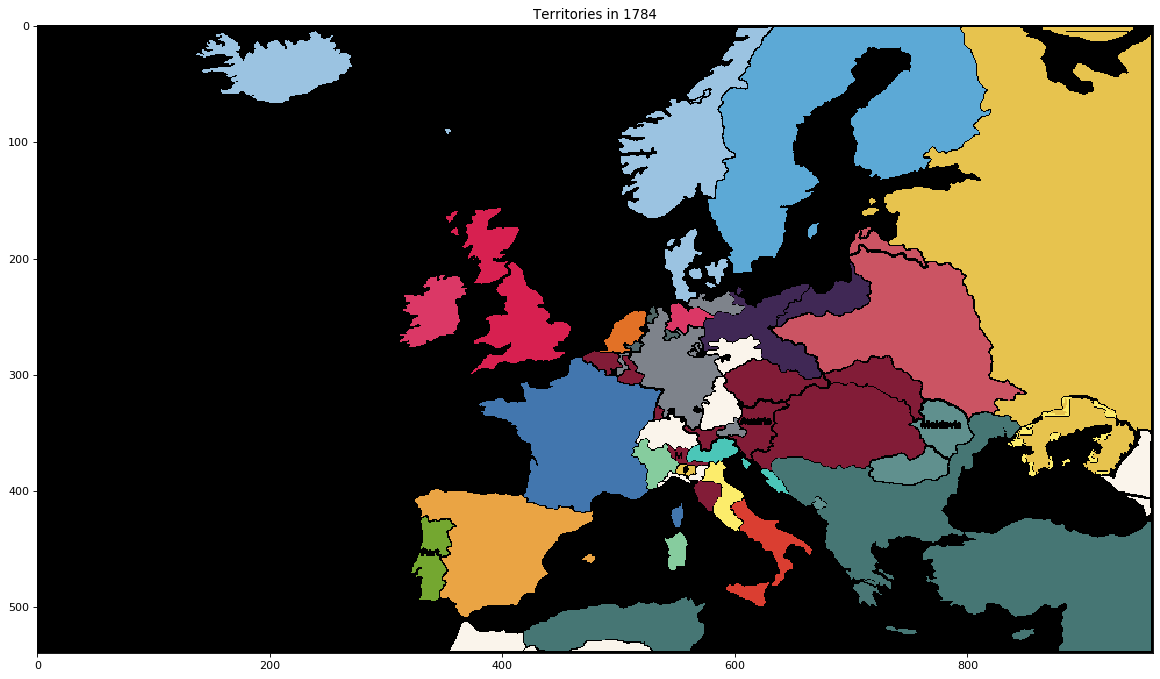

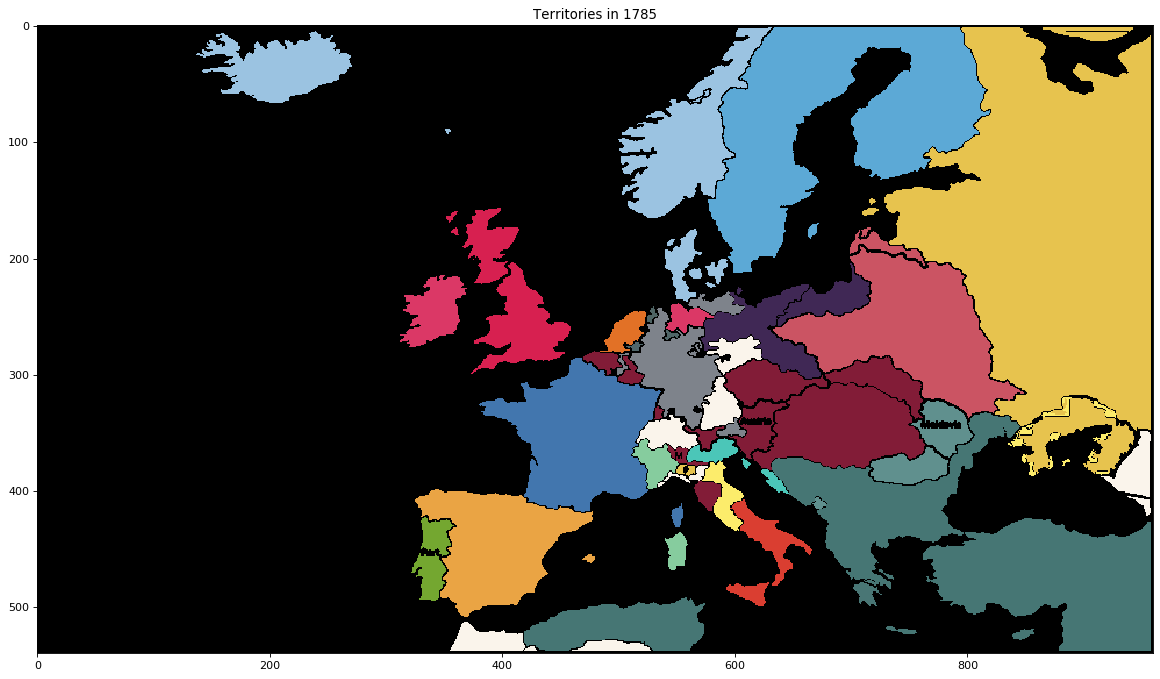

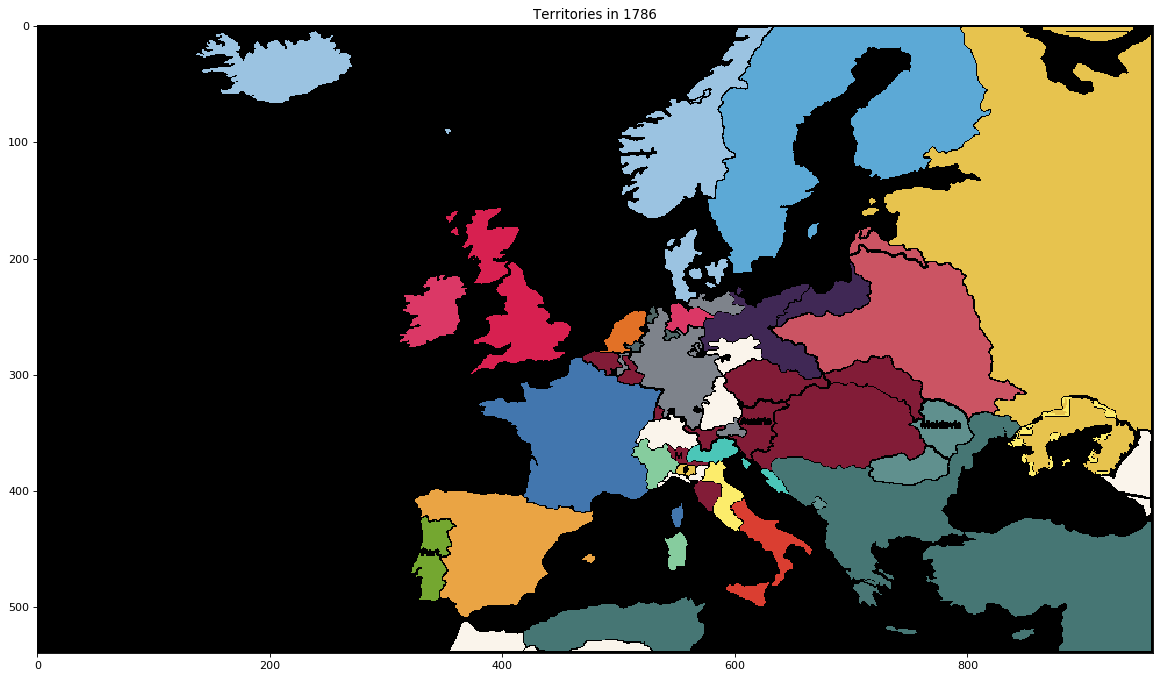

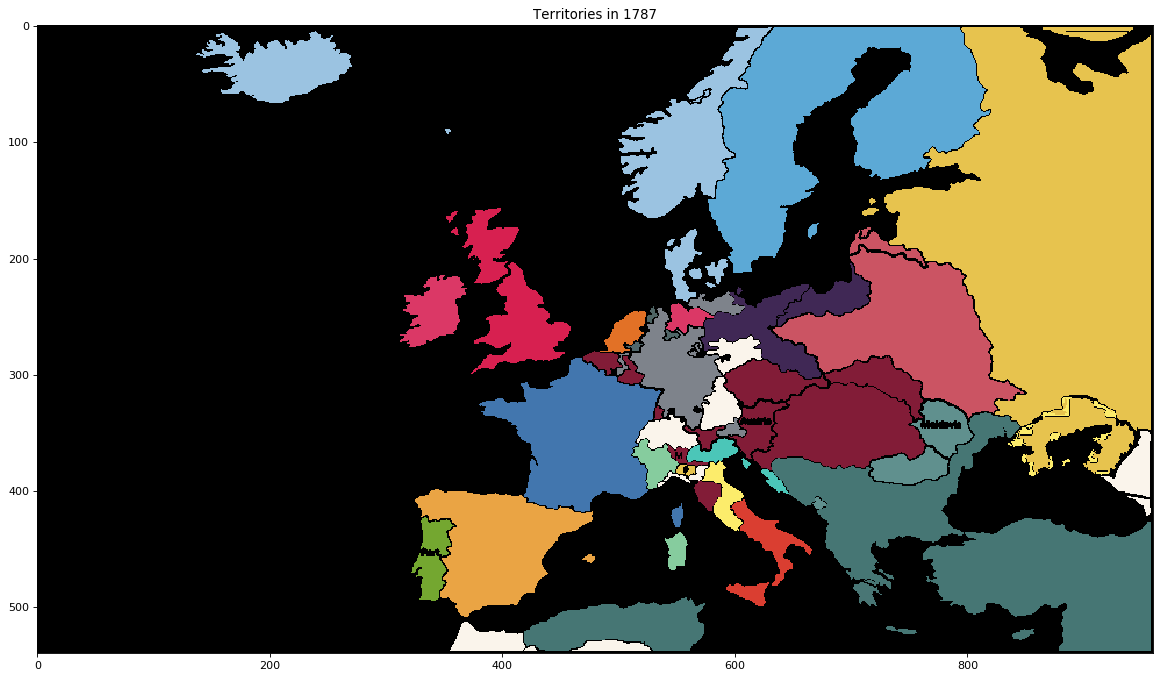

ignored 2 based on ignored_colors 


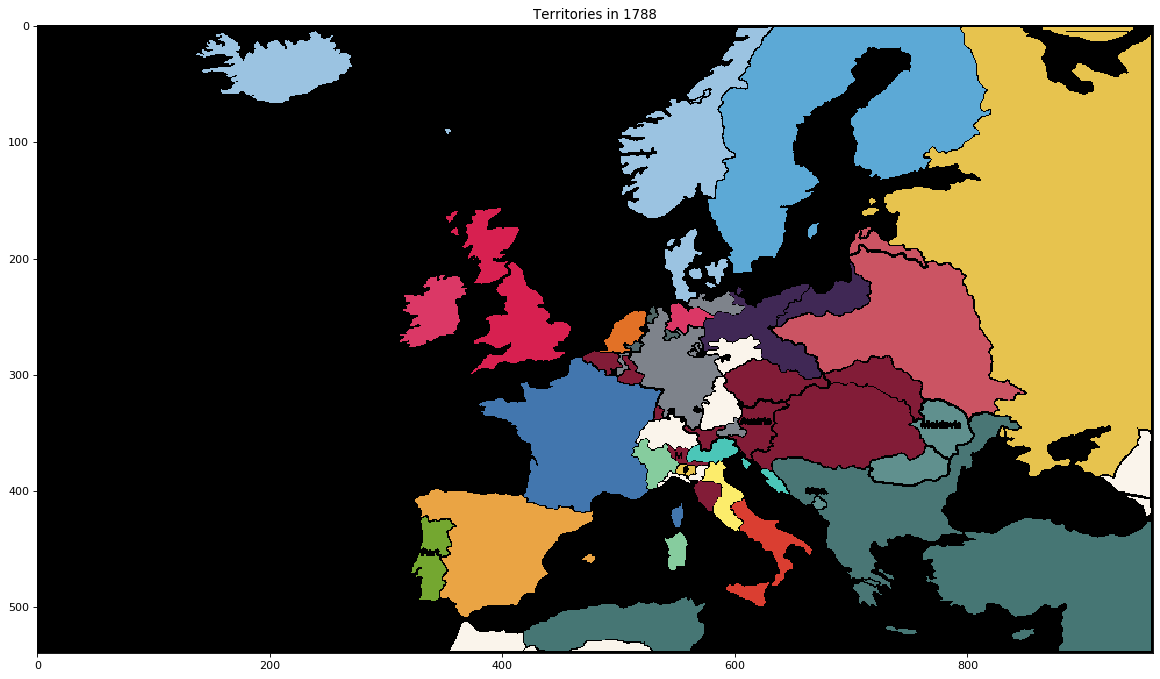

ignored 2 based on ignored_colors 


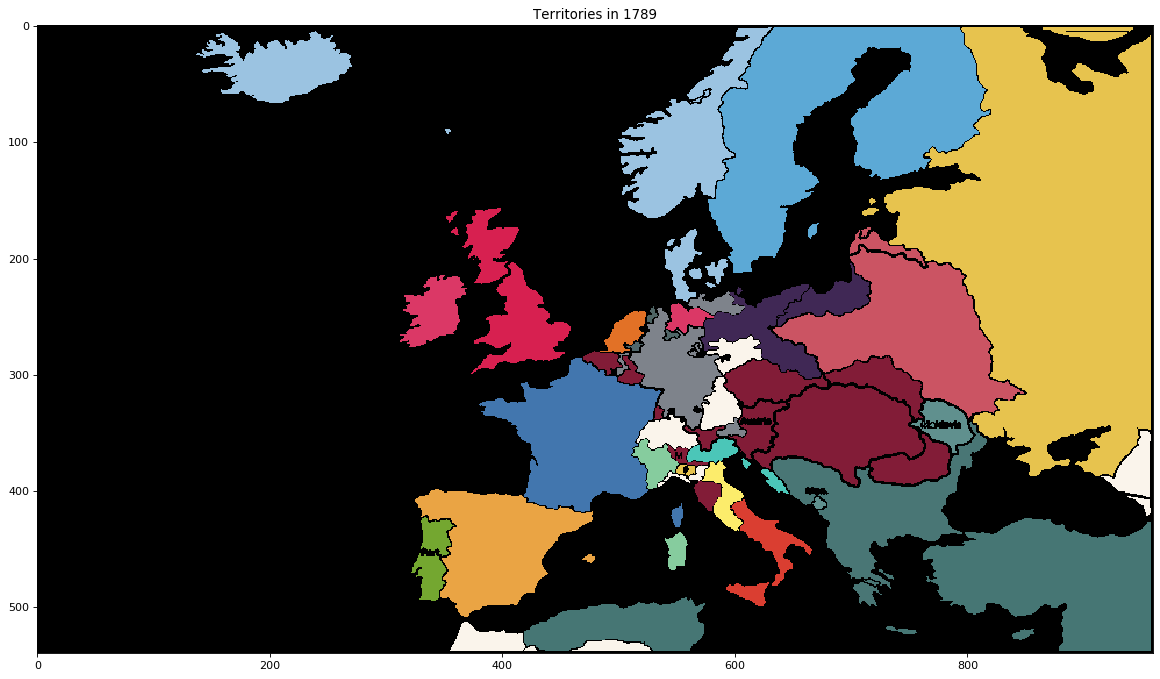

ignored 2 based on ignored_colors 


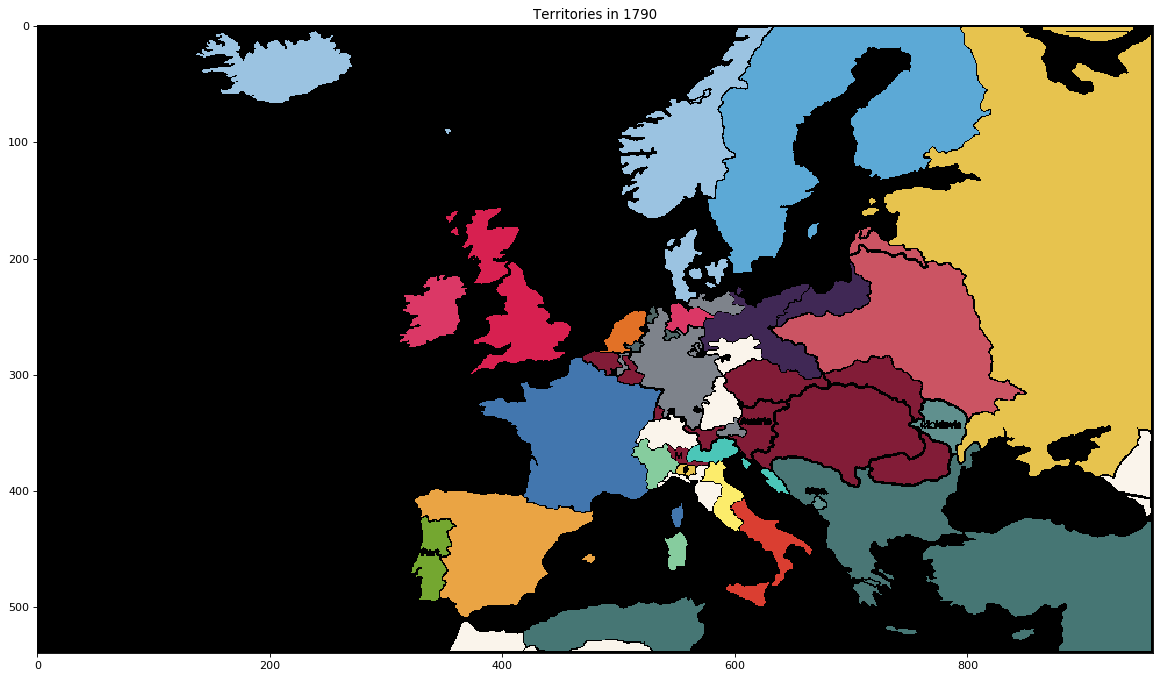

ignored 2 based on ignored_colors 


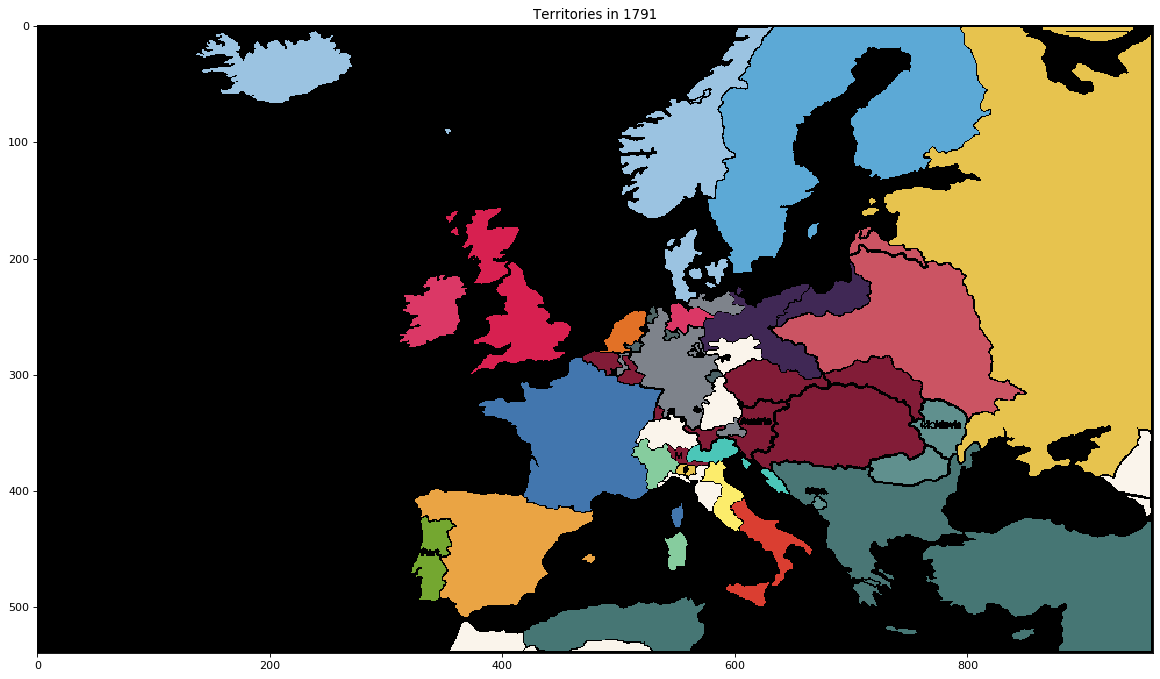

ignored 2 based on ignored_colors 


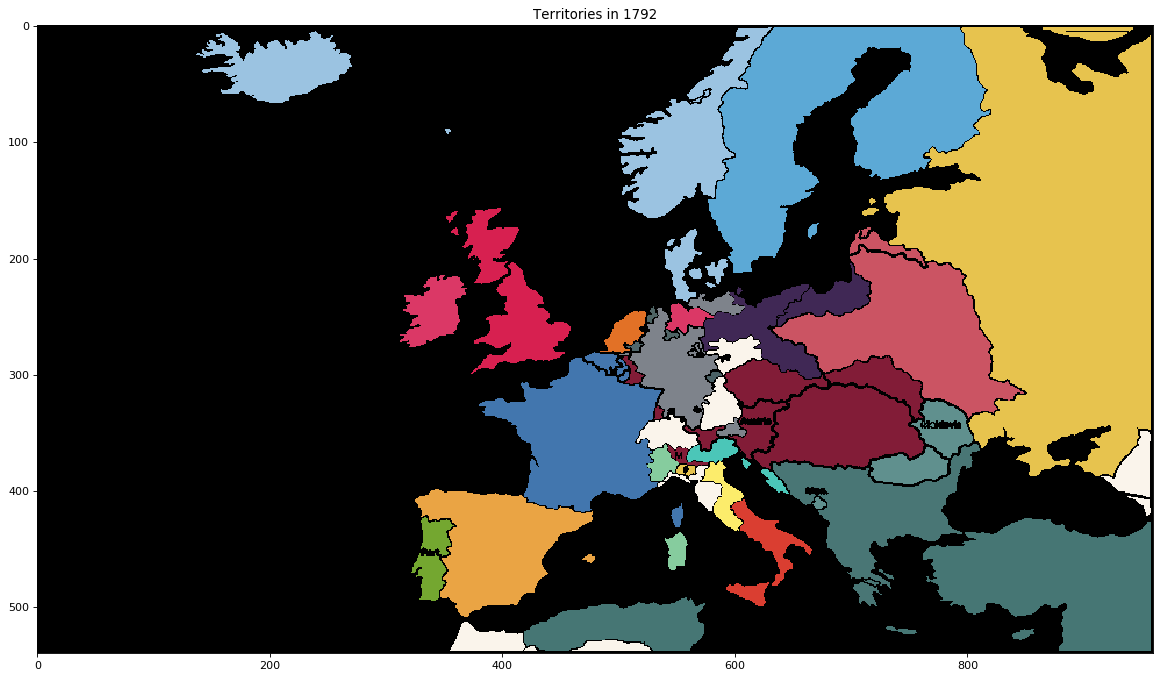

ignored 2 based on ignored_colors 


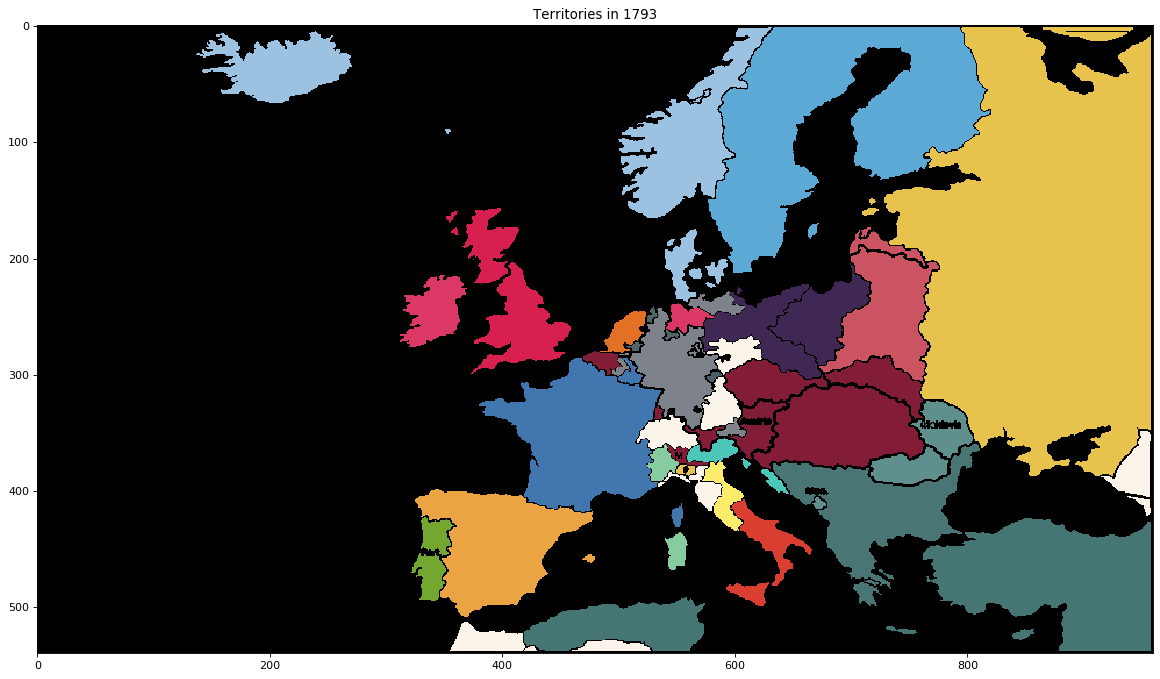

ignored 2 based on ignored_colors 


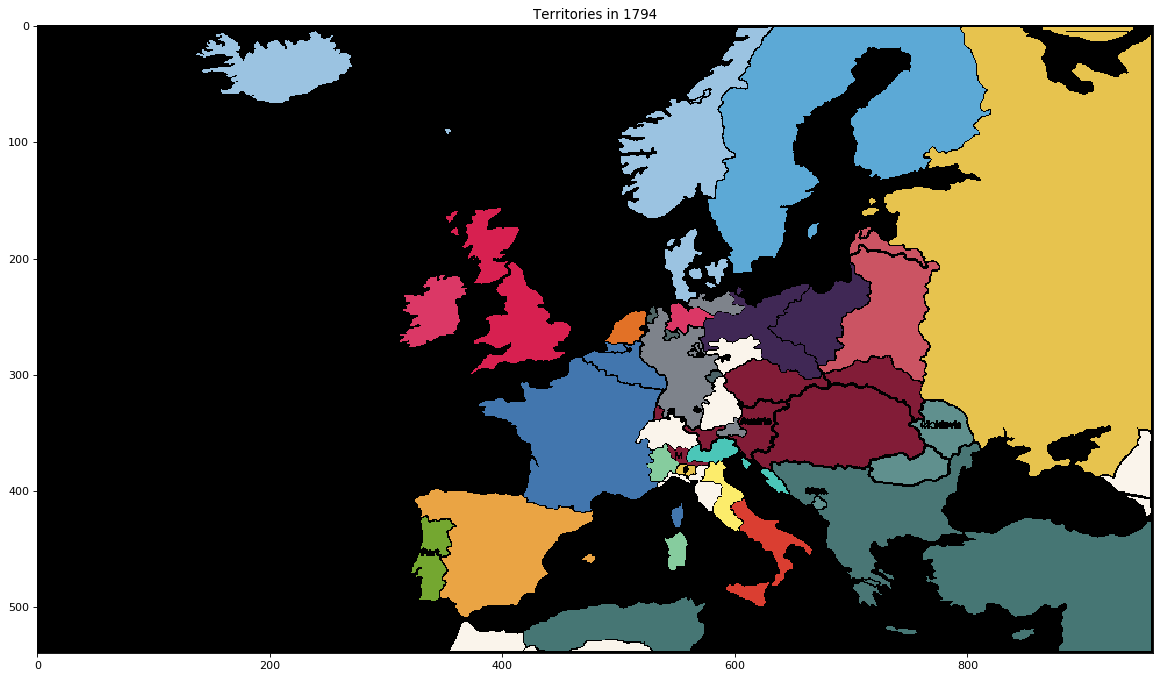

ignored 2 based on ignored_colors 


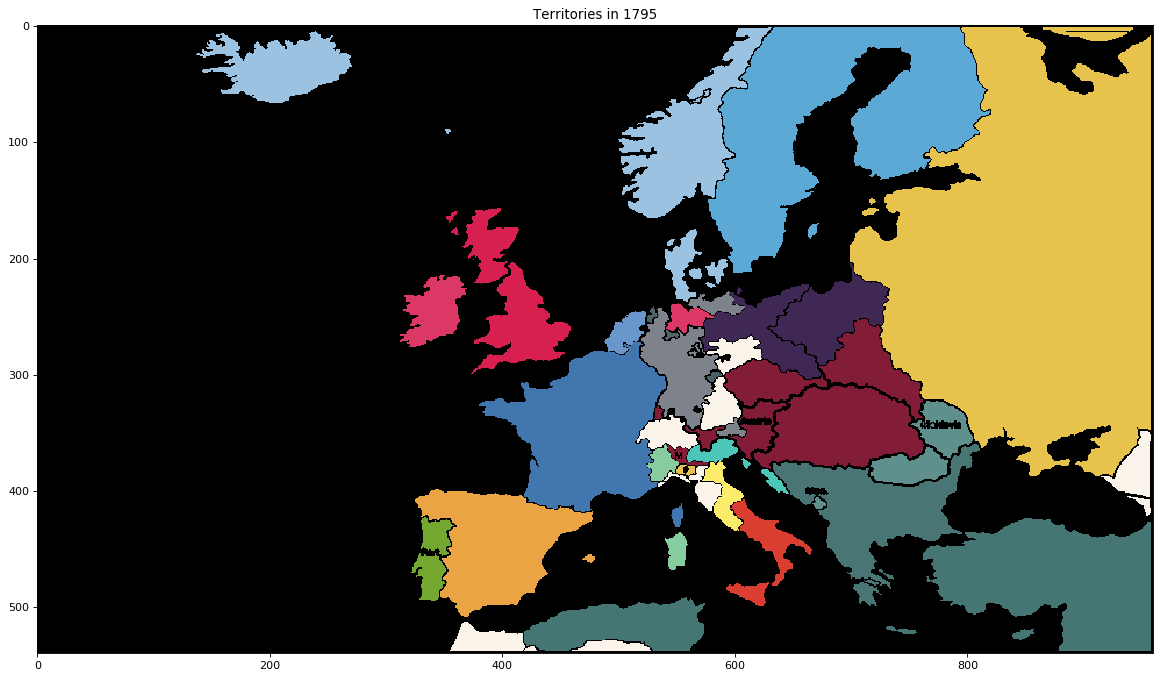

ignored 2 based on ignored_colors 


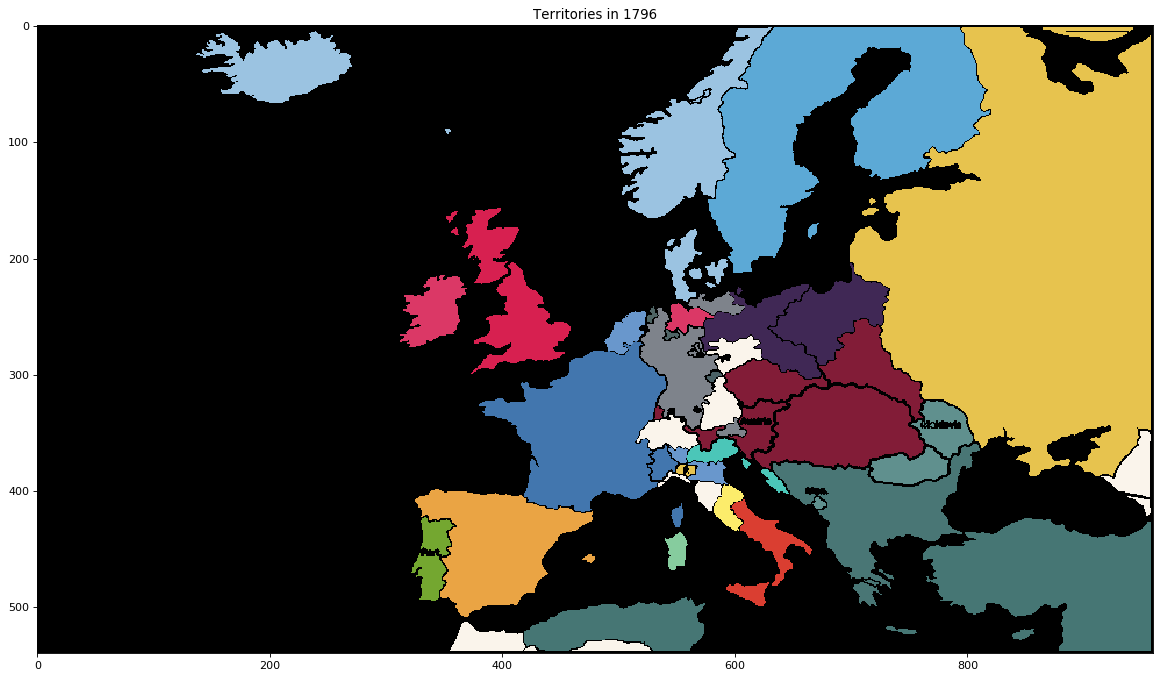

ignored 2 based on ignored_colors 


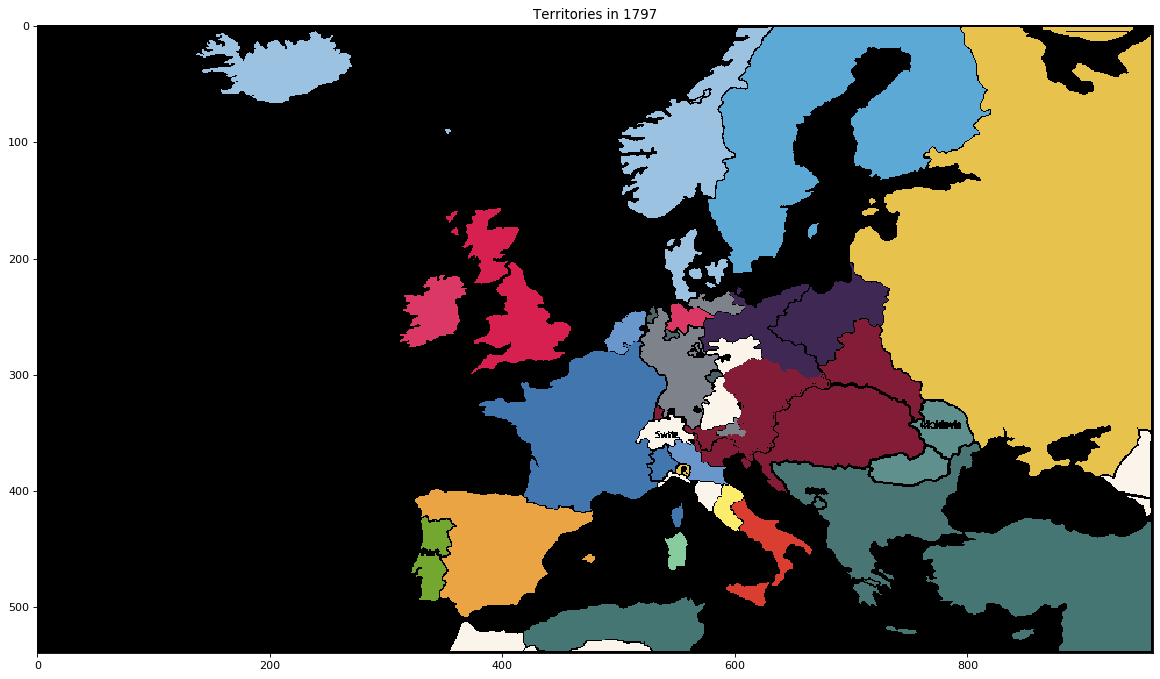

ignored 2 based on ignored_colors 


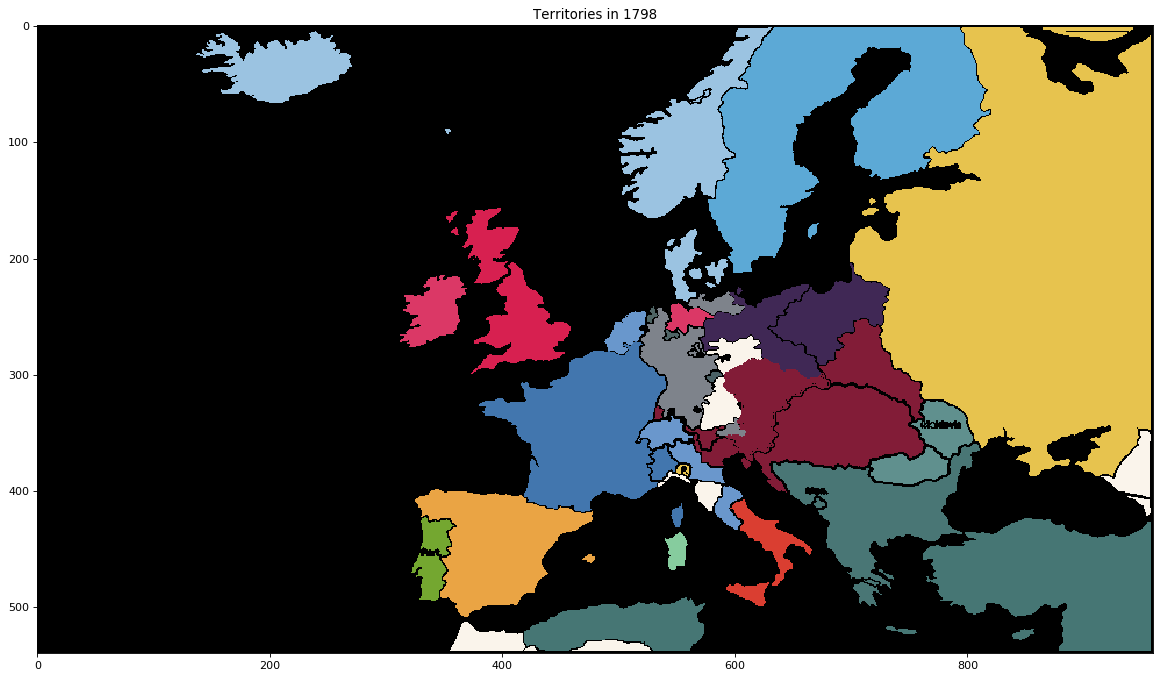

ignored 2 based on ignored_colors 


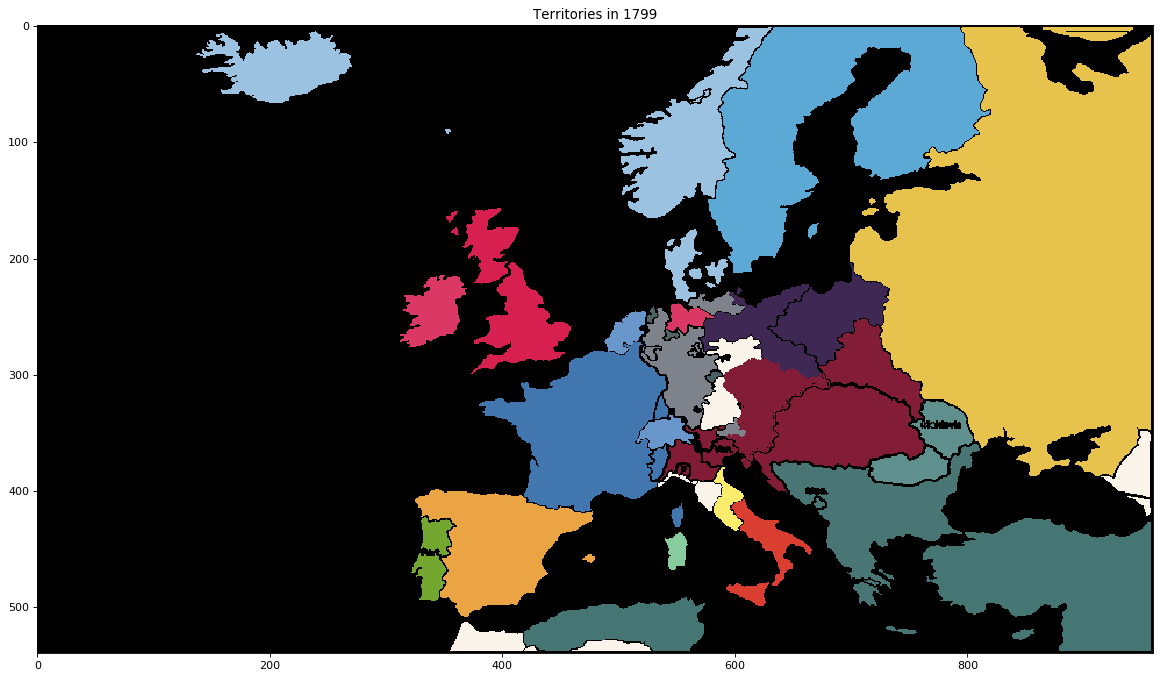

ignored 2 based on ignored_colors 


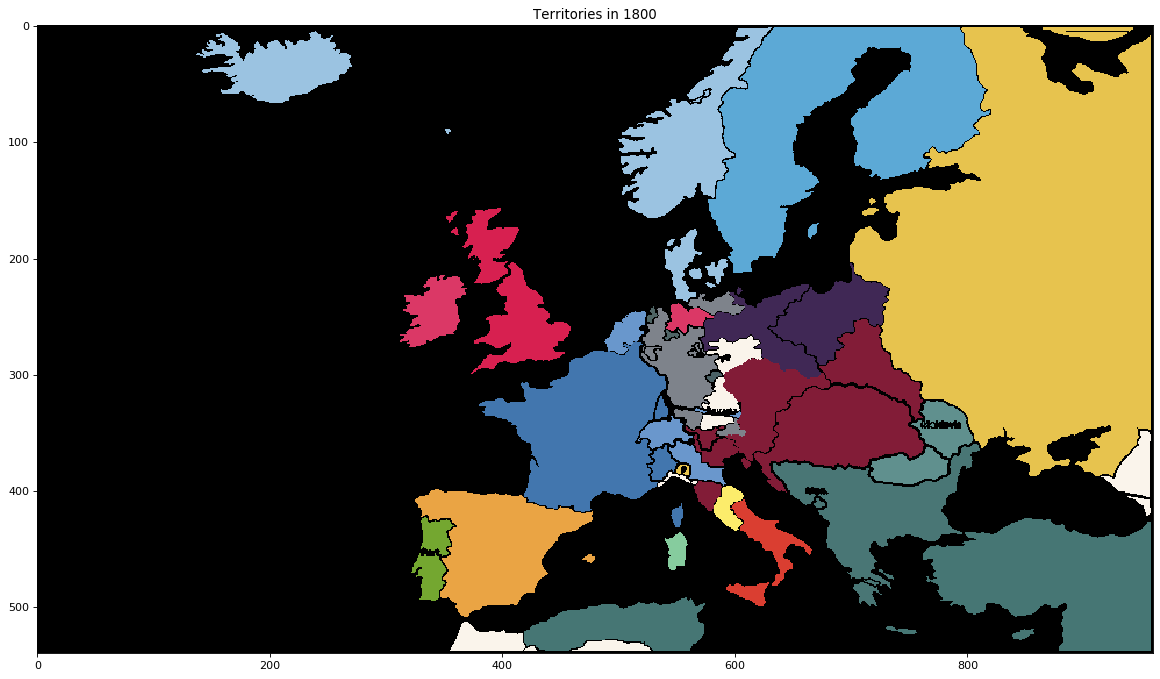

ignored 2 based on ignored_colors 


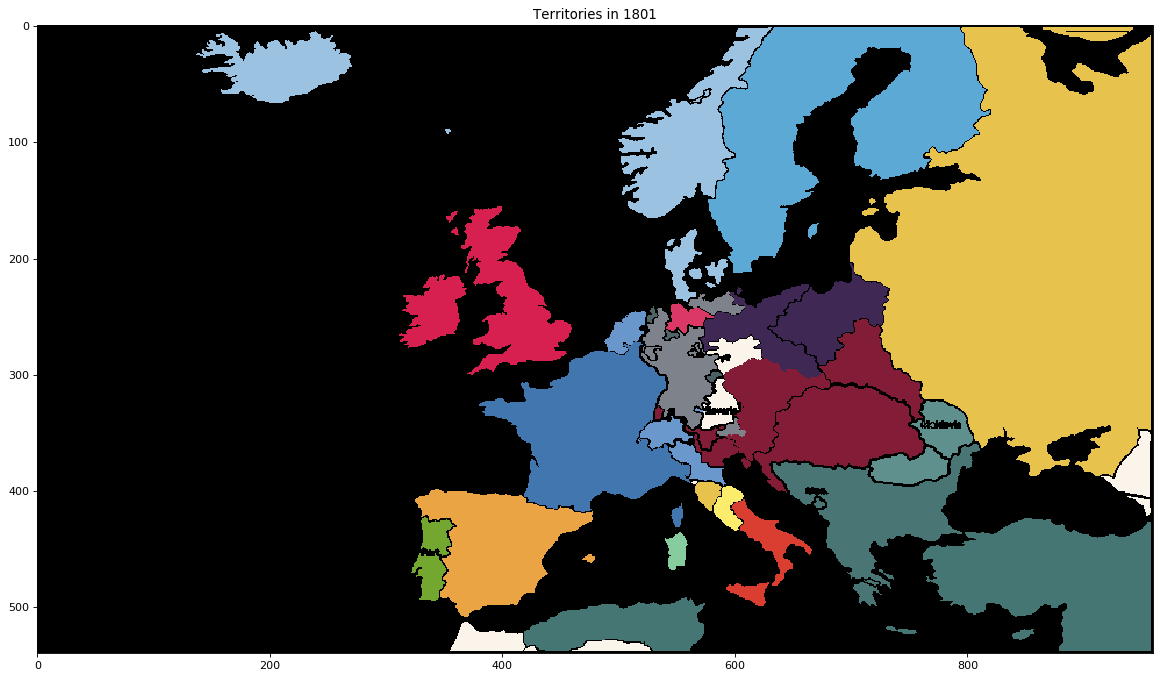

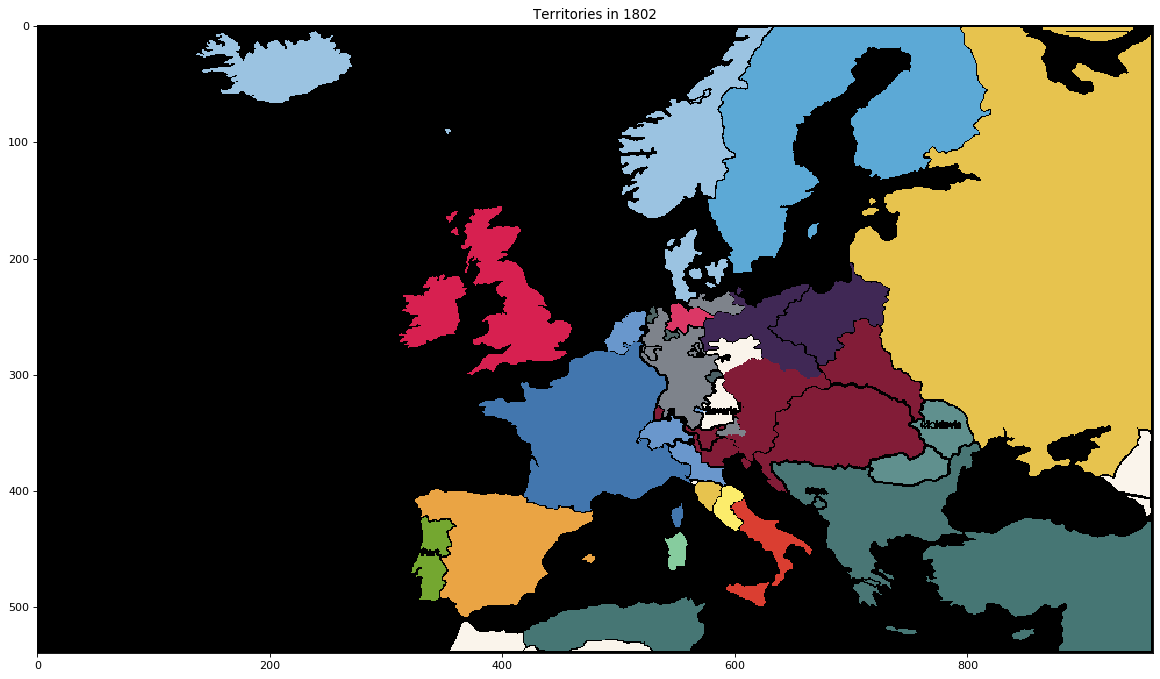

ignored 2 based on ignored_colors 


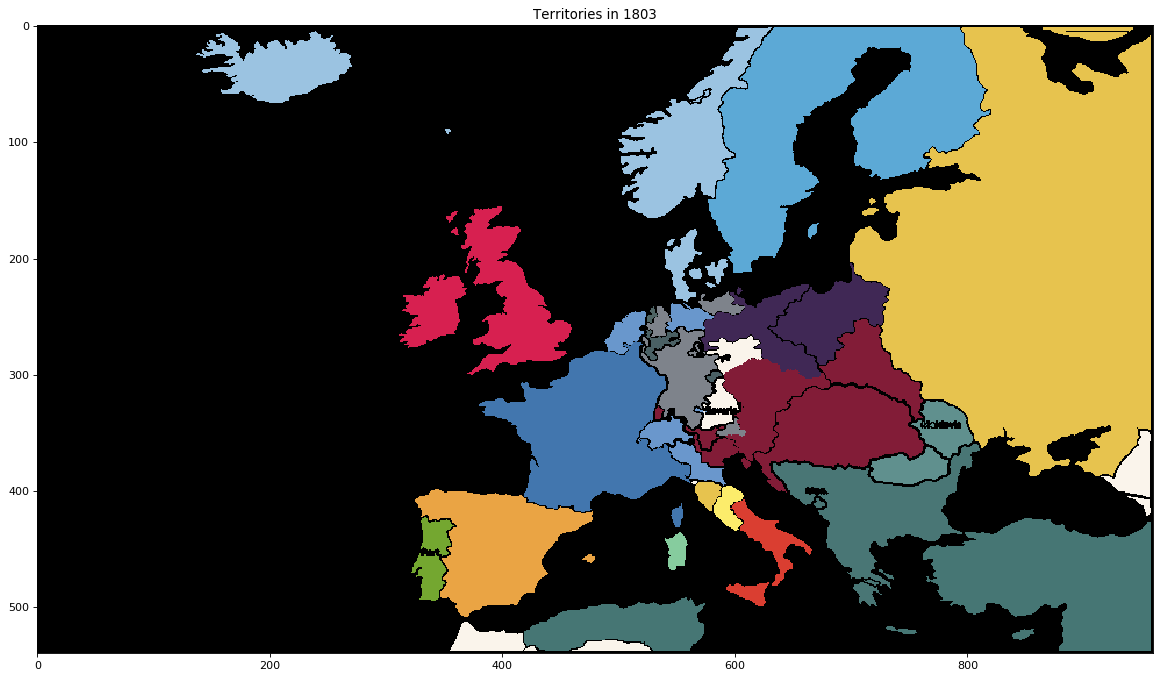

ignored 1 based on ignored_colors 


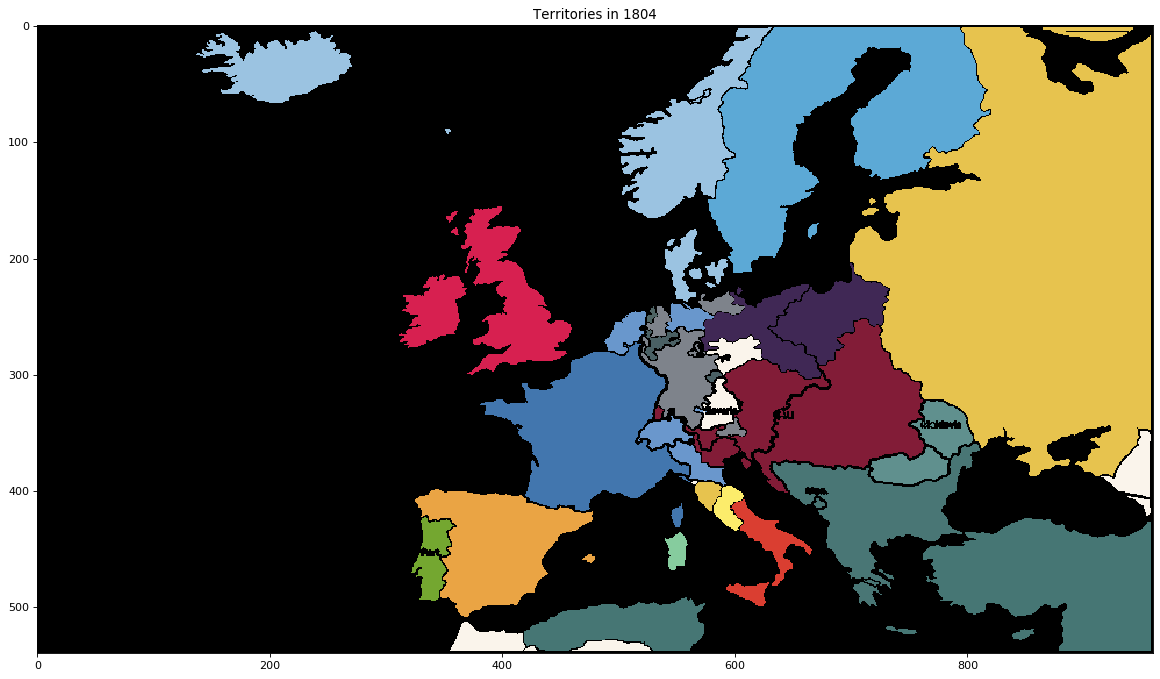

ignored 1 based on ignored_colors 


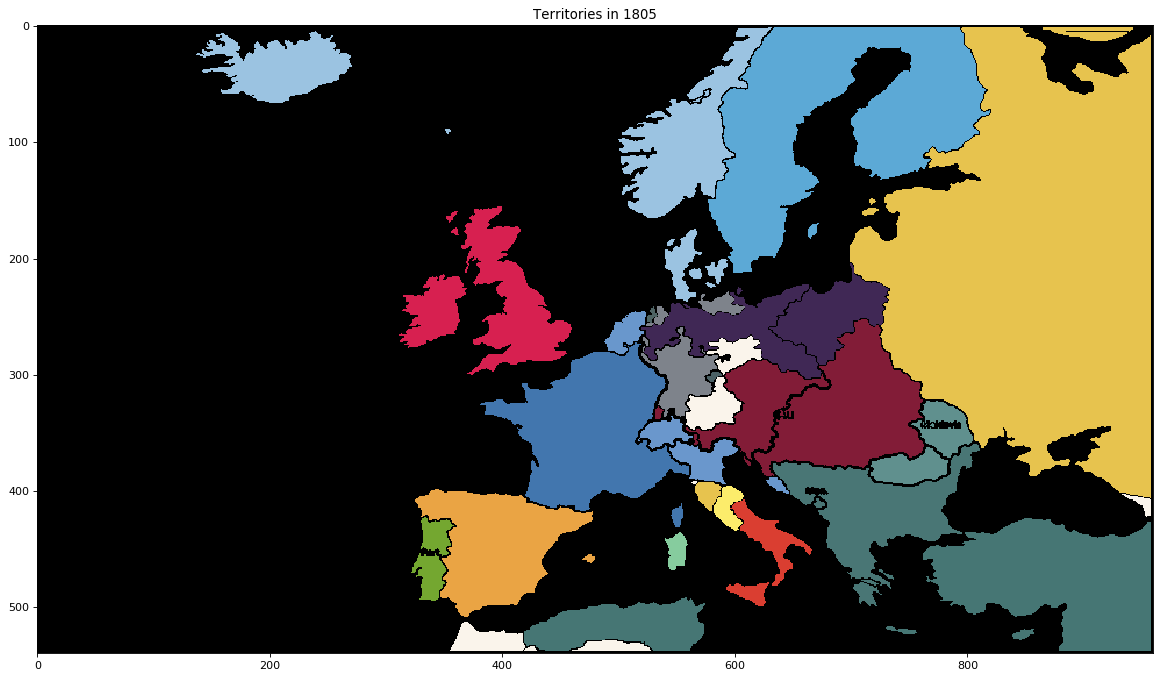

ignored 1 based on ignored_colors 


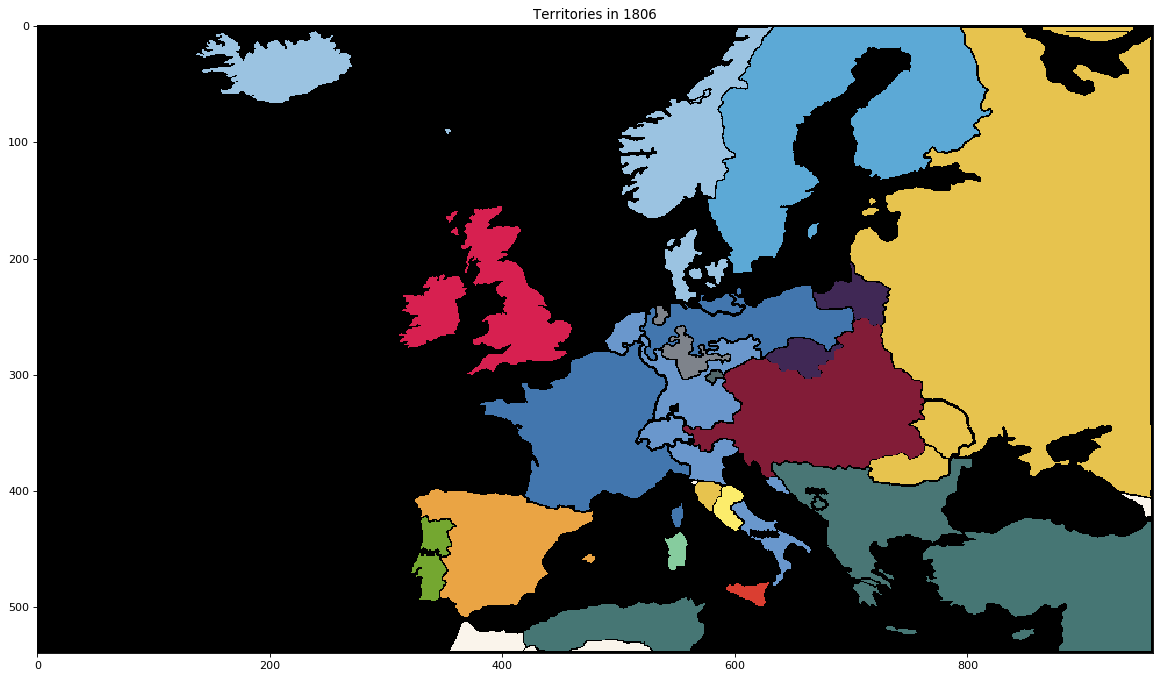

ignored 1 based on ignored_colors 


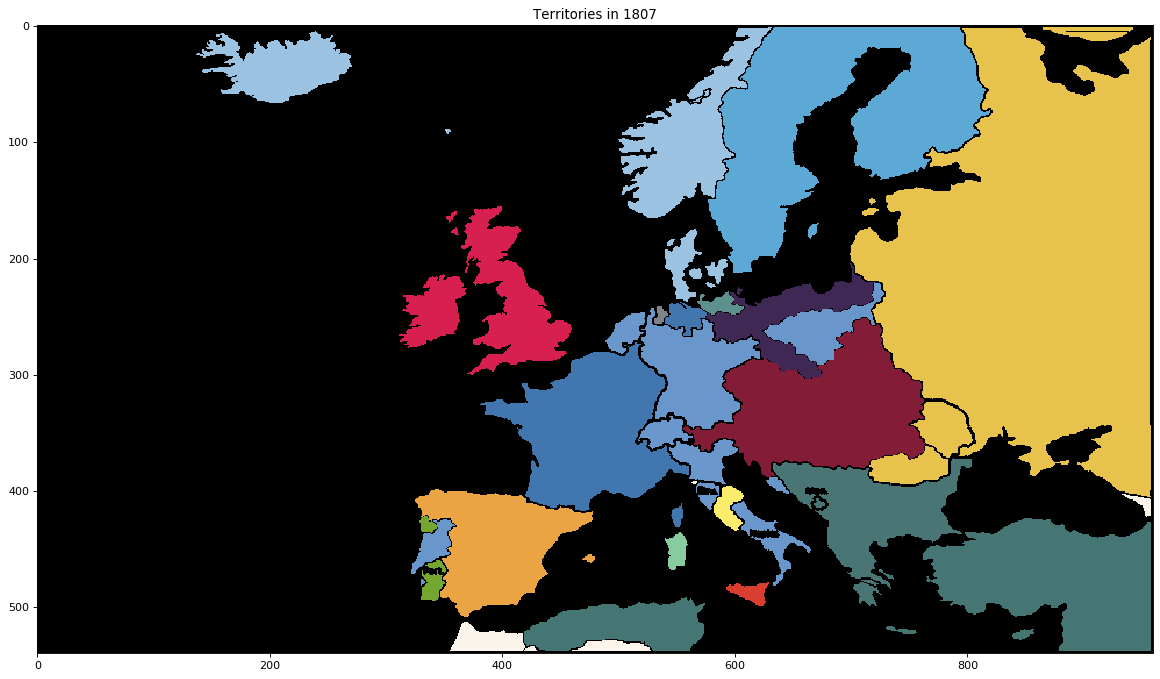

ignored 1 based on ignored_colors 


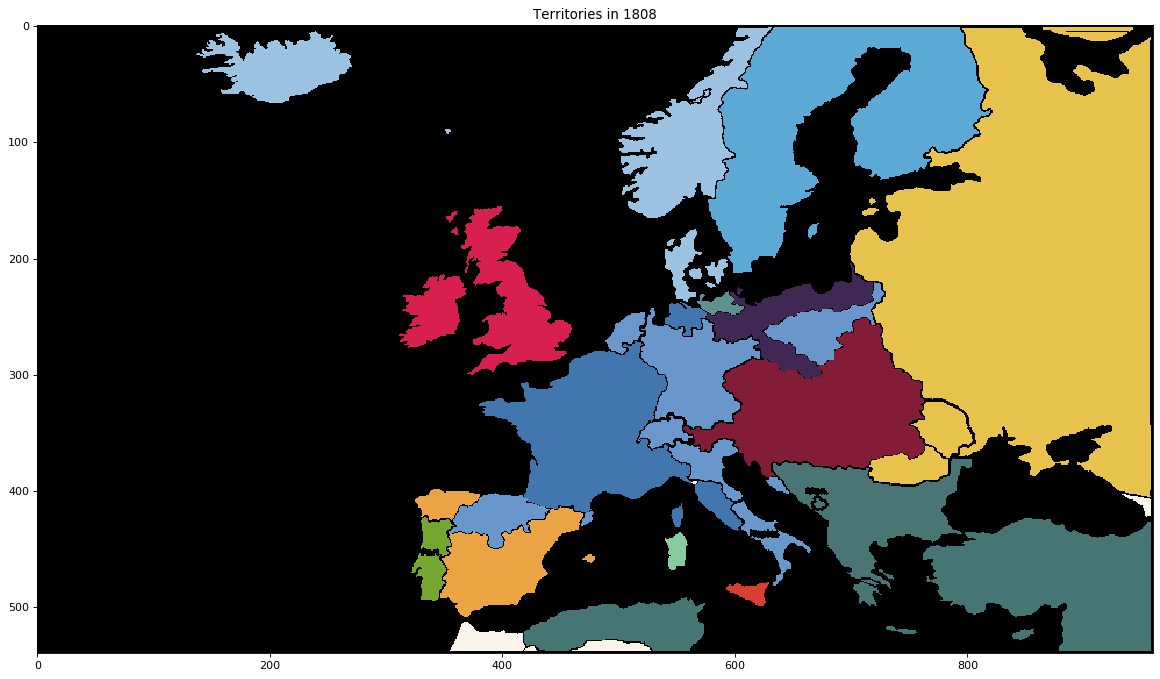

ignored 1 based on ignored_colors 


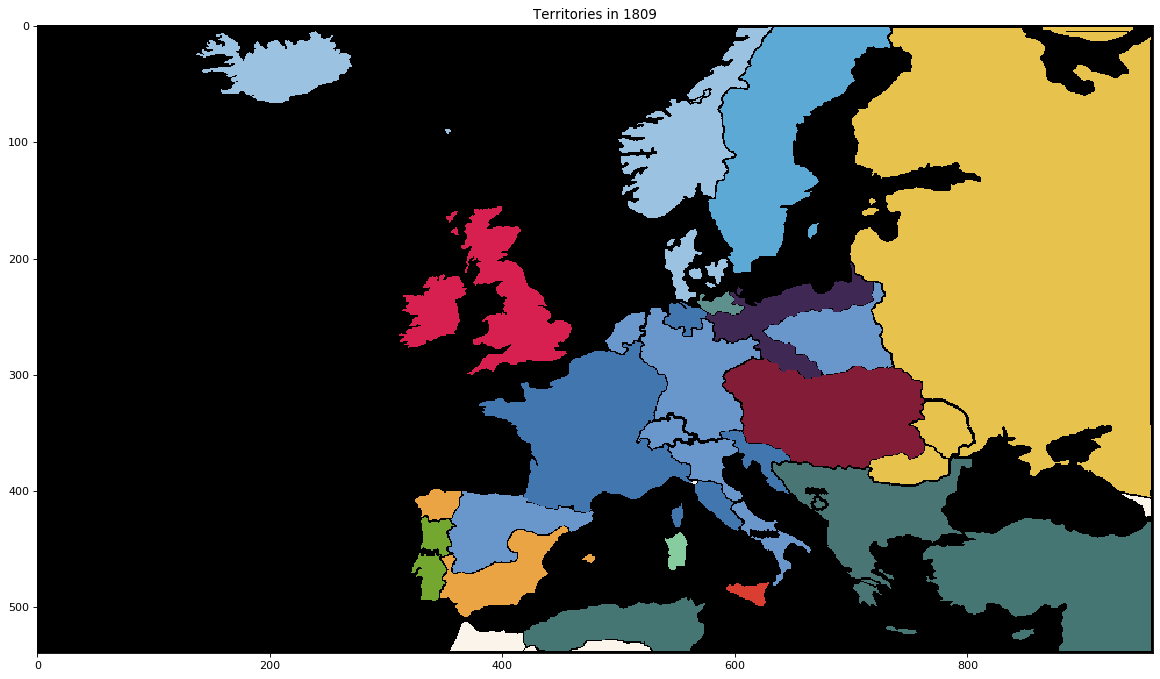

ignored 1 based on ignored_colors 


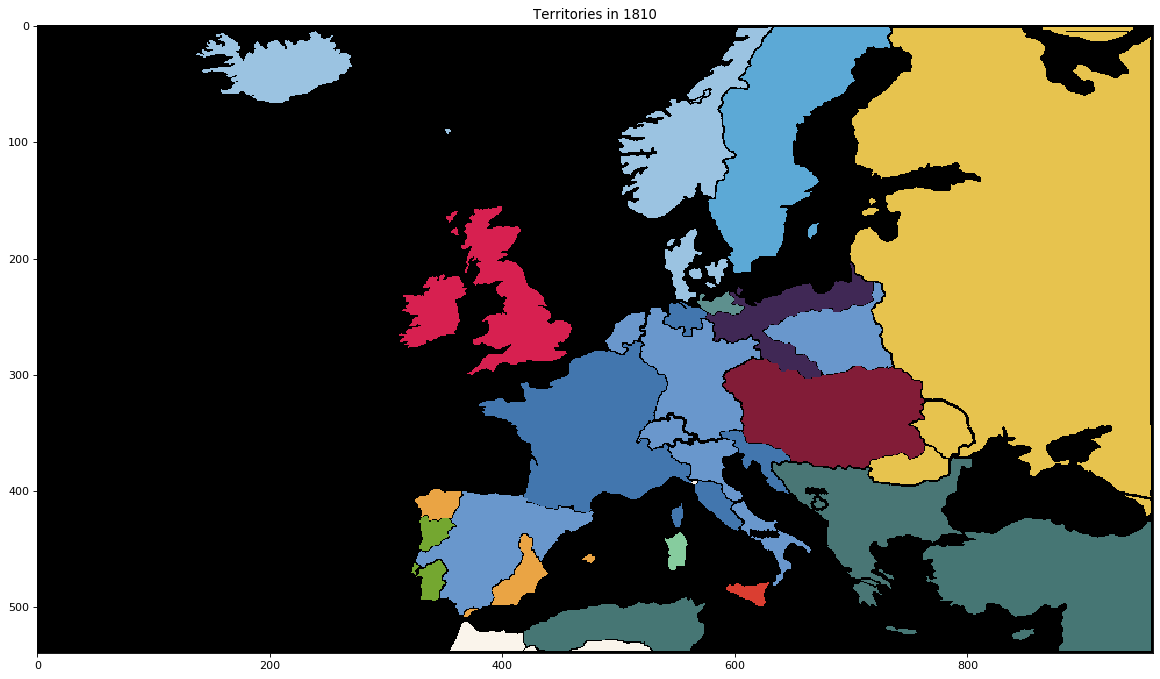

ignored 1 based on ignored_colors 


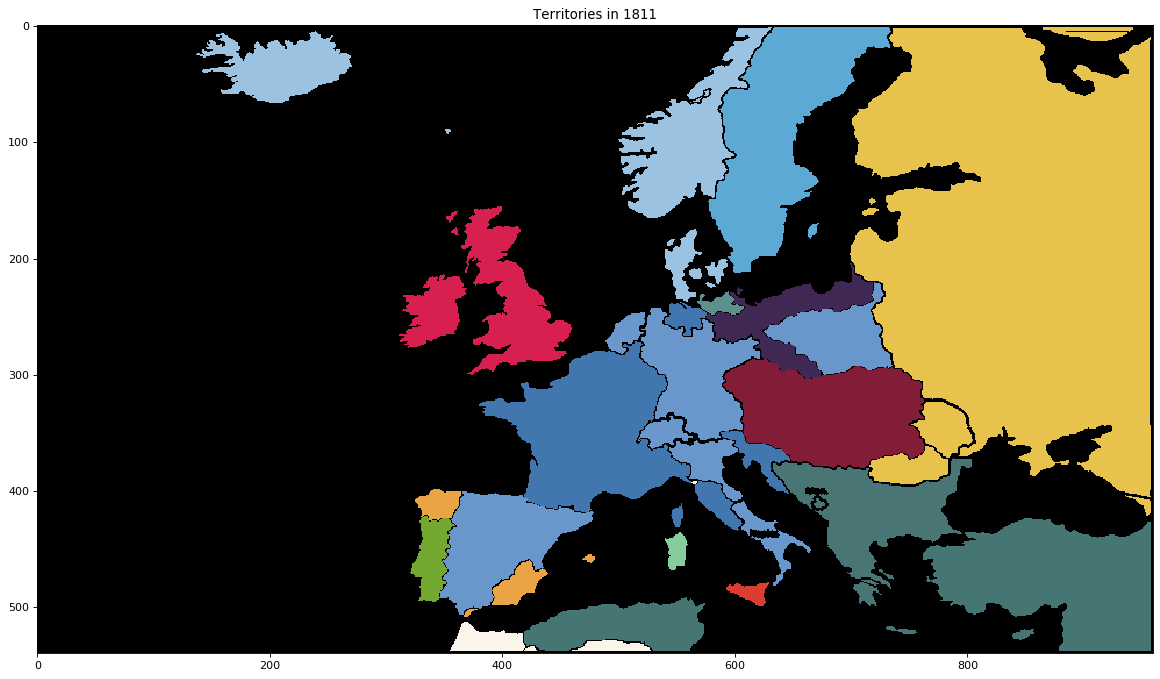

ignored 1 based on ignored_colors 


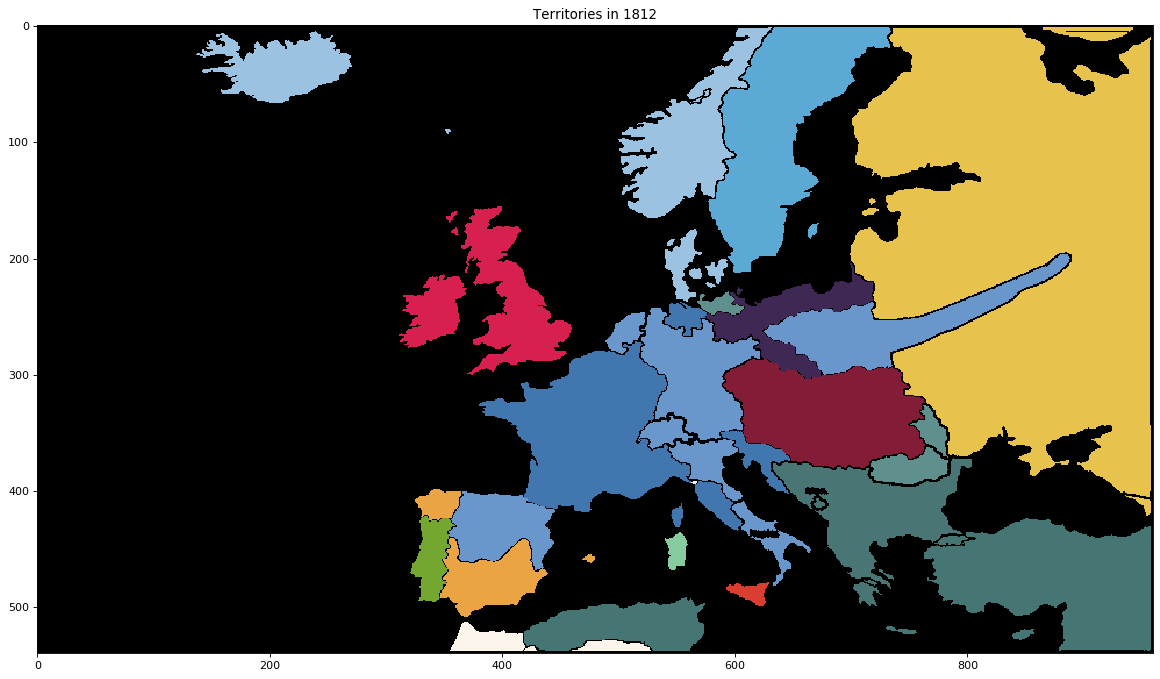

ignored 2 based on ignored_colors 


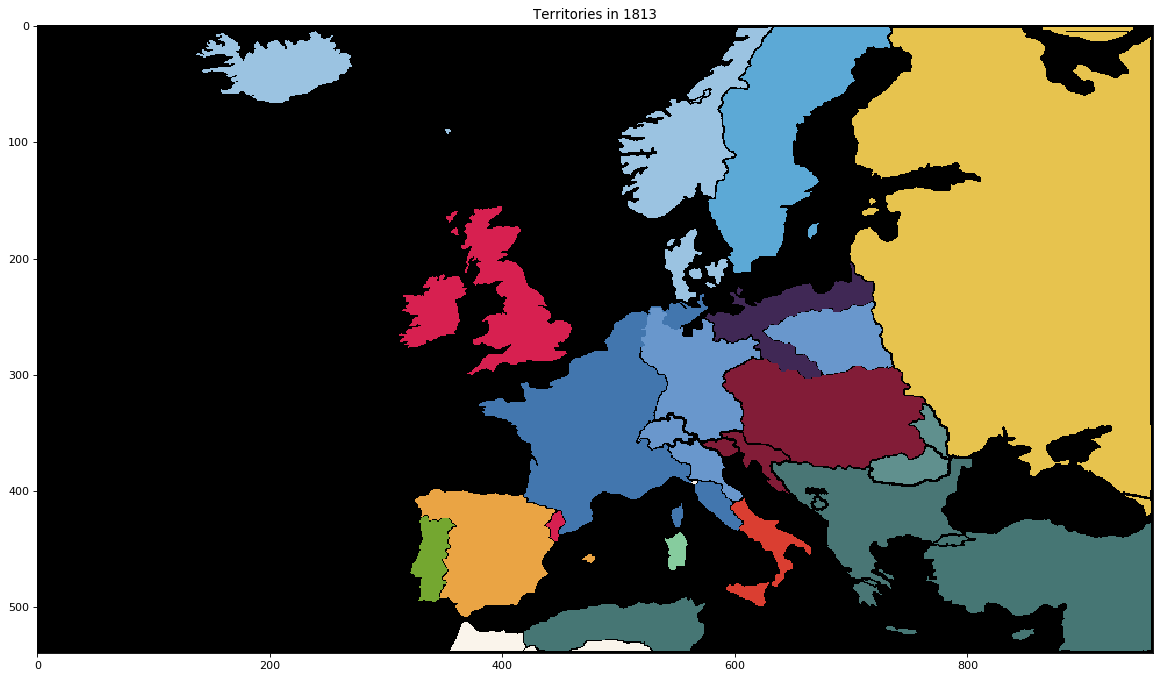

ignored 2 based on ignored_colors 


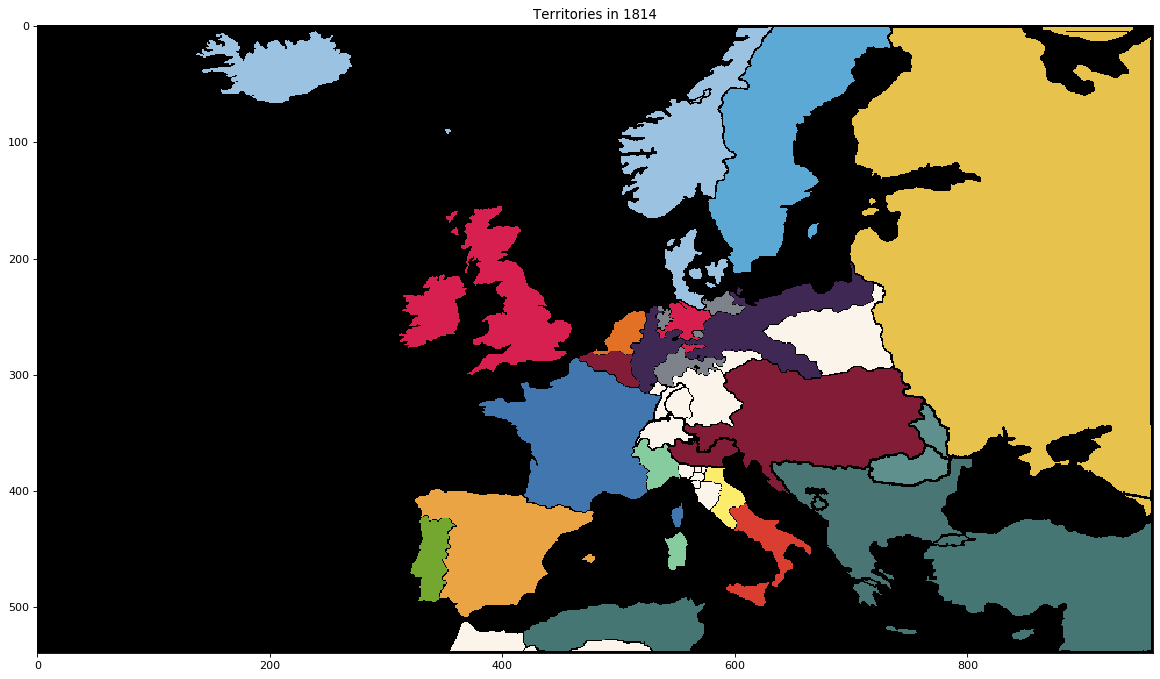

ignored 2 based on ignored_colors 


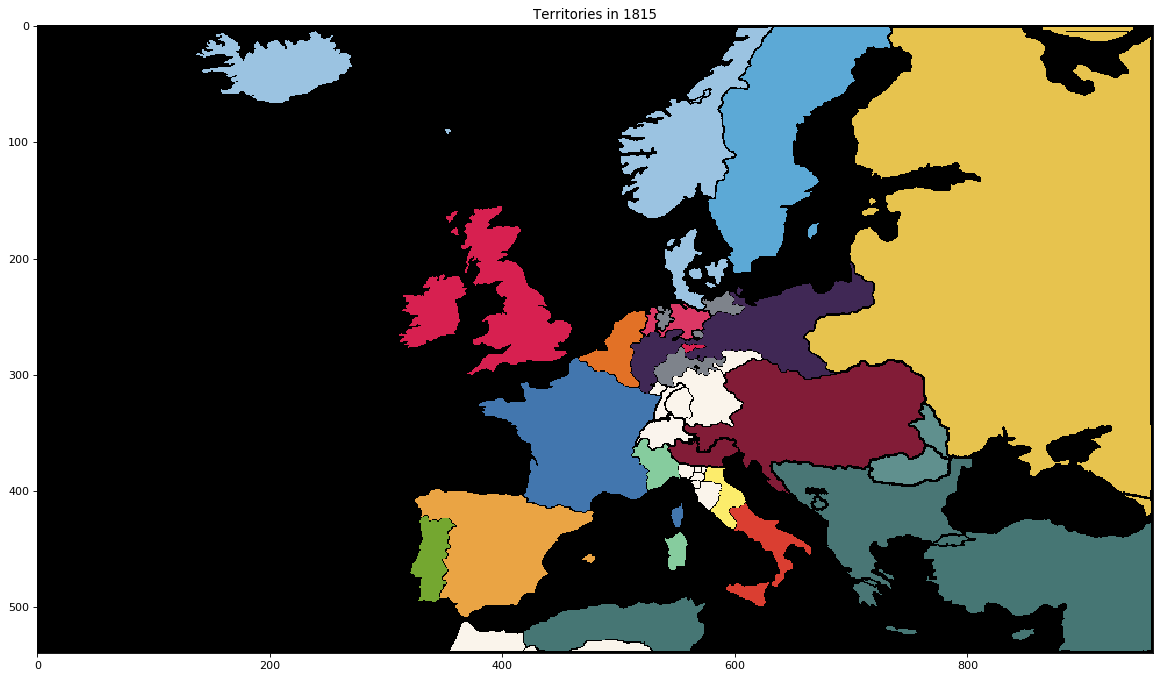

ignored 2 based on ignored_colors 


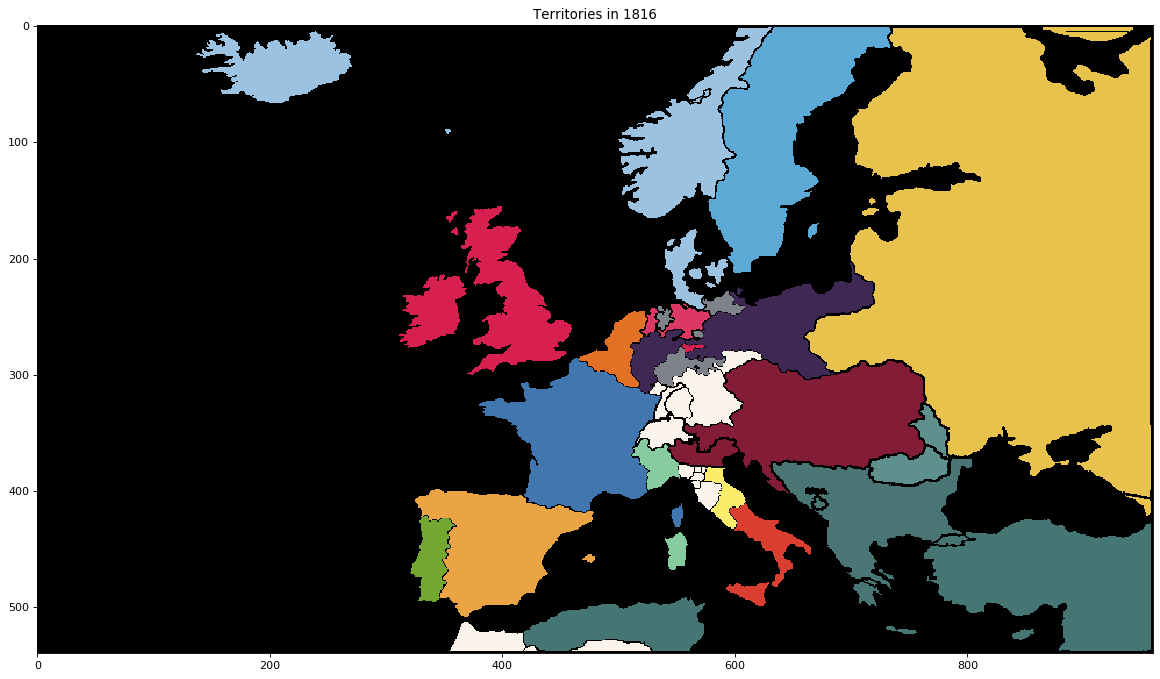

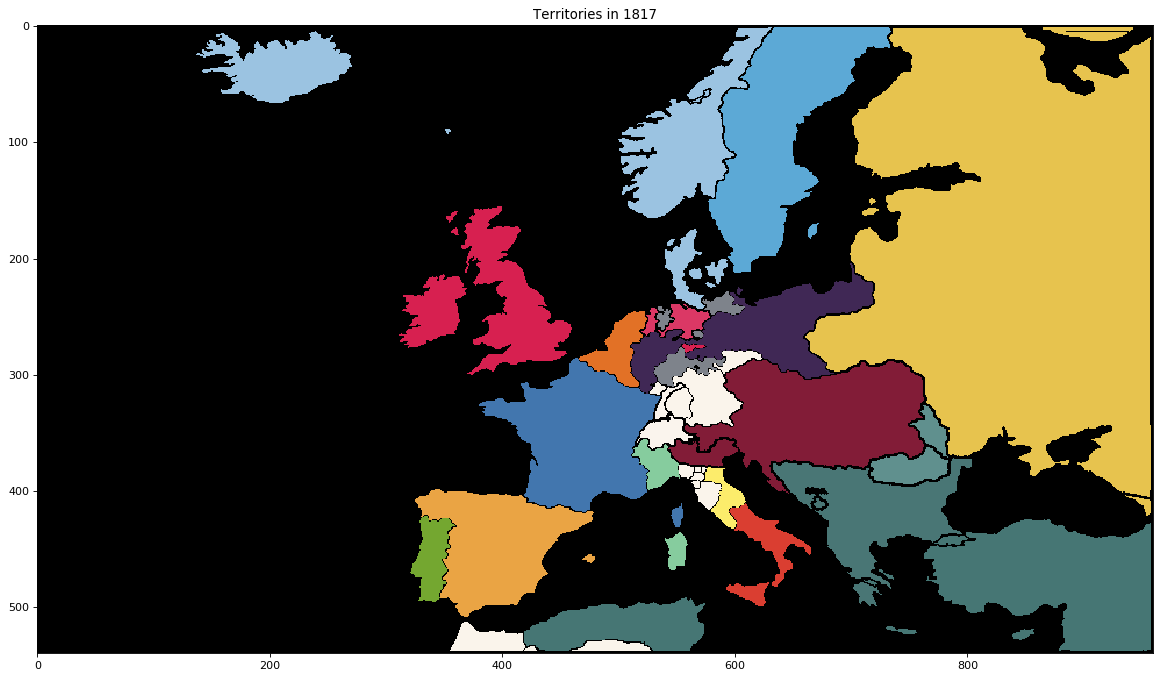

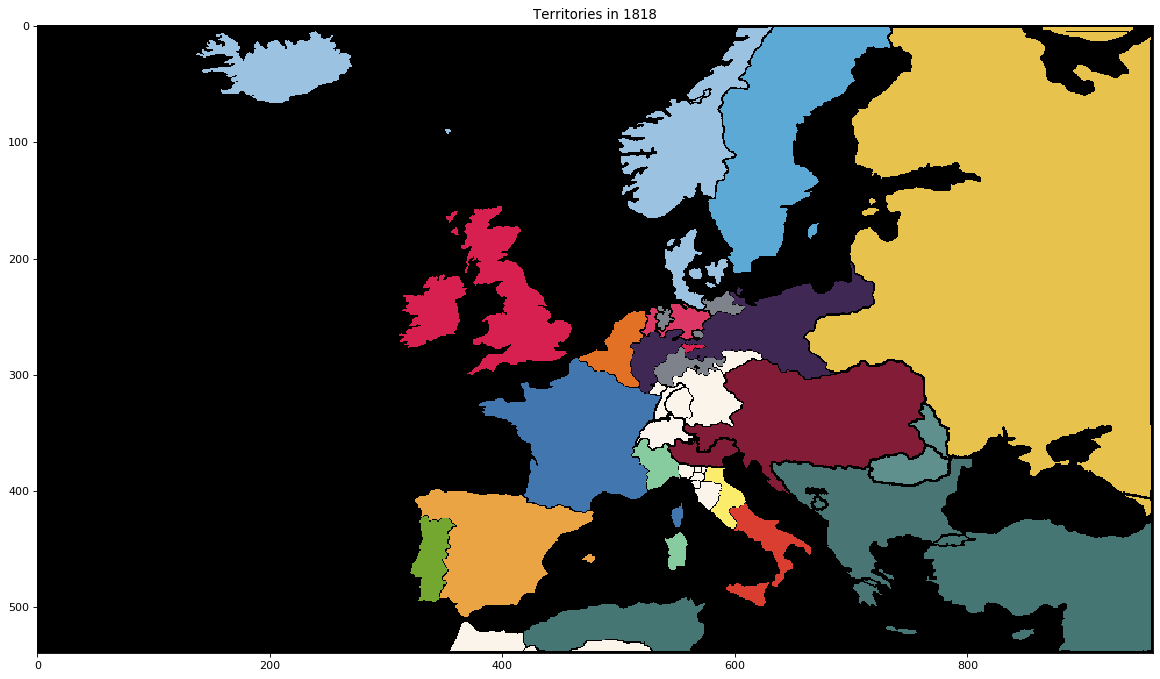

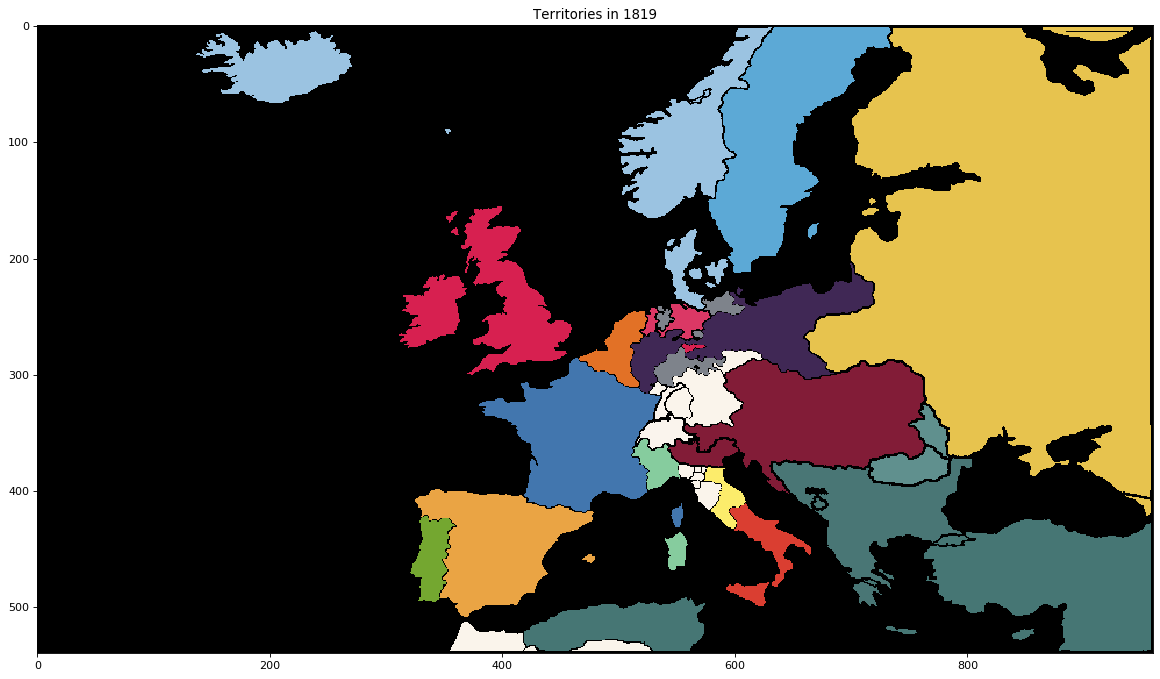

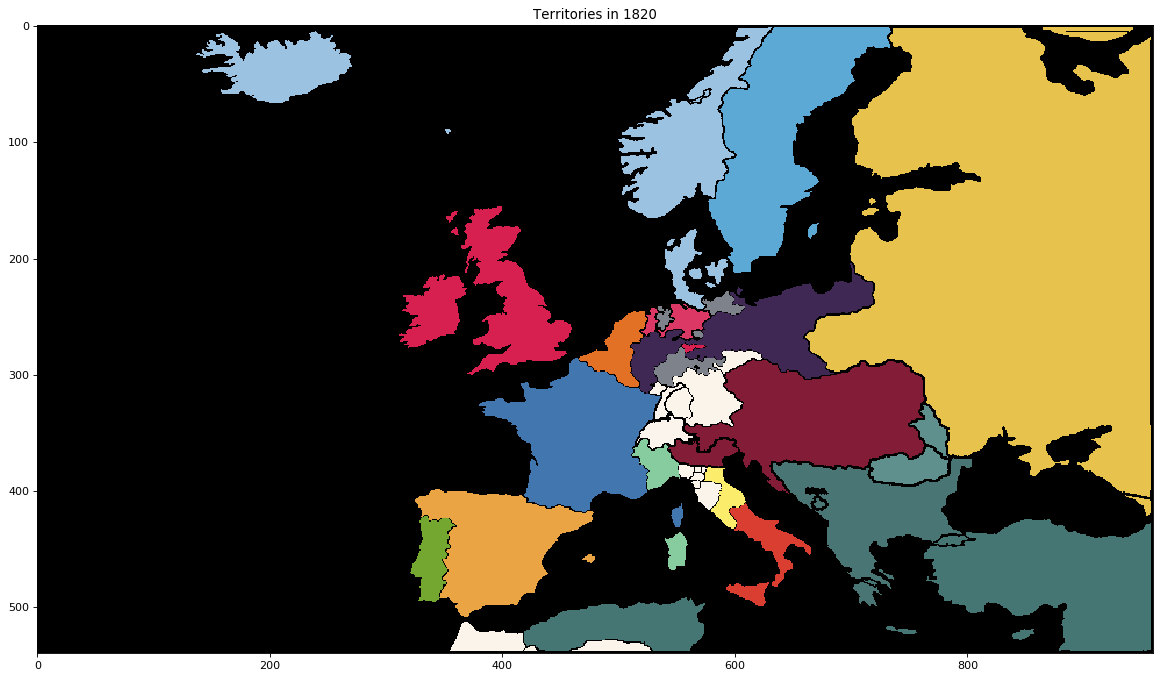

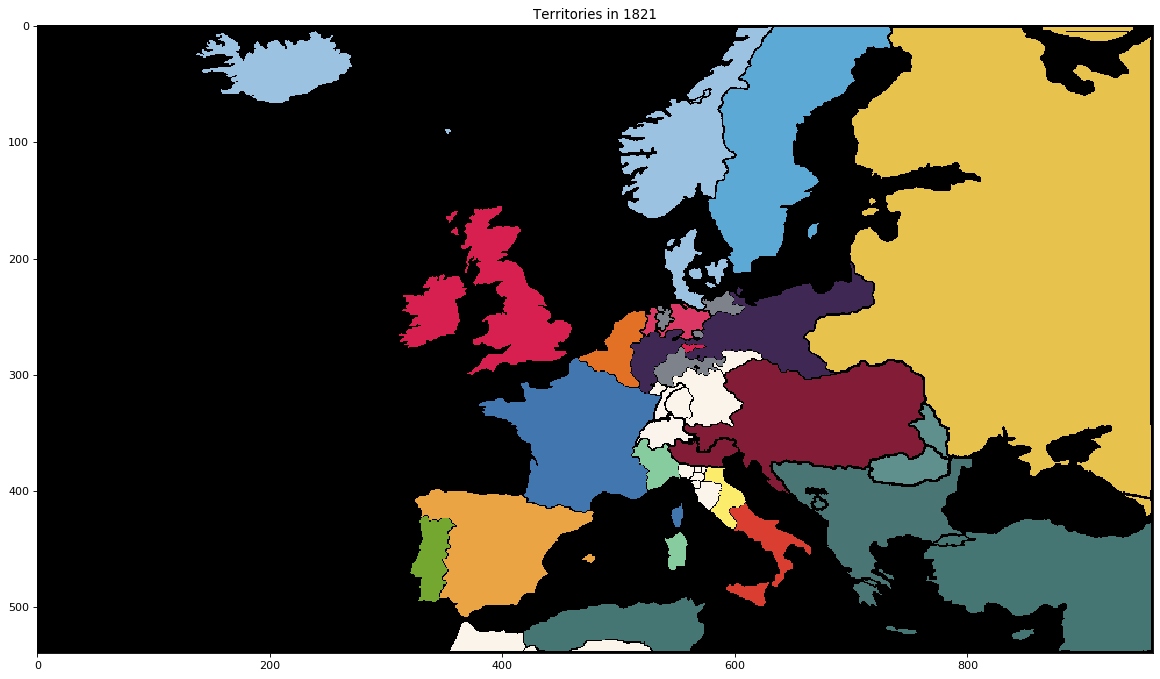

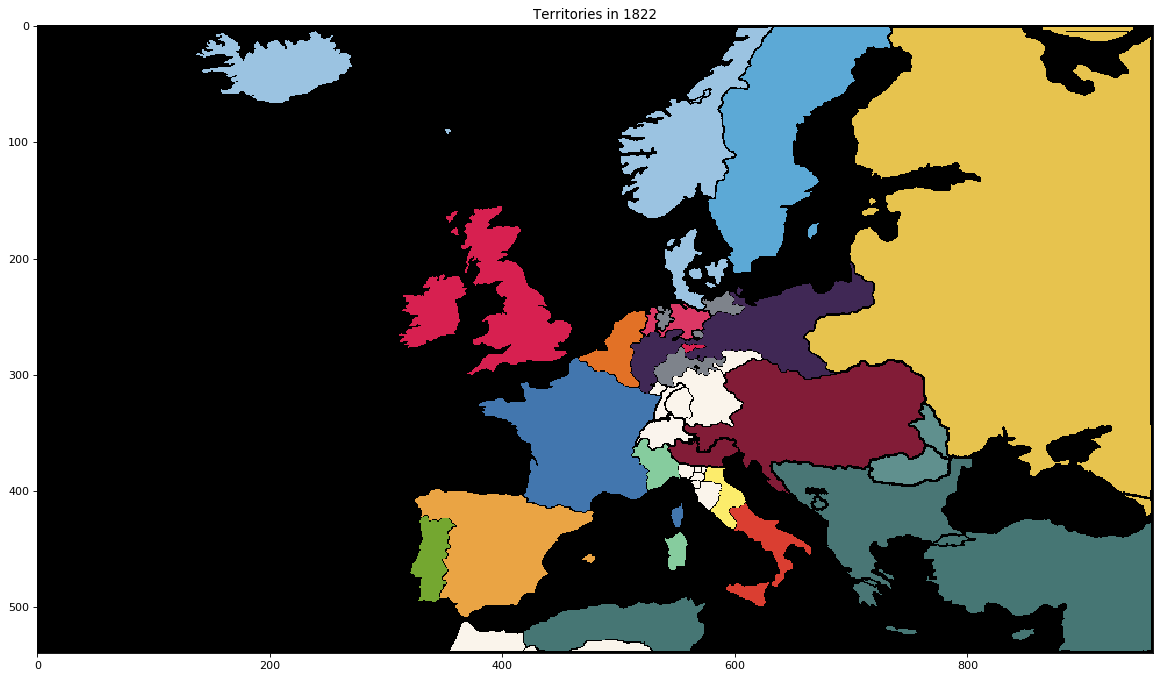

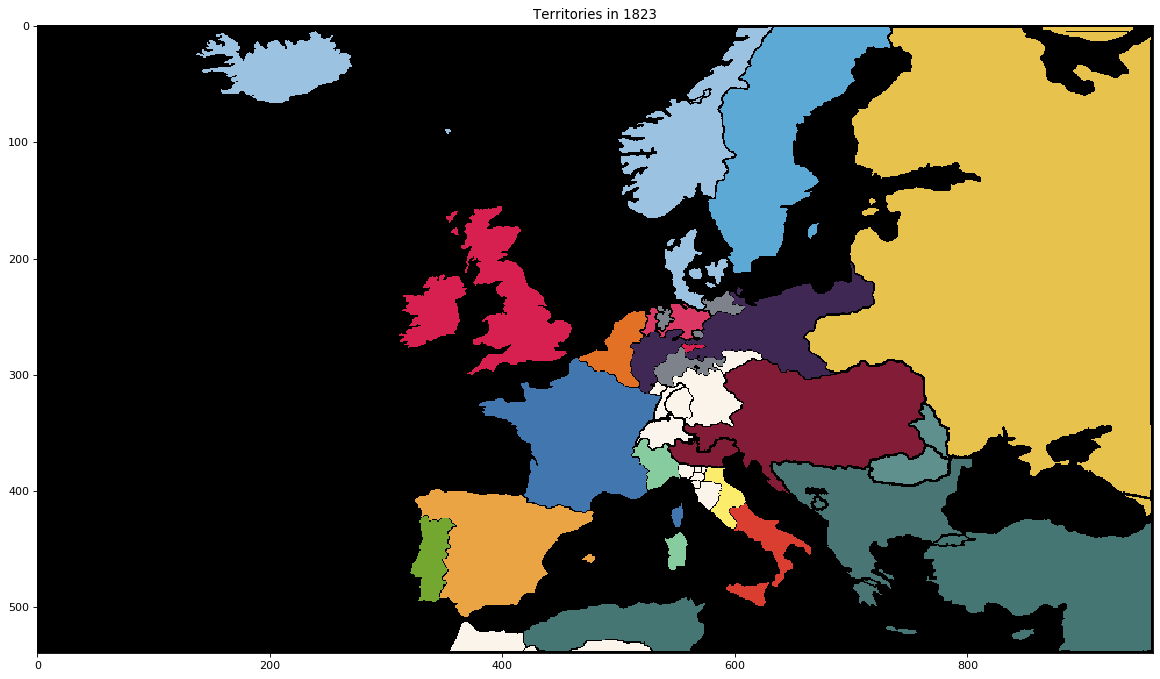

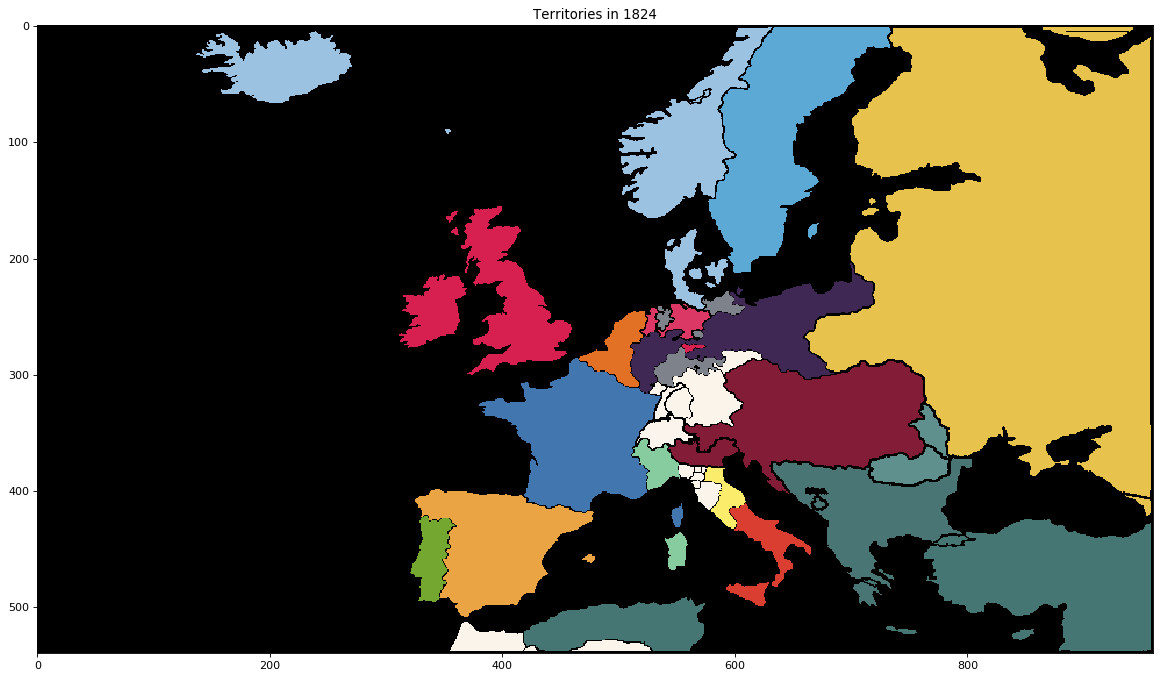

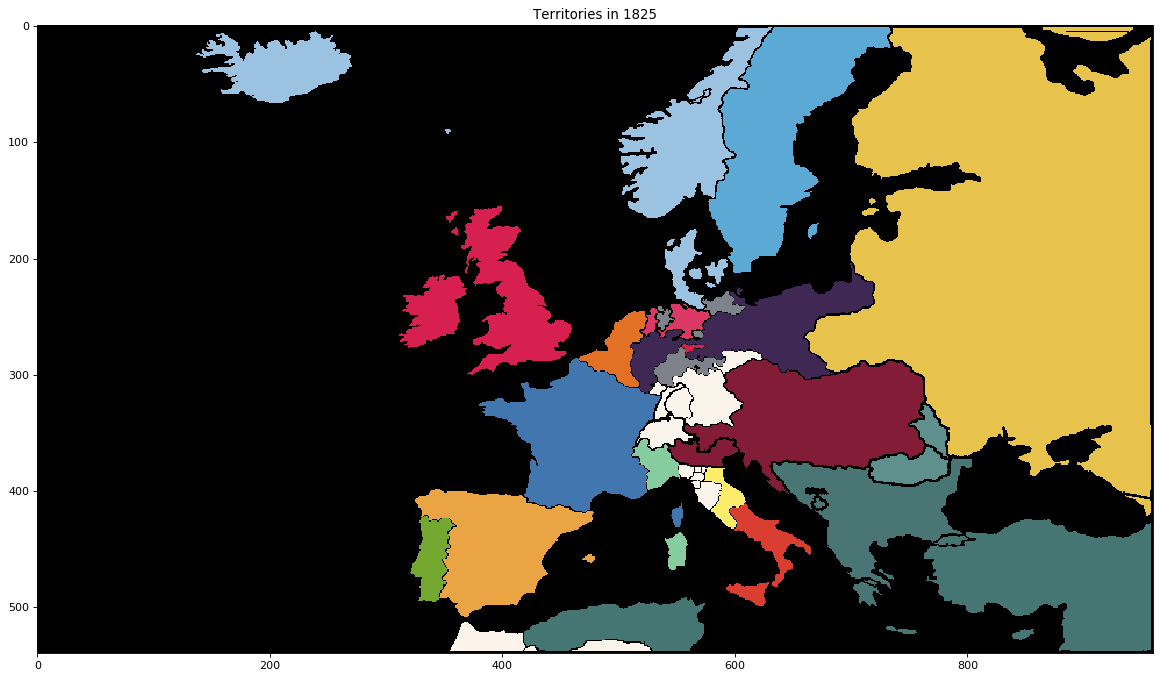

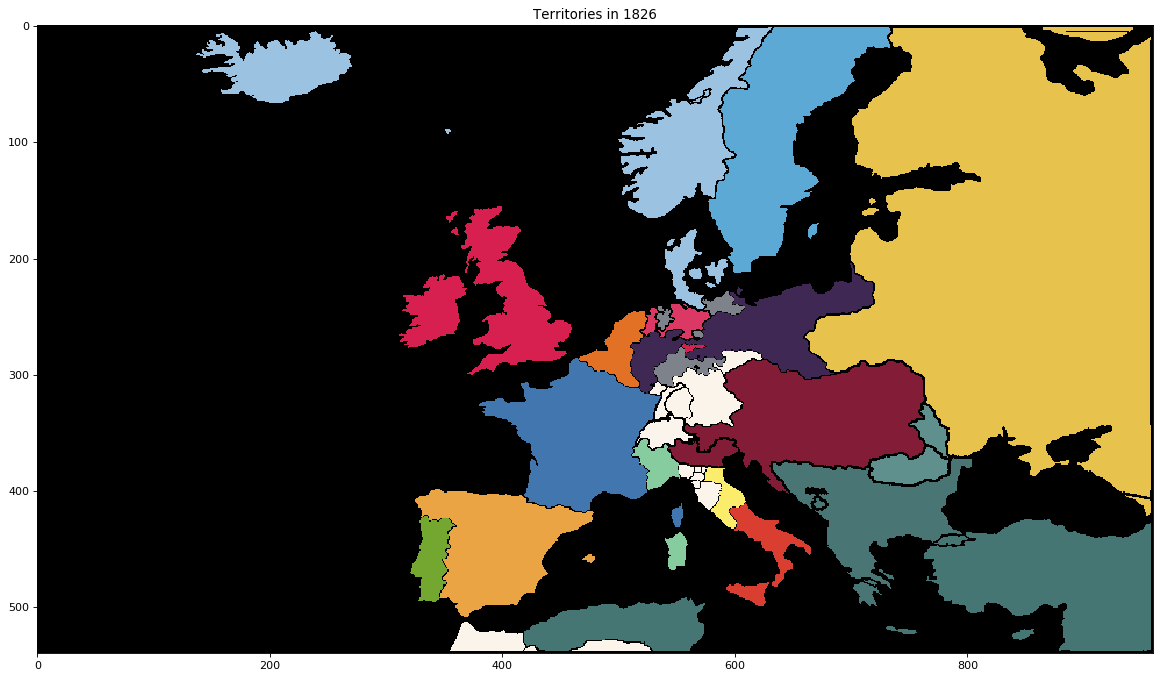

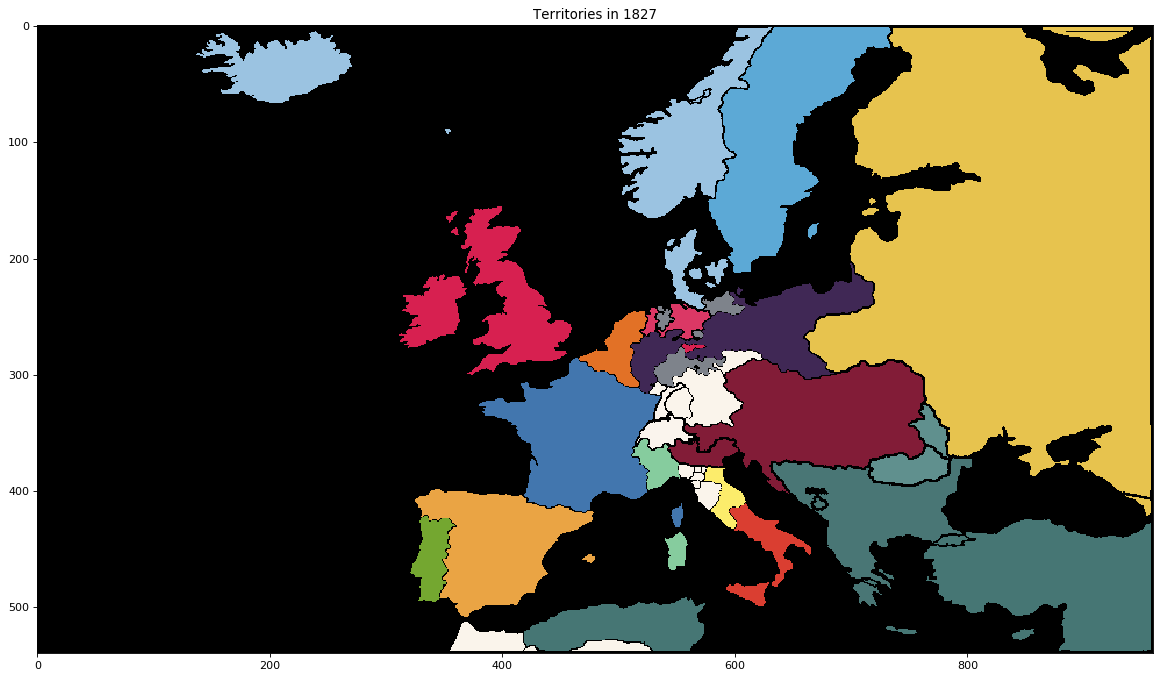

ignored 1 based on ignored_colors 


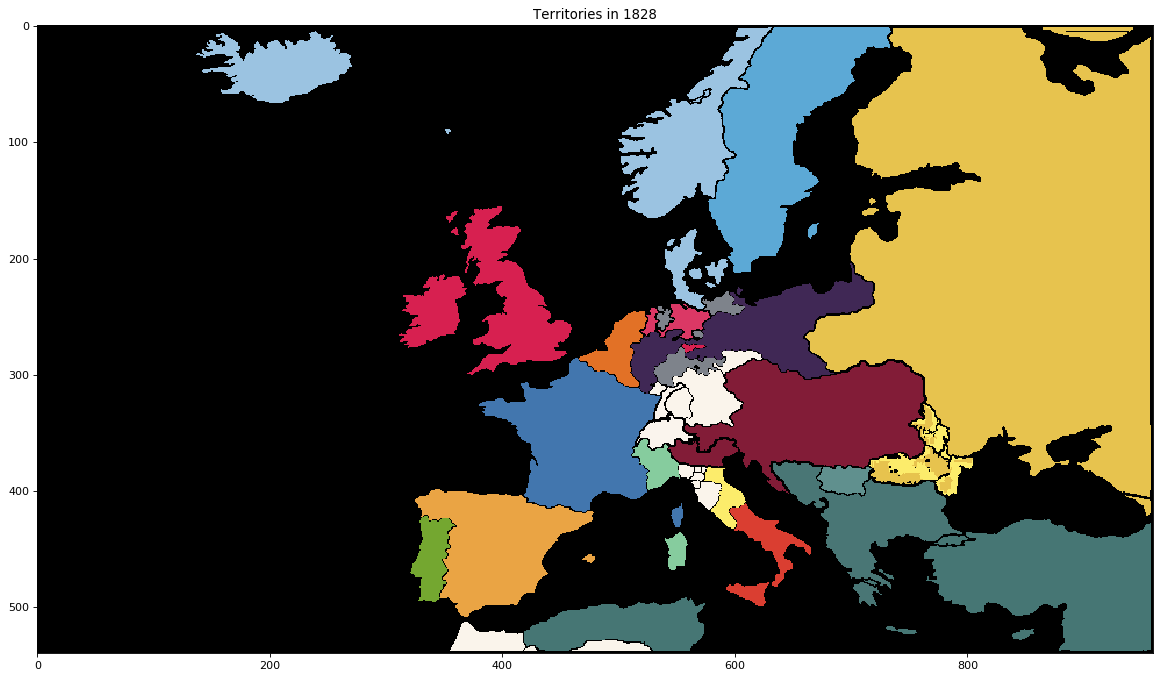

ignored 1 based on ignored_colors 


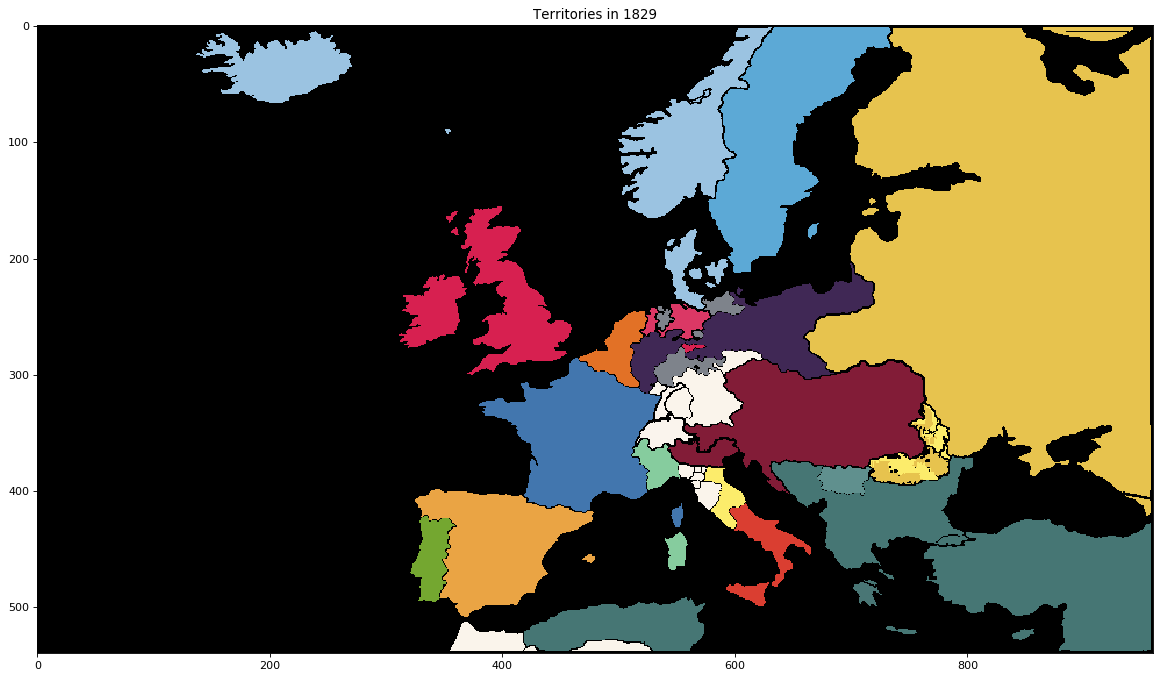

ignored 1 based on ignored_colors 


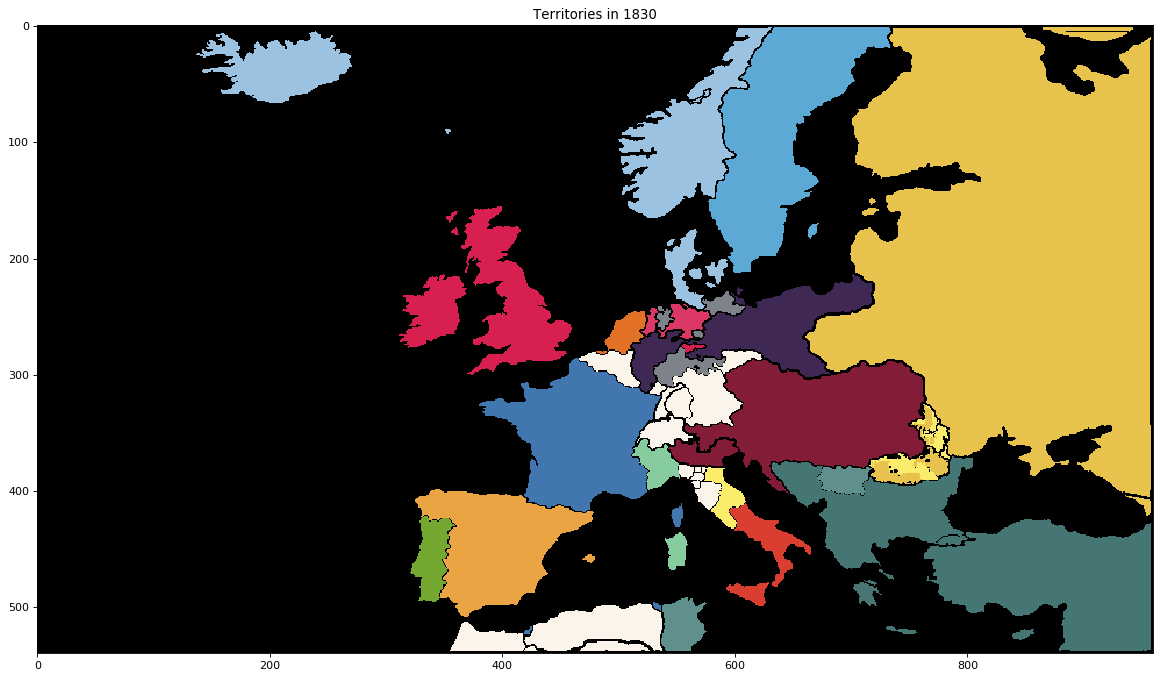

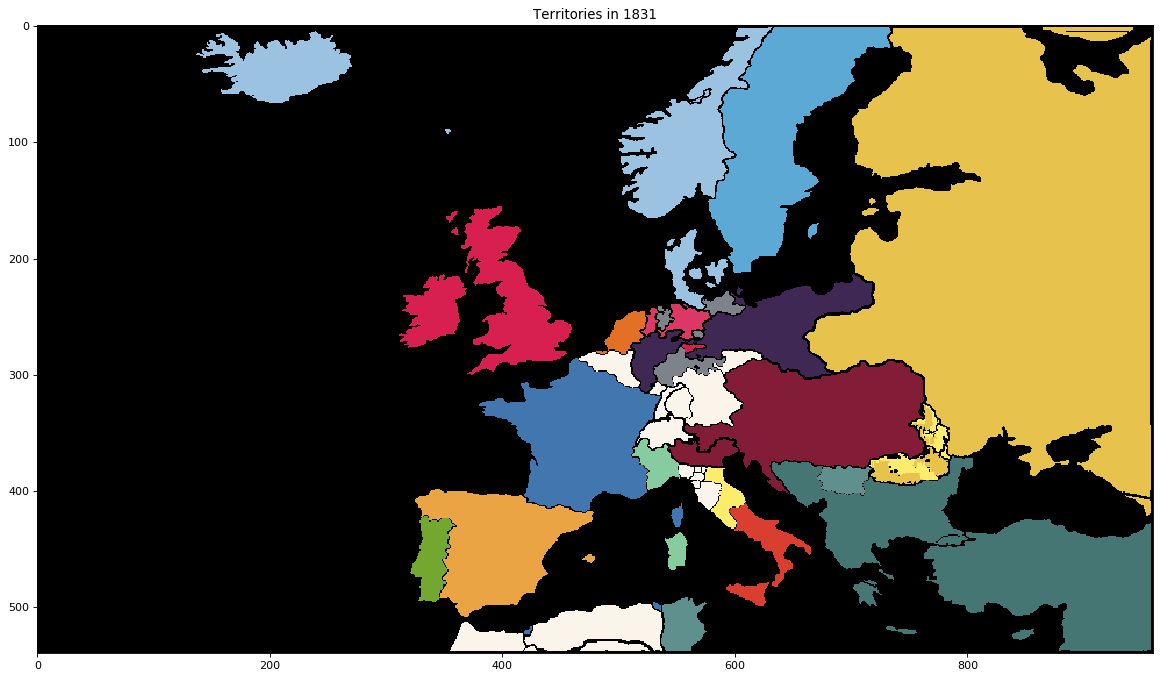

ignored 1 based on ignored_colors 


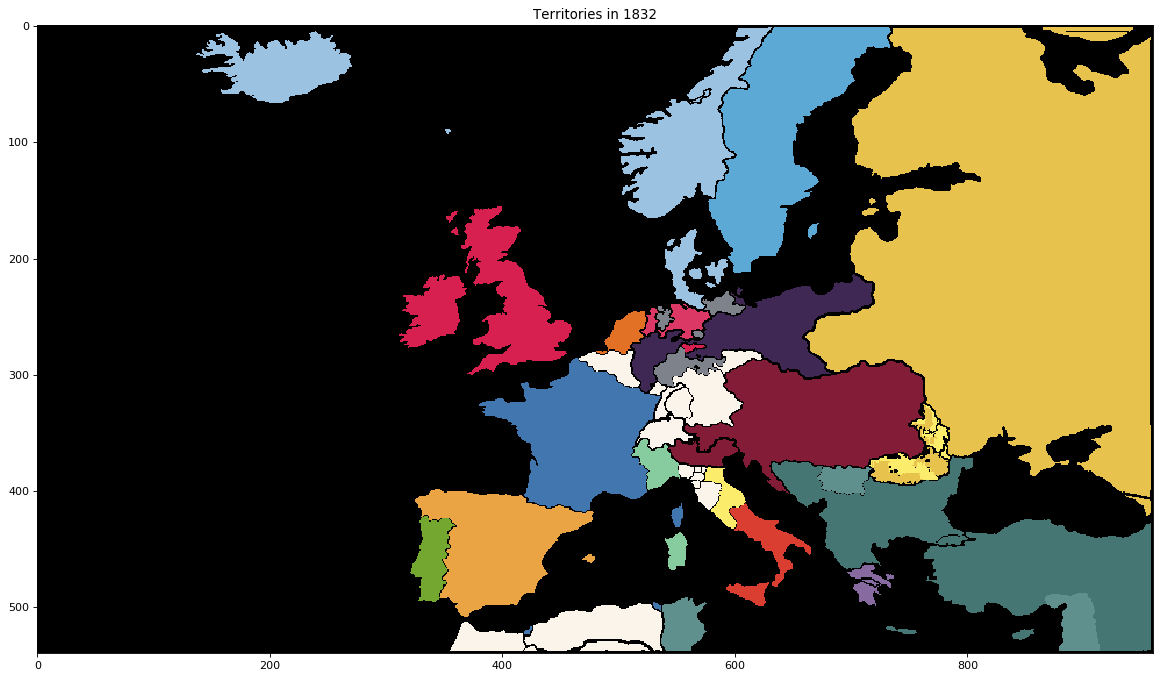

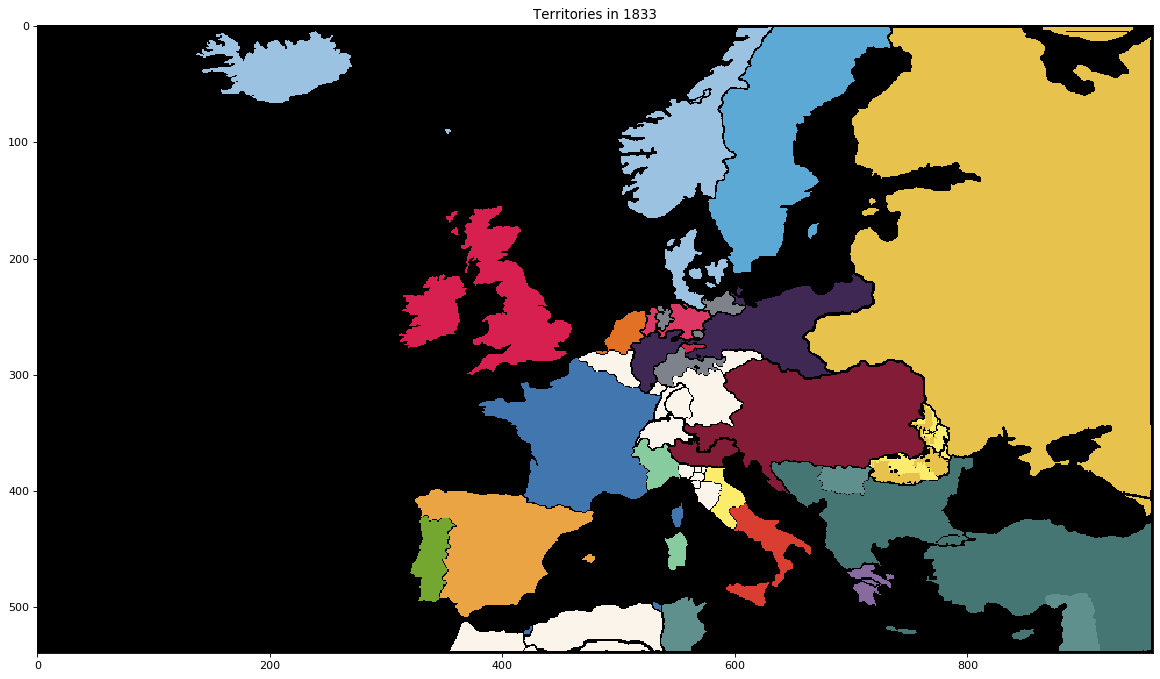

ignored 1 based on ignored_colors 


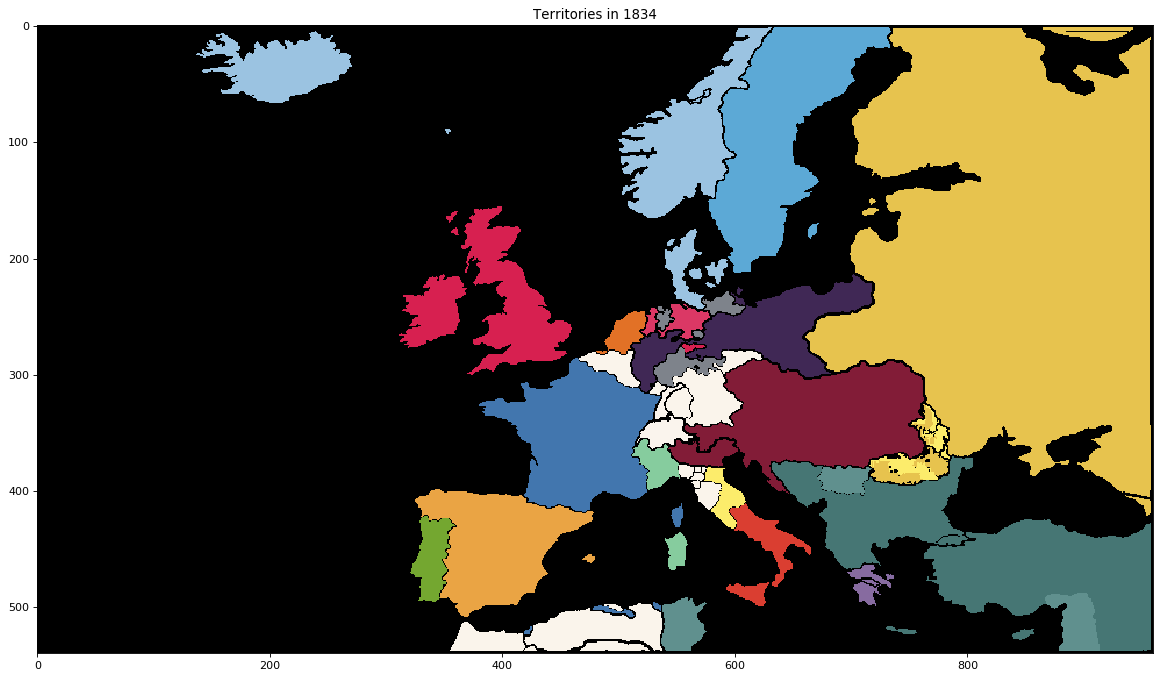

ignored 1 based on ignored_colors 


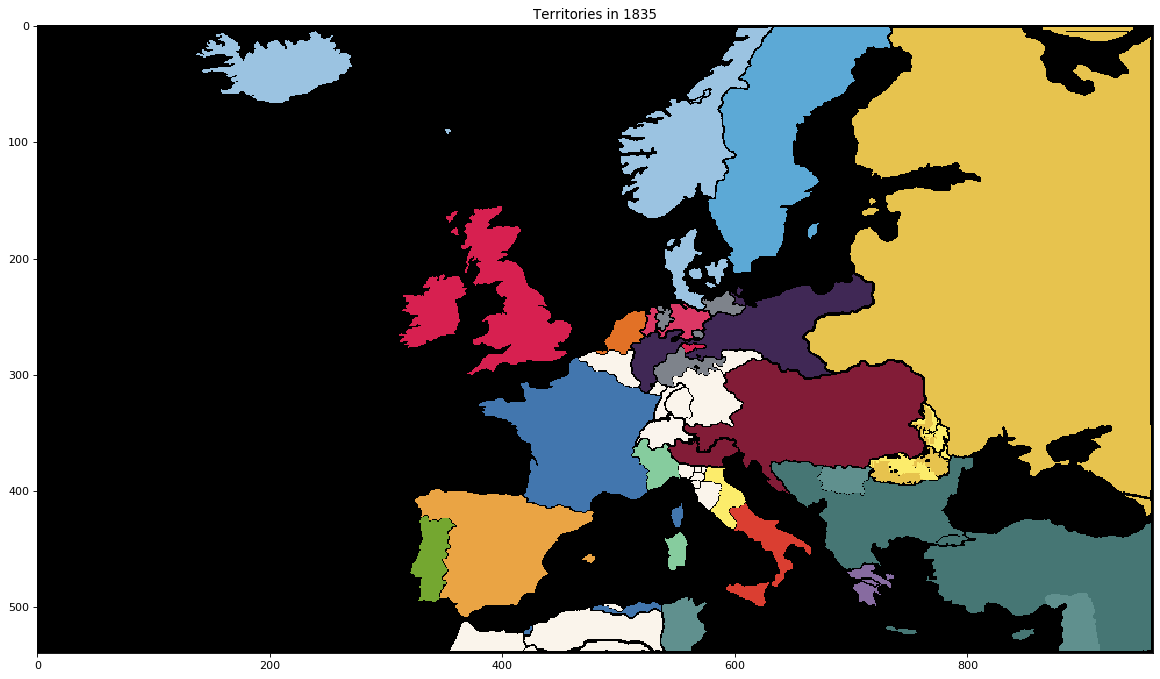

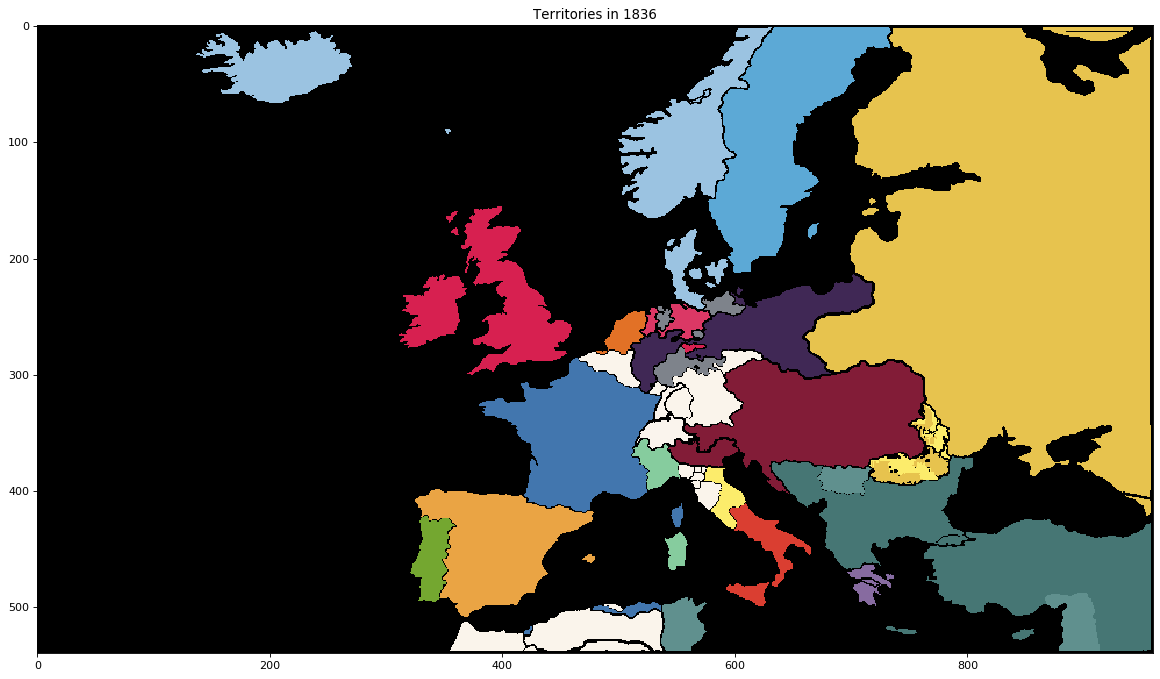

ignored 1 based on ignored_colors 


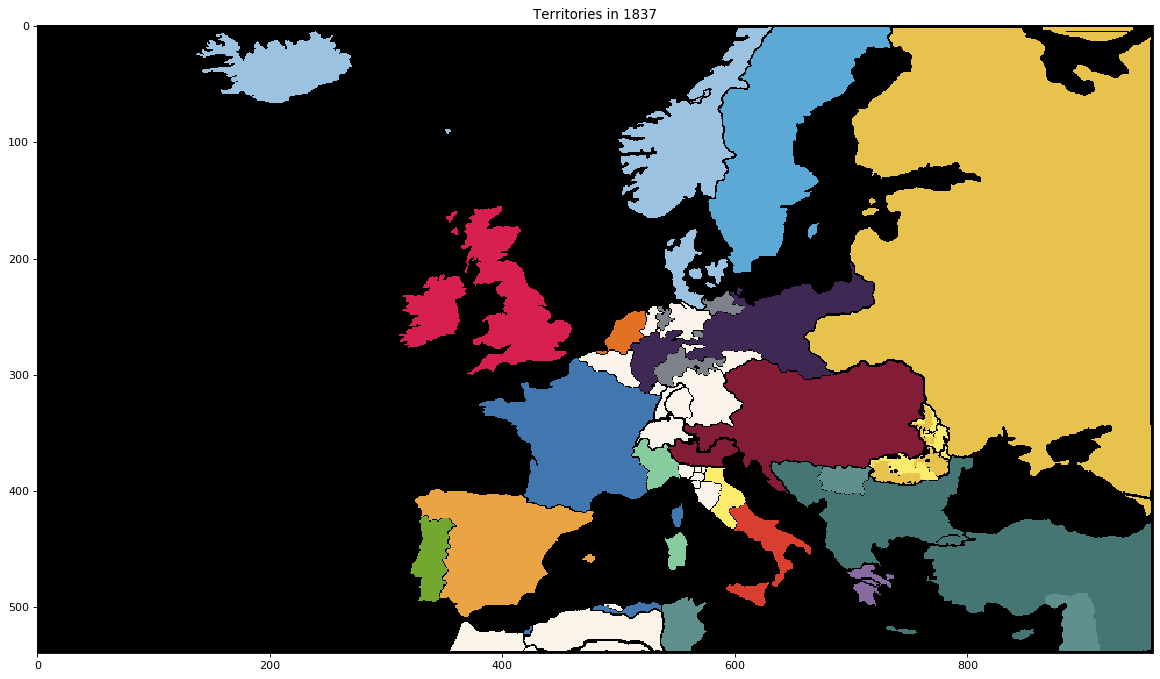

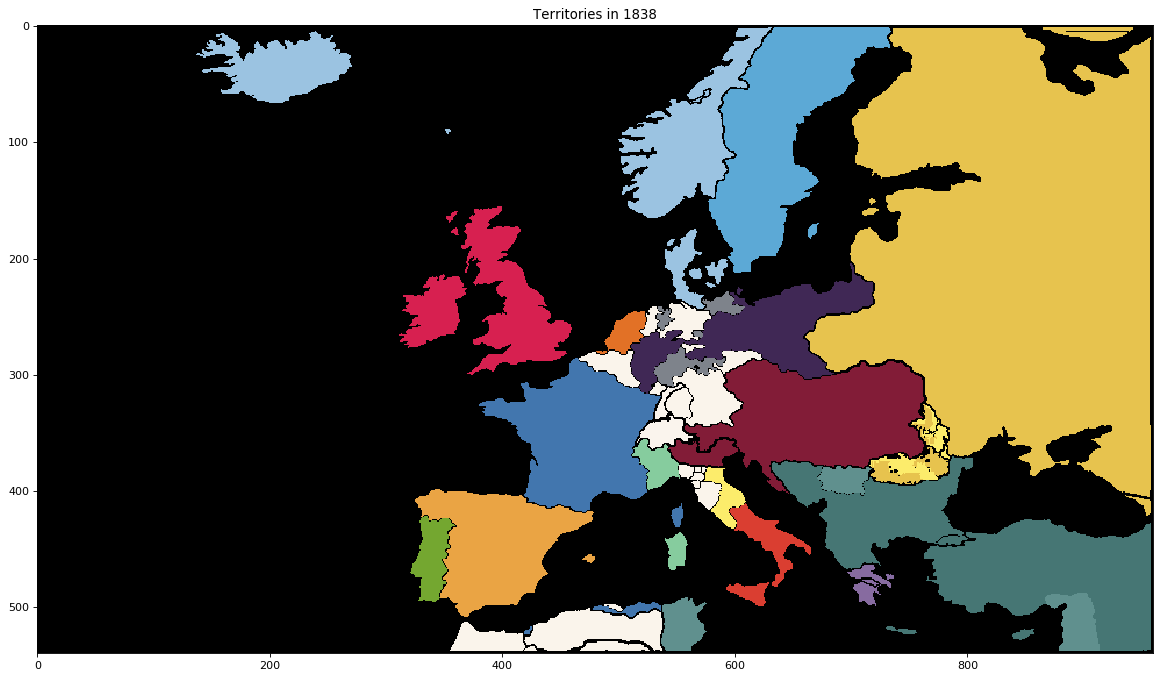

ignored 1 based on ignored_colors 


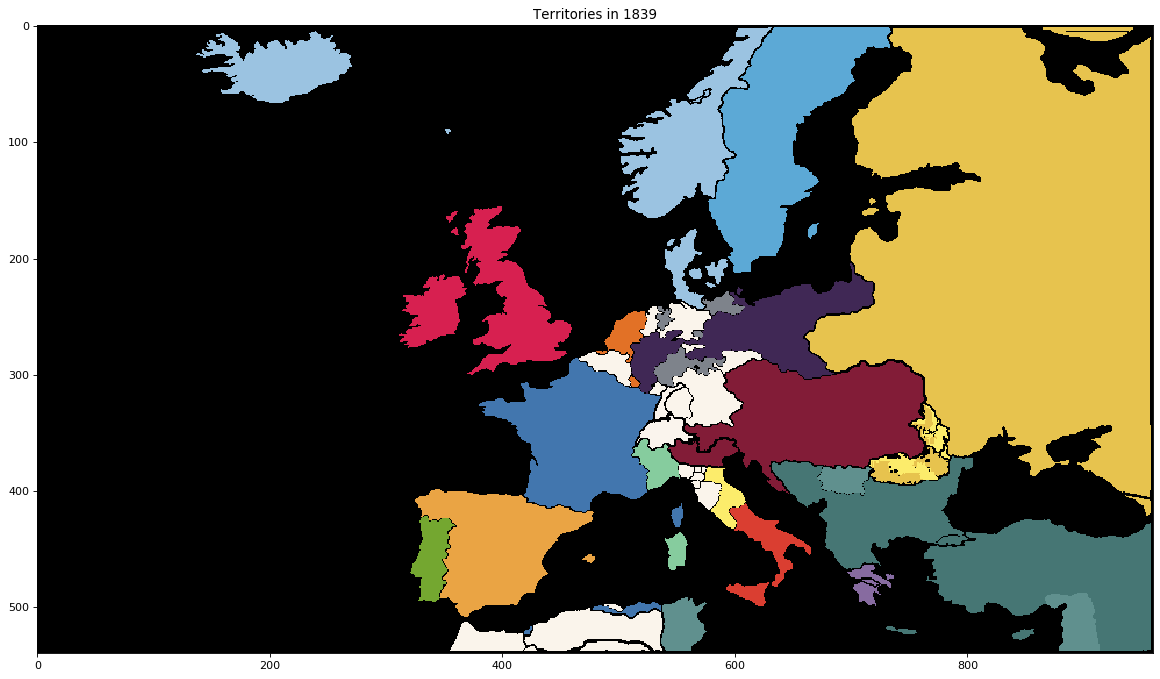

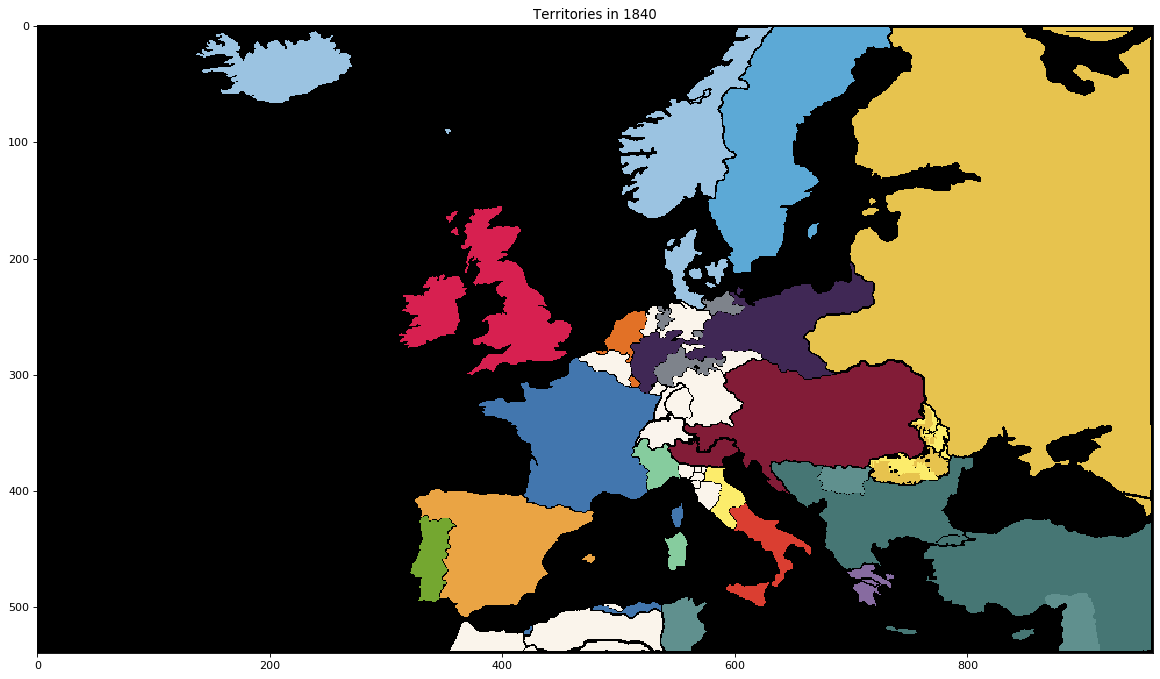

ignored 1 based on ignored_colors 


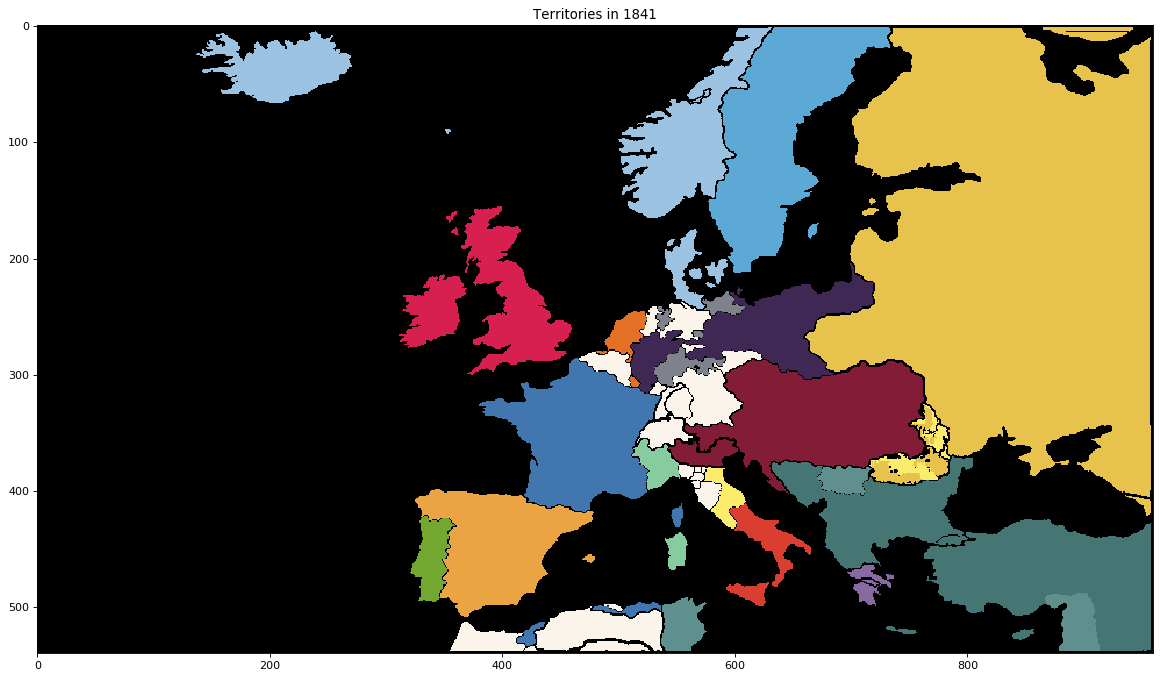

ignored 1 based on ignored_colors 


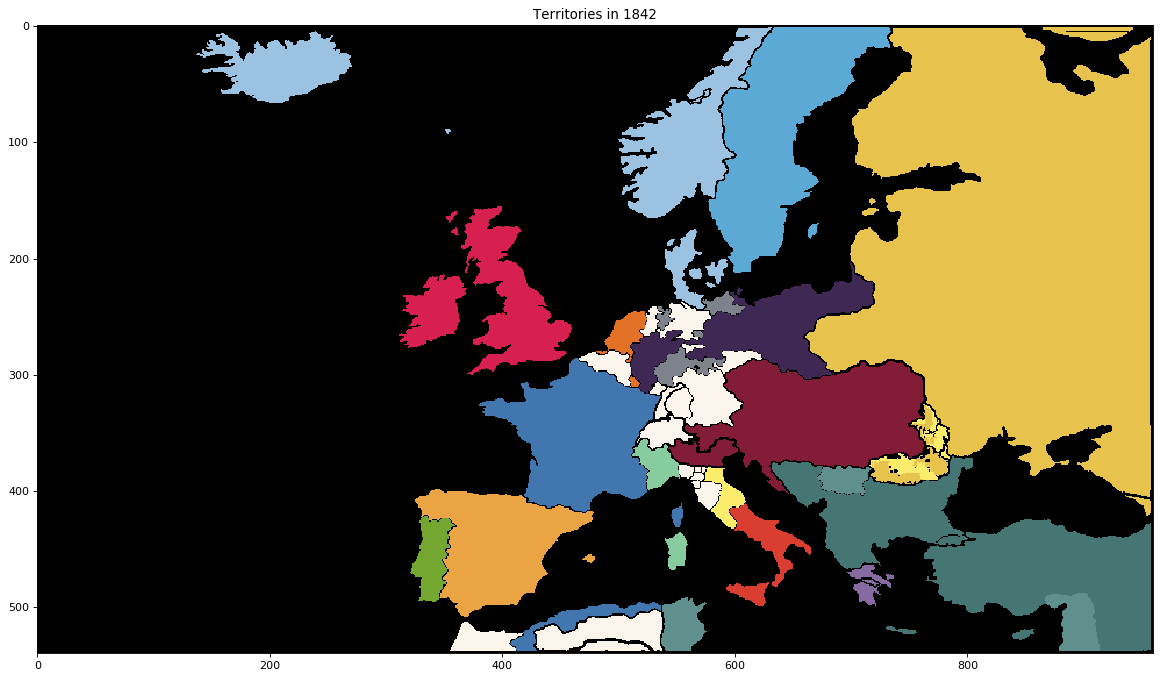

ignored 1 based on ignored_colors 


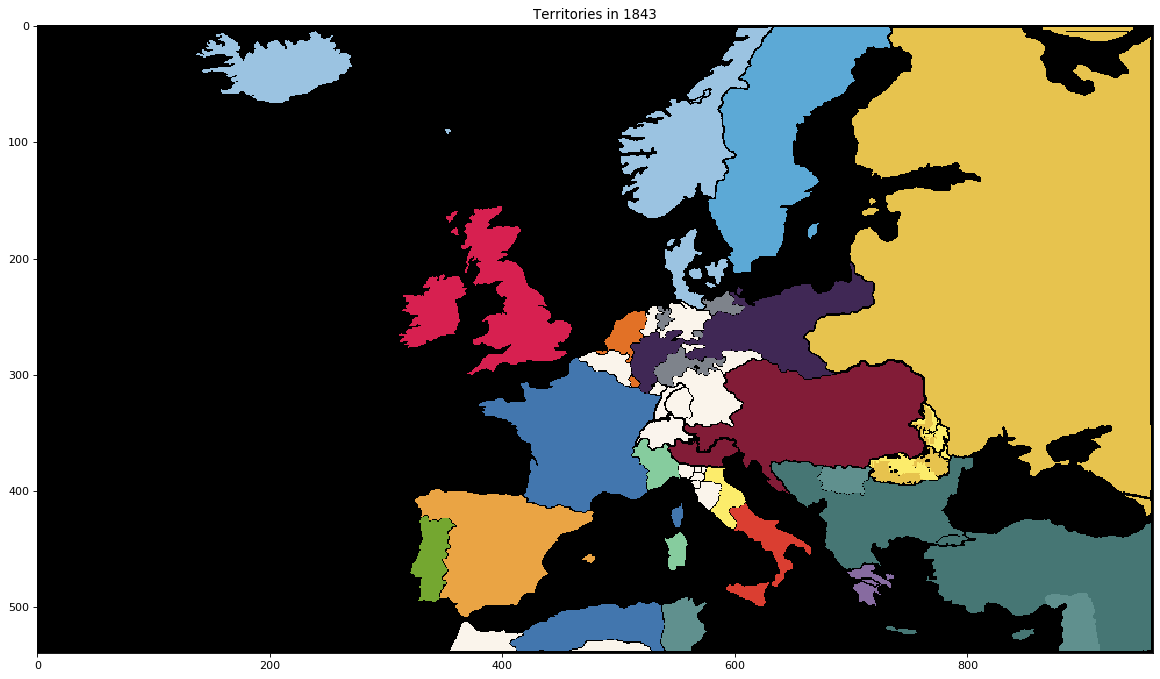

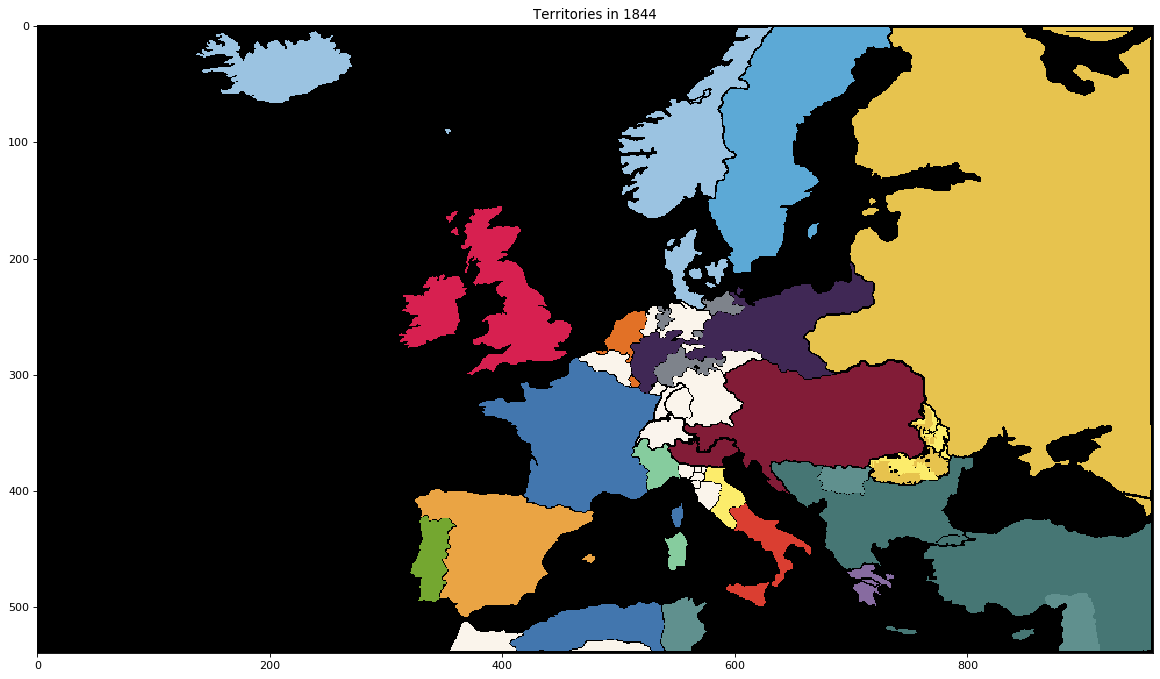

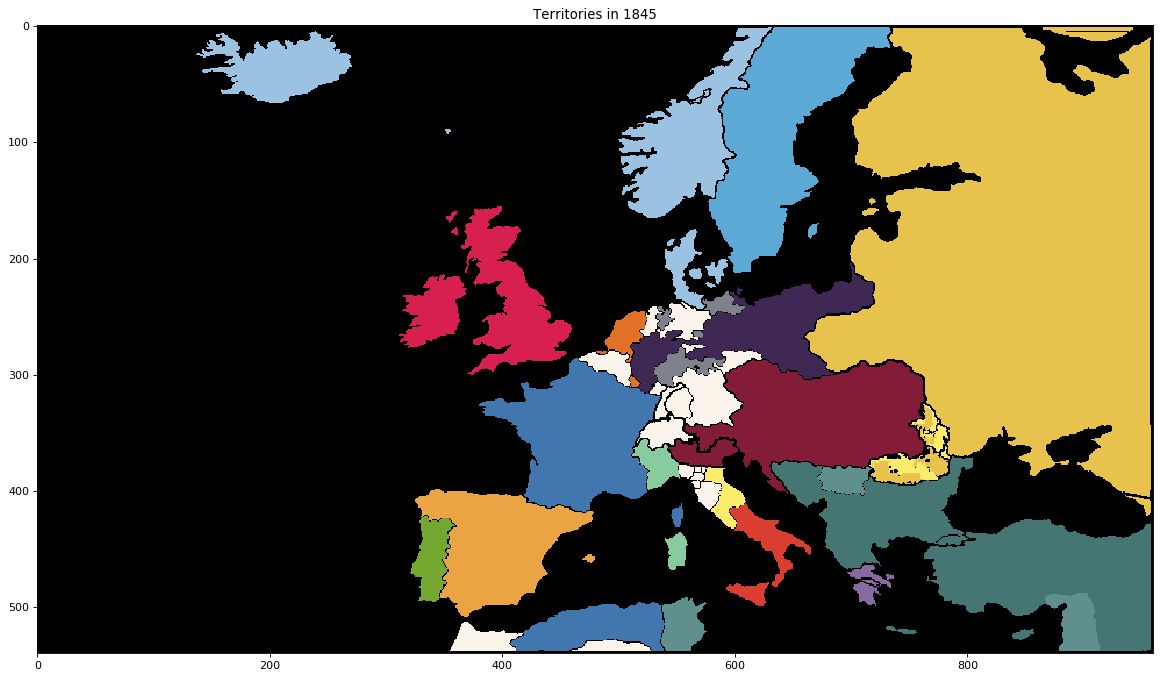

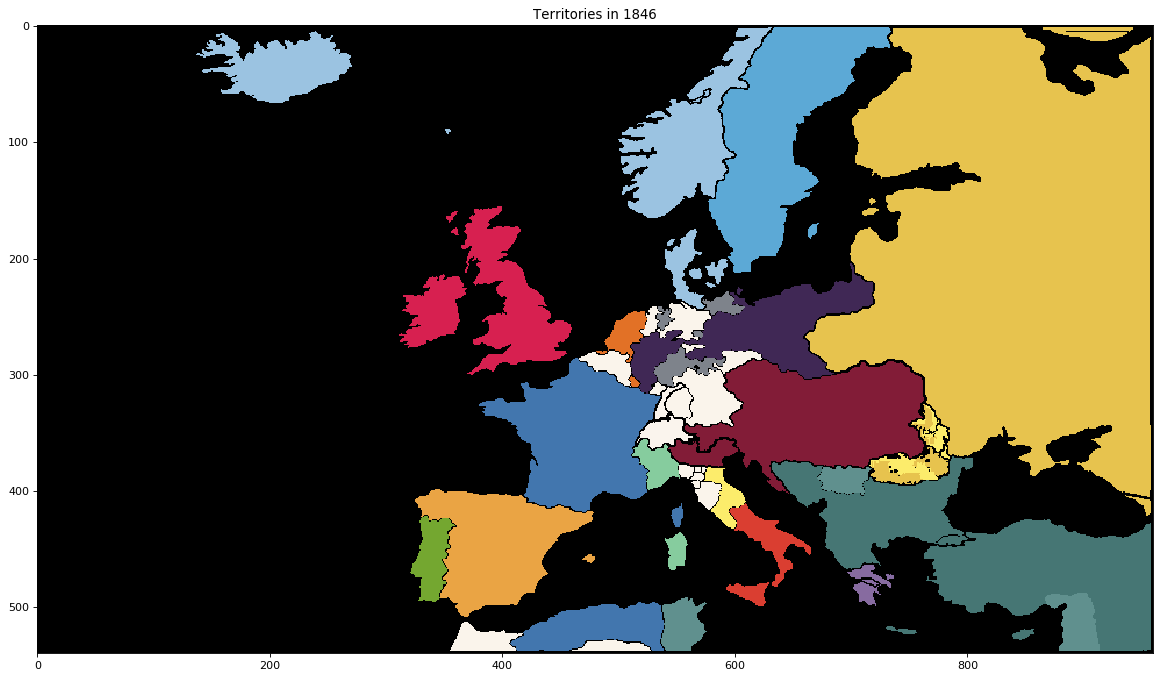

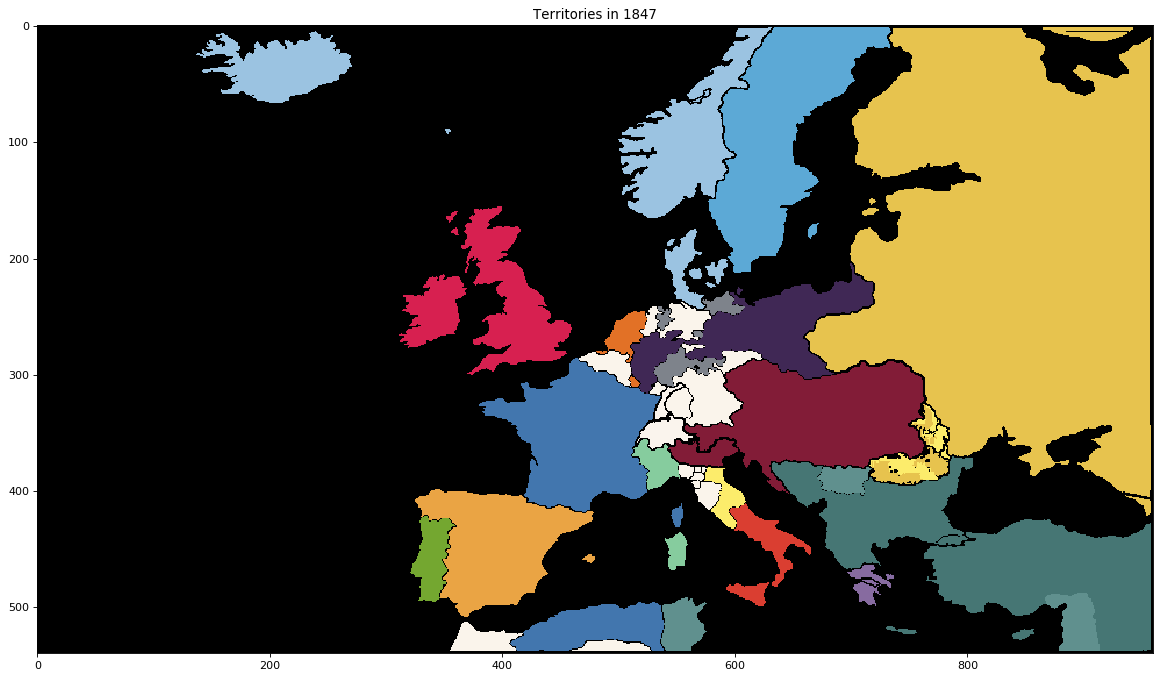

ignored 1 based on ignored_colors 


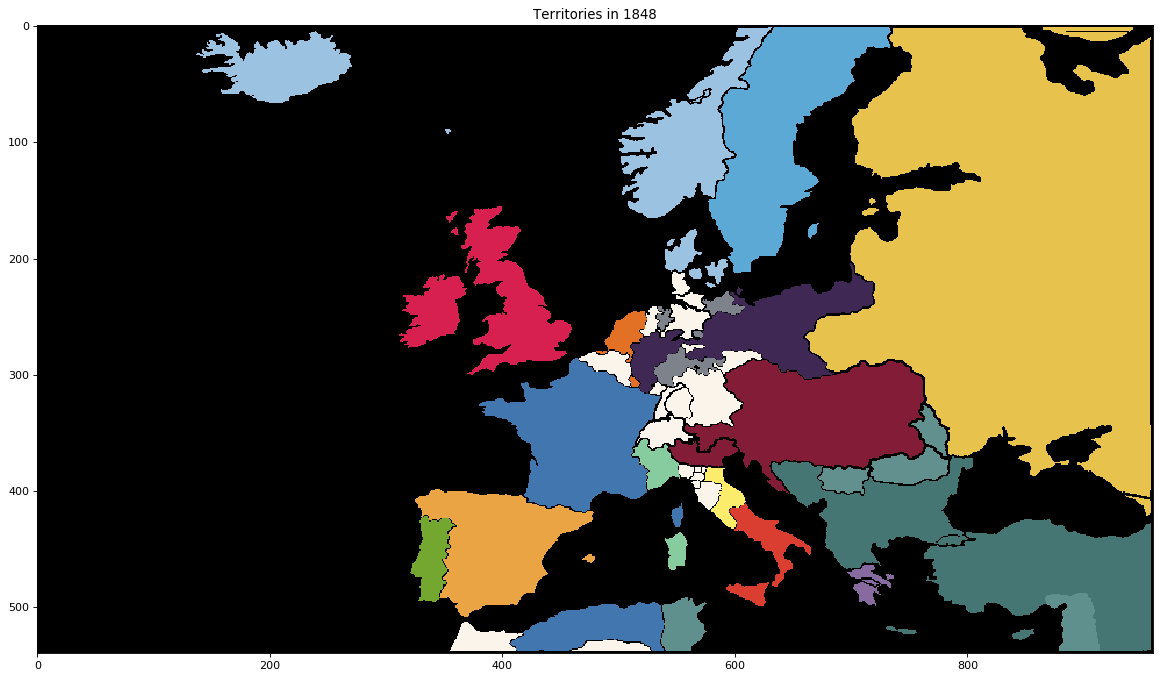

ignored 1 based on ignored_colors 


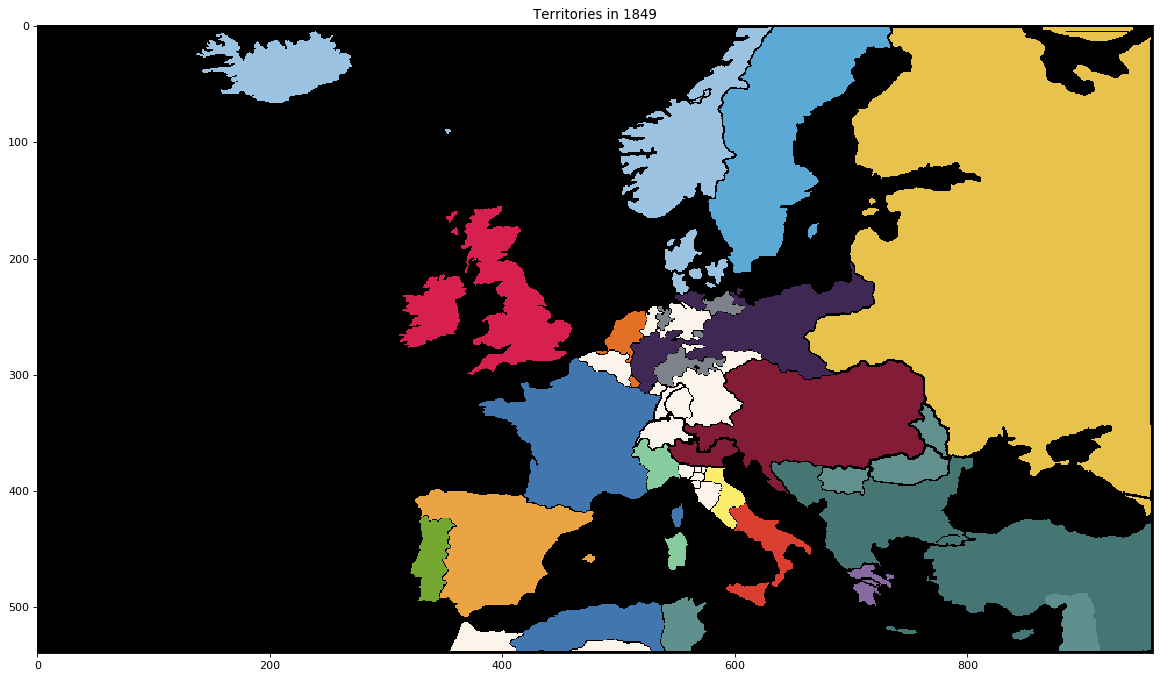

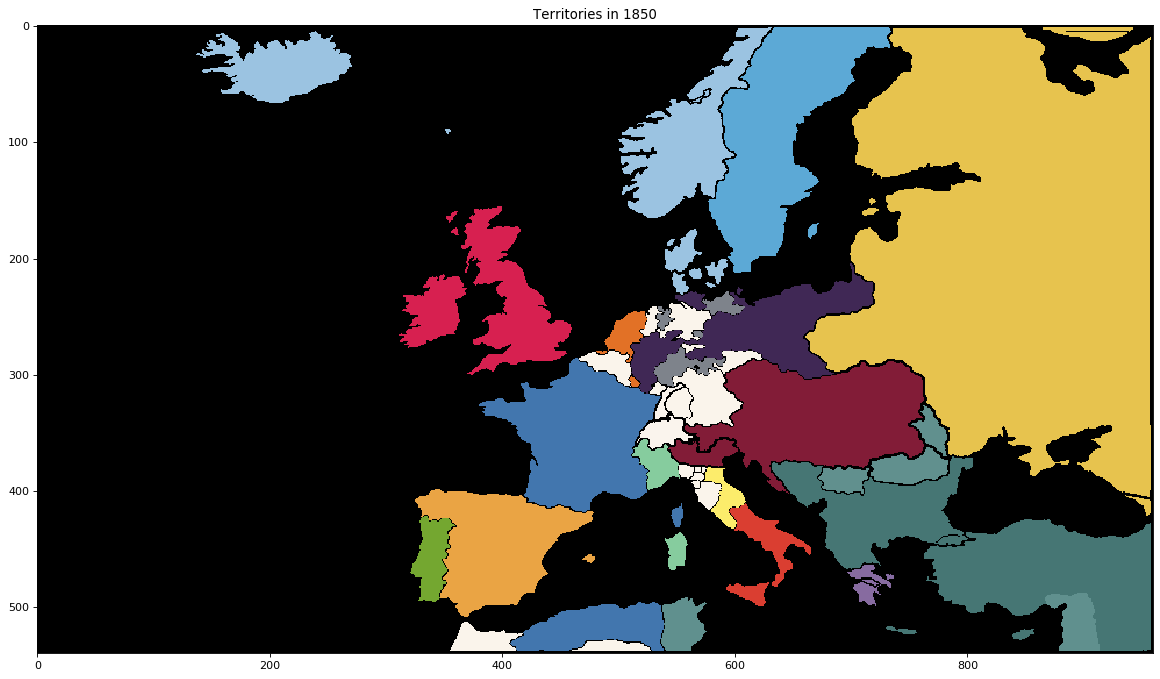

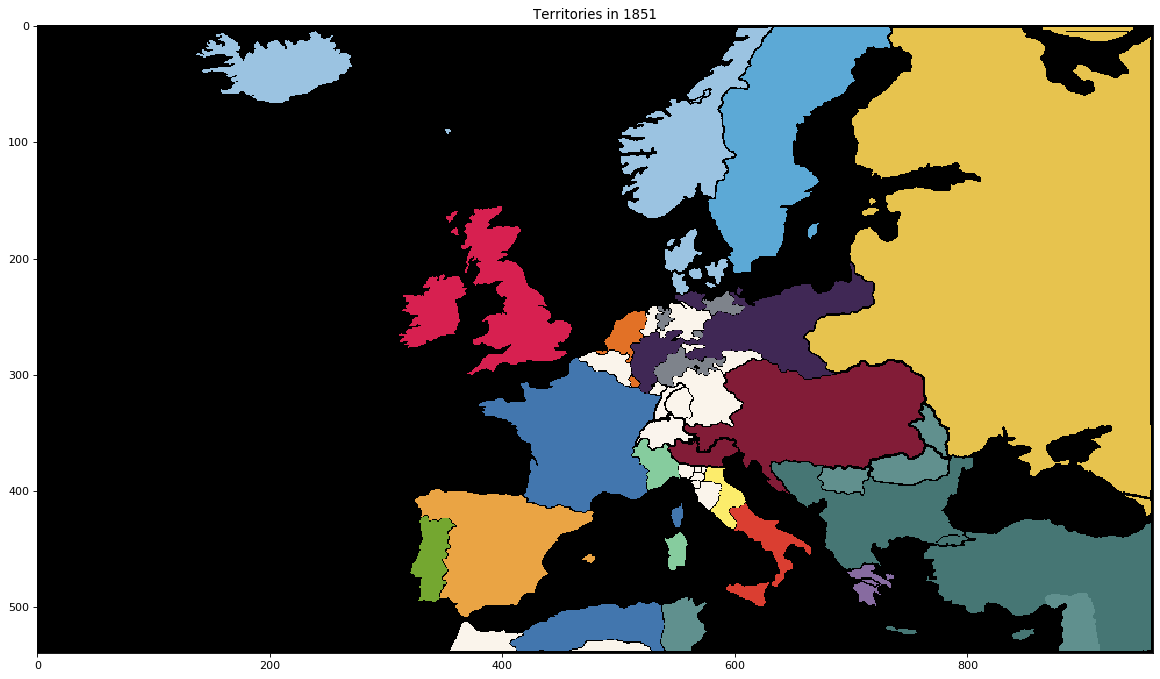

ignored 1 based on ignored_colors 


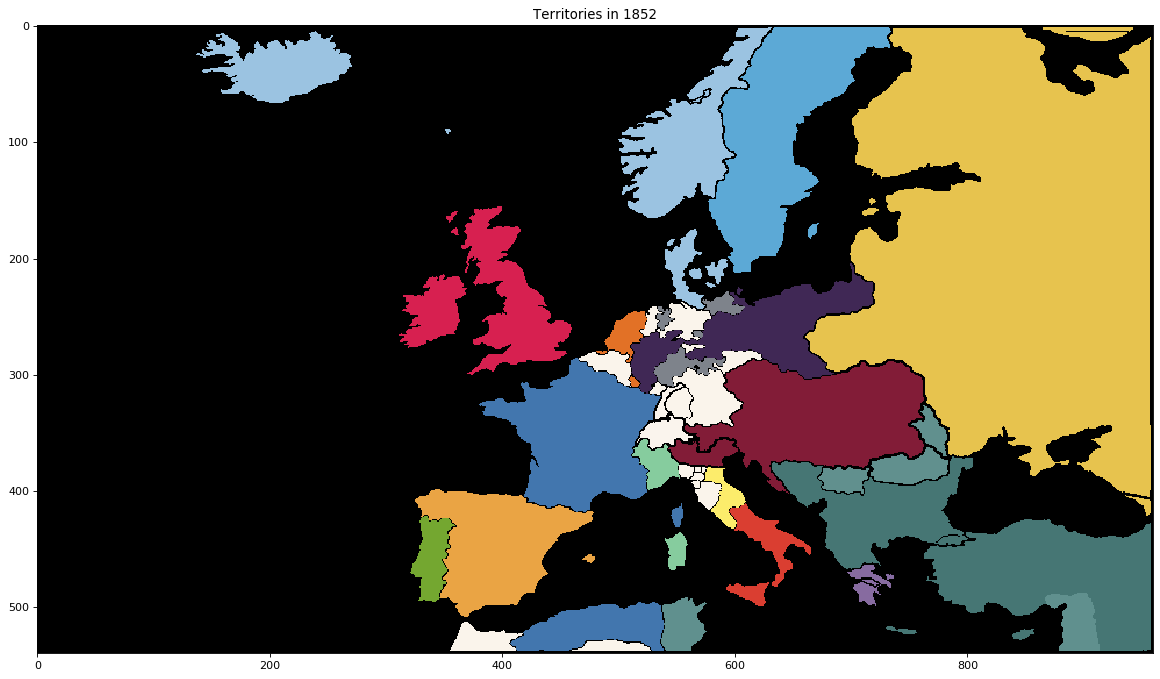

ignored 1 based on ignored_colors 


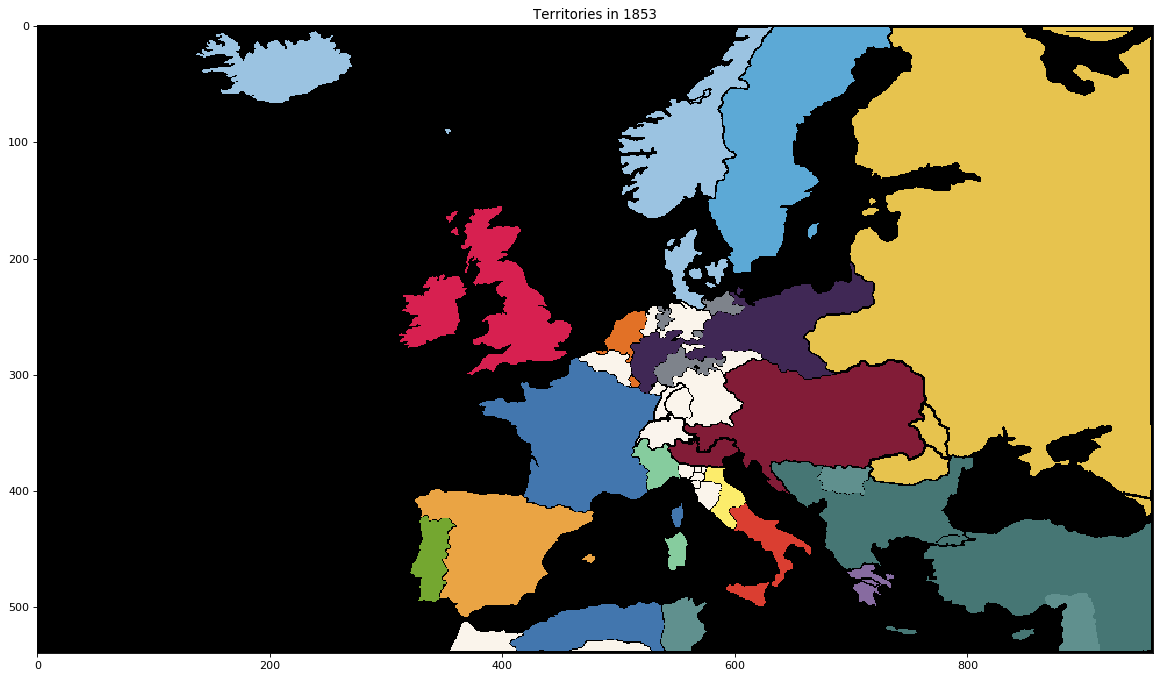

In [ ]:
import numpy as np
from shapely.geometry import box, Polygon, MultiPolygon, mapping
import shapely.affinity
from drawing_utils import get_surrounding_colors, fill_box, draw_territories
from map_parsing import color_analysis, extract_territories_by_gradient, get_polygons
from tqdm.notebook import tqdm
import skimage.color
import matplotlib.pyplot as plt
import time
from serial_utils import save_territories
import json

black_img = np.zeros((1080,1920,3))

def load_clean_map(year, ignored_boxes):
    res = skimage.color.rgba2rgb(plt.imread(f'input/{year}.png'))
    for box in ignored_boxes:
        surrounding_color = get_surrounding_colors(res, box)
        fill_box(res,box,  surrounding_color)
    return res


    

def get_change_zones(previous_map, next_map):
    prev_lab = skimage.color.rgb2lab(previous_map)
    next_lab = skimage.color.rgb2lab(next_map)
    change_map = np.sum((prev_lab - next_lab)**2, axis=2)
    change_zones = MultiPolygon([p for p in get_polygons(change_map > 1000) if p.area>60]) 
    if not change_zones.is_valid:
        change_zones = change_zones.buffer(0)
    change_zones_dilated = change_zones.buffer(4)
    if isinstance(change_zones, Polygon):
        change_zones = MultiPolygon([change_zones])
    if isinstance(change_zones_dilated, Polygon):
        change_zones_dilated = MultiPolygon([change_zones_dilated])
    return change_zones , change_zones_dilated


def remove_unimpacted(territories, change_zones_dilated):
    return [t for t in territories if t.polygon.intersects(change_zones_dilated)]


def solve_conflict(old, new, change_zones):
    return new if  old.polygon.union(new.polygon).intersects(change_zones) else old

def merge_new_and_previous_analysis(new_analysis, previous_analysis, change_zones, verbose=False):
    new_surface = MultiPolygon([t.polygon for t in new_analysis]).buffer(0)
    previous_uncovered_by_new = [t for t in previous_analysis if not t.partially_covered_by(new_surface)]
    covered_previous = [t for t in previous_analysis if t not in previous_uncovered_by_new]
    conflicts = []
    new_analysis_unconflicted = new_analysis
    for old_territory in covered_previous:
        for new_territory in new_analysis:
            if old_territory.roughly_same_as(new_territory):
                conflicts.append((old_territory, new_territory))
                new_analysis_unconflicted.remove(new_territory)
    conflicts = np.array(conflicts)
    merged_conflicts = []
    if verbose:
        draw_territories(black_img,
                         (previous_uncovered_by_new, 'fill', 'red'),
                         (new_analysis_unconflicted, 'fill', 'green'),
                        (conflicts[:,0] if len(conflicts) else [], 'stroke', [1,.5,0]),
                         (conflicts[:,1] if len(conflicts) else [], 'stroke', [1,1,0]),
                         'Kept from last year in red, added this year in blue, conflicts in orange (old) and yellow (new)'
                        )
    eroded_change_zones = change_zones.buffer(-2)
    for old_territory, new_territory in conflicts:
        result = solve_conflict(old_territory, new_territory, eroded_change_zones)
        merged_conflicts.append(result)
       # draw_territories(black_img, (result, 'fill', 'green' if result is new_territory else [1, .5,0]),(change_zones, 'fill', 'white'), (old_territory if new_territory is result else new_territory, 'stroke', [.5, .5, .5]), 
        #                'Kept new in green or old in orange, green if intersects white')
    if len(conflicts) and verbose:
        draw_territories(black_img,
                         ([old for old in conflicts[:,0] if old in merged_conflicts], 'fill', [1, .5, 0]),
                         ([n for n in conflicts[:,1] if n in merged_conflicts], 'fill', 'green'),
                         (eroded_change_zones, 'fill', 'white'),
                         ([old for old in conflicts[:,0] if old not in merged_conflicts]+[n for n in conflicts[:,1] if n not in merged_conflicts], 'stroke', [.5, .5, .5] ),
                         'Conflict resolution, kept orange from last year, updated this year with green (because green union gray intersects white)'
                        )
    
    return previous_uncovered_by_new + new_analysis_unconflicted + merged_conflicts
    

def analyze_year(previous_year_analysis, previous_year_map, this_year_map, ignored_colors, verbose=False):
    if not previous_year_analysis:
        return time_unaware_analysis(this_year_map, ignored_colors)
    change_zones, dilated_change_zones = get_change_zones(previous_year_map, this_year_map)
    if not len(change_zones.geoms):
        return previous_year_analysis
    terr_by_color = color_analysis(this_year_map, ignored_colors)
    relevant_terr_by_color = remove_unimpacted(terr_by_color, dilated_change_zones)
    if verbose :
        draw_territories(black_img, (relevant_terr_by_color, 'fill', 'green'), (dilated_change_zones, 'fill', 'white'), (terr_by_color, 'stroke', 'red'), 'Kept only green cuz intersect chzones')
    territories_by_gradient = extract_territories_by_gradient(relevant_terr_by_color, this_year_map, show_progress=False)
    if verbose :
        draw_territories(black_img, (territories_by_gradient, 'fill', None), 'gradient analysis')
    this_year_analysis = merge_new_and_previous_analysis(territories_by_gradient,previous_year_analysis, change_zones)
    return this_year_analysis

def time_unaware_analysis(map_image, ignored_colors):
    terr_by_color = color_analysis(map_image, ignored_colors)
    terr_by_gradient = extract_territories_by_gradient(terr_by_color, map_image, show_progress=False)
    #draw_territories(black_img, (terr_by_gradient, 'fill', None), 'gradient analysis')
    return terr_by_gradient


    
def time_aware_analysis(start_year, end_year, ignored_boxes, ignored_colors, verbose=False):
    first_year_map = load_clean_map(start_year, ignored_boxes)
    previous_year_map = None
    previous_year_analysis = None
    
    for year in tqdm(range(start_year, end_year+1)):
        global current_year
        current_year = year
        this_year_map = load_clean_map(year, ignored_boxes)
        this_year_analysis = analyze_year(previous_year_analysis , previous_year_map, this_year_map, ignored_colors)
        draw_territories(black_img, (this_year_analysis, 'fill', None), f'Territories in {year}')
        save_territories(this_year_analysis, f'output/{year}.json')
        previous_year_analysis = this_year_analysis
        previous_year_map = this_year_map

start_year = 1700
end_year = 2017
ignored_boxes =[box(10, 230, 600, 1050),  box(10, 10, 170, 150), box(800, 10, 1040, 150),box(1030, 30, 1070, 130) ]
sea_color = get_surrounding_colors(skimage.color.rgba2rgb(plt.imread('input/1700.png')), box(10, 230, 600, 1050))
time_aware_analysis(start_year, end_year, ignored_boxes, [sea_color, [0,0,0]], True)